# Graphs_and_Social_Networks

## 1. Introduction

Using the whole anthologies abstract dataset.

1. From the abstracts part, using three different similarity thresholds (e.g. 0.05, 0.1, and 0.2), create an unweighted network from the obtained similar pairs (use MinHashing or LSH) for each threshold.


2. From the basket list of authors/editors, using A-Priori or PCY, create a weighted network, using the support threshold as weight.

3. Find the communities for the networks obtained in 1. and 2. Comment about the results with respect to the different thresholds and methods. How does it compare with the same analysis using 1-NN done in previous tasks?

4. Use a ready-made software, library or service (eg. gephi) for visualizing one the network in 1. or 2.Comment your results.

In [1]:
import requests # to download the dataset
import gzip
import shutil # to extract the gz file
import re # for text cleaning

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random 

from nltk.corpus import stopwords # calculation of stopwords
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from pylatexenc.latex2text import LatexNodes2Text # fix umlaut vocals in names
import itertools
import time
import binascii

import networkx as nx

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alext\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



## 2. ETL
•	Extract, load and transform your data. In your code data should be retrieved from an online source, NOT from your local drive, otherwise, nobody can run your code without additional effort.
•	Report the essential description of data.
•	Don’t print out dozens of raw lines.


In [2]:
# Download data 
url = 'https://aclanthology.org/anthology+abstracts.bib.gz'
fname = "anthology+abstracts.bib"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

# Extract the gz file
with gzip.open('anthology+abstracts.bib.gz', 'rb') as f_in:
    with open('anthology+abstracts.bib', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [3]:
# Find all the rows in the file that contain an abstract and laod the text to a list
abstracts = []
with open(fname, "r",encoding="UTF-8") as f:
    s = f.readlines()
    for x in s:
        if x.__contains__('abstract'):
            start = x.find('   abstract = "') + len('   abstract = "')
            end = x.find('",')
            substring = x[start:end]
            abstracts.append(substring)
    f.close()

print("{} abstracts were found in the file.".format(len(abstracts)))

30807 abstracts were found in the file.


In [4]:
# Some cleaning

minletters = 200 
abstracts_clean = []

for a in abstracts: 
    if len(a) > minletters and len(re.findall('[a-zA-Z]',a)) >0.5*len(a):
        abstracts_clean.append(a) 
print("After cleaning, {} abstracts were remaining.".format(len(abstracts_clean)))

After cleaning, 30304 abstracts were remaining.


In [5]:
# Find all the rows in the file that contain an author/editor and load the text to a list
end = set(['",\n', '}\n'])
authors = []
with open("anthology+abstracts.bib", "r",encoding="UTF-8") as f:
    line = f.readline()
    while(line != ''):

        if line.__contains__('author =') or line.__contains__('editor ='):
            while not (line.endswith('",\n')|line.endswith('},\n')):
                line = line+f.readline()
            # something to clean
#           line = LatexNodes2Text().latex_to_text(line) # fix umlaut vocals; this part takes some time to run    
            line = re.sub('    editor = "|    author = "|",|\n|    author = {|    editor = {','',line)
            line = re.sub(',','',line)
            line = re.sub('  and      ',', ',line)
            authors.append(line)
            
        line = f.readline()
        
    f.close()

print("{} baskets of authors were found in the file.".format(len(authors)))

73199 baskets of authors were found in the file.


In [6]:
def readdata(k, fname=authors, report=False):
    C_k = []
    b = 0

    for line in fname:
        if report:
            print(line)
         
        # gather all items in one basket
        C_k.append(line.split(", "))

        # end of basket, report all itemsets
        for author in C_k:
            for itemset in itertools.combinations(author, k):
                yield frozenset(itemset)
            C_k = []
                
        if report:
            print("")

    # last basket
    if len(C_k) > 0:
        for itemset in itertools.combinations(C_k, k):
            yield frozenset(itemset)

In [7]:
# pair of elements

def get_C(k):

    start = time.time()
    C = {}
    for key in readdata(k):  # False report
        if key not in C:
            C[key] = 1
        else:
            C[key] += 1
    
    return C


C1 = get_C(1)
C2 = get_C(2)

## 3. Modeling
•	Prepare analytics here and construct all the data objects you will use in your report.
•	Write functions and classes to simplify tasks. Do not repeat yourself.
•	Avoid output.
•	Refactor your code until it’s clean


In [8]:
def get_shingles(text, k=5):
    """Get all shingles from requested file (hashes of these shingles)
    """
    L = len(text) # the length of each abstract
    shingles = set()  # we use a set to automatically eliminate duplicates
    for i in range(L-k+1):
        shingle = text[i:i+k]
        crc = binascii.crc32(shingle.encode('utf-8')) #& 0xffffffff  # hash the shingle to a 32-bit integer
        shingles.add(crc)
    return shingles  

In [9]:
def minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig):
    signature = np.ones((nsig,)) * (maxShingleID + 1)

    for ShingleID in shingles:
        hashCodes = ((A*ShingleID + B) % nextPrime) % maxShingleID
        np.minimum(signature, hashCodes, out=signature)

    return signature

In [10]:
# set global parameters to process the whole dataset
bands = 10
rows = 20
nsig = bands*rows  # number of elements in signature, or the number of different random hash functions

maxShingleID = 2**32-1  # record the maximum shingle ID that we assigned
nextPrime = 4294967311  # next prime number after maxShingleID

A = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)
B = np.random.randint(0, nextPrime, size=(nsig,),dtype=np.int64)

random.seed(24) 
random.shuffle(abstracts_clean) # randomly shuffle the list of abstracts and then pick the first 1000
abstracts_random = abstracts_clean[:999]

In [11]:
# parameters
def similar_pairs(s_th,text):
    k_shingles = 5
    signatures = []  # signatures for all abstracts
        

    for abstract in text: 
            
        shingles = get_shingles(abstract, k=k_shingles) # for minHash and LSH
        ShingleID = list(get_shingles(abstract, k=k_shingles))[0]
        signature = minhash_vectorized(shingles, A, B, nextPrime, maxShingleID, nsig) # for minHash
        signatures.append(signature) 

    # find candidates with MinHash
    Nfiles = len(signatures)
    
    candidates = []
    for i in range(Nfiles):
        for j in range(i+1, Nfiles):
            Jsim = np.mean(signatures[i] == signatures[j])  # average number of similar items in 
            if Jsim >= s_th:                                      # two vectors, equivalente to Jaccard 
                candidates.append((i,j))


    return candidates

In [12]:
def PCY(s):
    t = time.time()
    # find frequent 1-tuples (individual items)
    C1 = {}
    for key in readdata(k=1, report=False):
        if key not in C1:
            C1[key] = 1
        else:
            C1[key] += 1    
            
    L1 = {}
    for key, count in C1.items():
        if count >= s:
            L1[key] = count

    C2_items = set([a.union(b) for a in L1.keys() for b in L1.keys()]) # List comprehensions in python

    # hash table
    max_hash1 = 10 * 1000000
    H1 = np.zeros((max_hash1, ), dtype=int)

    for key in readdata(k=2, report=False):
        hash_cell_1 = hash(key) % max_hash1
        H1[hash_cell_1] += 1
    # find frequent 2-tuples
    C2 = {}

    for key in readdata(k=2):
        # hash-based filtering stage from PCY
        hash_cell_1 = hash(key) % max_hash1
        if H1[hash_cell_1] < s:
            continue
    
        # filter out non-frequent tuples
        if key not in C2_items:
            continue

        # record frequent tuples
        if key not in C2:
            C2[key] = 1
        else:
            C2[key] += 1

    # filter stage
    L2 = {}
    for key, count in C2.items():
        if count >= s:
            L2[key] = count
    t2 = round(time.time() - t,3)
    print('PCY:      {} items with >{} occurances. Calculated in {} sec'.format(len(L2), s, t2))
    return L2

In [13]:
# Prepare data for part 2

# using a support threshold s=20 so it will not take much time to calculate
L2 = PCY(20)

# load data
data = list(L2.items())
an_array = np.array(data)

i=0
for names,weight in an_array:
    l= list(names)
    l.append(weight)
    if i == 0: 
        test = l
        i = 1
    else:
        test = np.vstack([test, l]) 
    
data = test

PCY:      253 items with >20 occurances. Calculated in 9.096 sec


## 4. Results
•	Print out relevant tables nicely, display well-annotated charts and explain if needed in plain English.
•	Use minimum code here, just output-functions’ calls.


1. From the abstracts part, using three different similarity thresholds (e.g. 0.05, 0.1, and 0.2), create an unweighted network from the obtained similar pairs (use MinHashing or LSH) for each threshold.


In [14]:
plt.rcParams['figure.figsize'] = [12, 6]

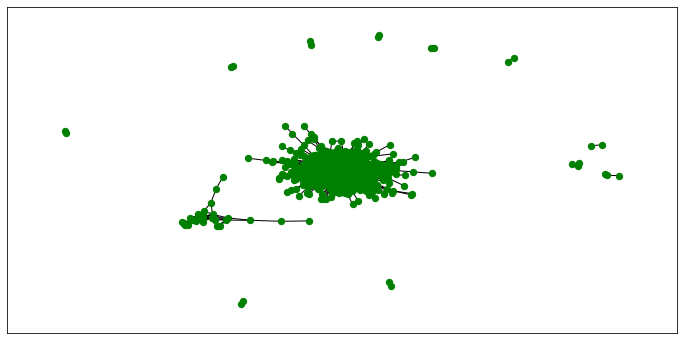

In [62]:
G1 = nx.Graph()
 
G1.add_edges_from(similar_pairs(0.14,abstracts_random))
 
nx.draw_networkx(G1,node_size=40, with_labels = False, node_color ='green')

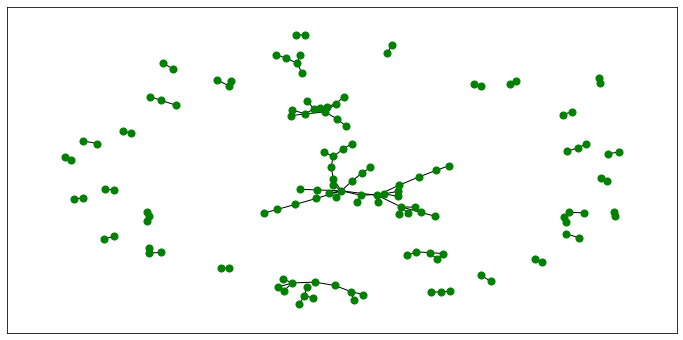

In [61]:
G2 = nx.Graph()
 
G2.add_edges_from(similar_pairs(0.17,abstracts_random))
 
nx.draw_networkx(G2,node_size=50, with_labels = False, node_color ='green')


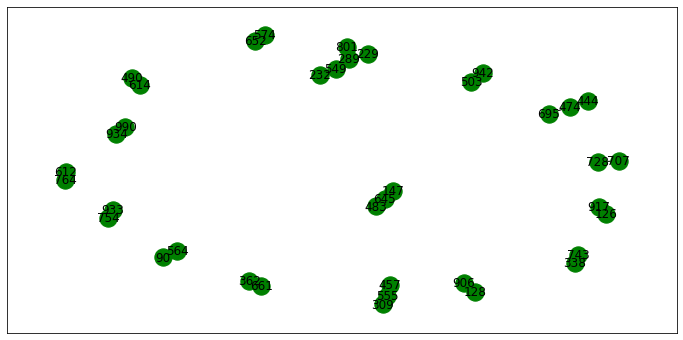

In [63]:
G3 = nx.Graph()
 
G3.add_edges_from(similar_pairs(0.19,abstracts_random))
 
nx.draw_networkx(G3, with_labels = True, node_color ='green')

2. From the basket list of authors/editors, using A-Priori or PCY, create a weighted network, using the support threshold as weight.

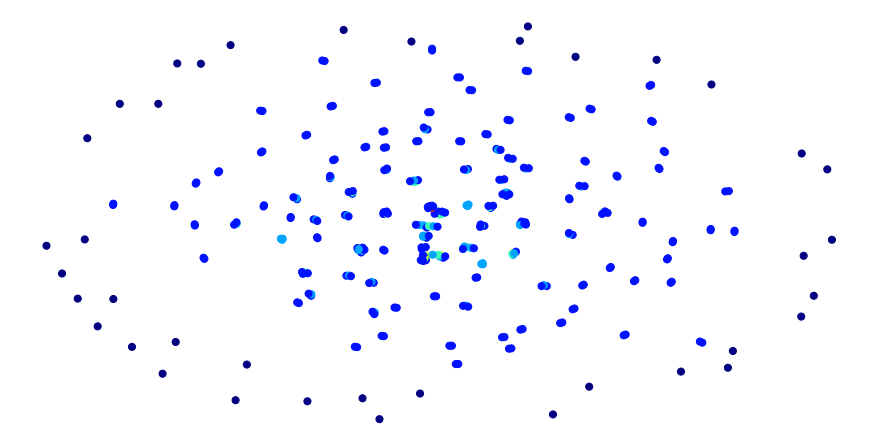

In [76]:
w1 = 21    # threshold's weight 
G4 = nx.Graph()
for n1,n2,w in data:
    G4.add_node(n1)
    G4.add_node(n2)
    if w.astype(int) >= w1:
        G4.add_edge(n1, n2, weight=w)
        
# show graph
node_degrees_1 = nx.degree(G4)
node_degrees = list(dict(node_degrees_1).values())
nx.draw(G4, node_size=50, edge_color="b", with_labels = False, cmap=plt.get_cmap('jet'), node_color = node_degrees)


3. Find the communities for the networks obtained in 1. and 2. Comment about the results with respect to the different thresholds and methods. How does it compare with the same analysis using 1-NN done in previous tasks?

In [19]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

#### Communities based on pairs of abstracts

#### G1

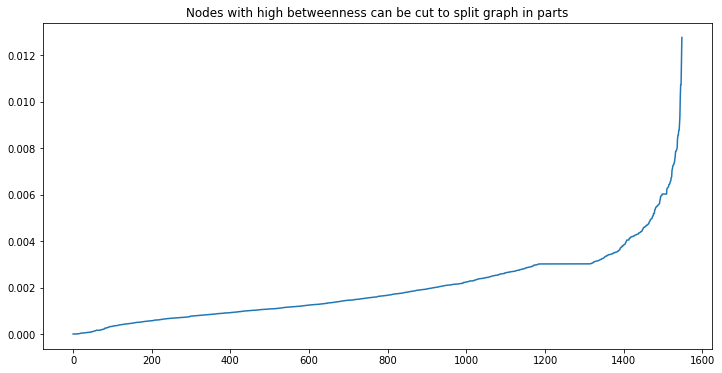

In [64]:
# print betweenness
bt = list(nx.edge_betweenness(G1).values())
plt.plot(range(len(bt)), sorted(bt))
plt.title("Nodes with high betweenness can be cut to split graph in parts")
#plt.ylim([0, 0.02])
plt.show()

In [66]:
# remove edges with betweenness larger than threshold
thr = 0.003 # around 70% of the max value
while True:
    bt = nx.edge_betweenness(G1)
    
    i = np.argmax(list(bt.values()))
    if list(bt.values())[i] < thr:
        break
    n1, n2 = list(bt.keys())[i]
    G1.remove_edge(n1, n2)

# clean graph from single-node components for easy printing
for n, d in list(nx.degree(G1)):
    if d == 0:
        G1.remove_node(n)

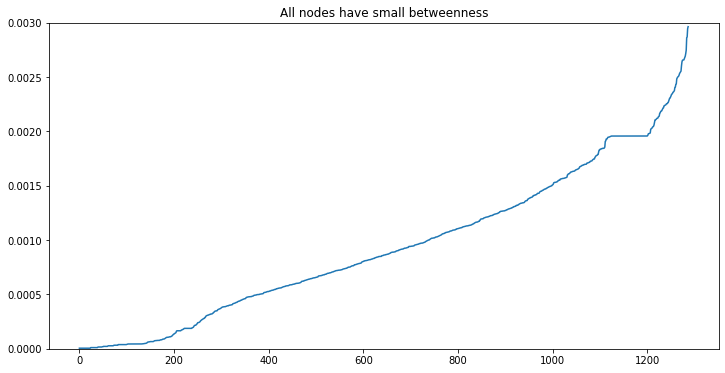

In [67]:
# print new betweenness
bt = nx.edge_betweenness(G1).values()
plt.plot(range(len(bt)), sorted(bt))
plt.title("All nodes have small betweenness")
plt.ylim([0, 0.003])
plt.show()

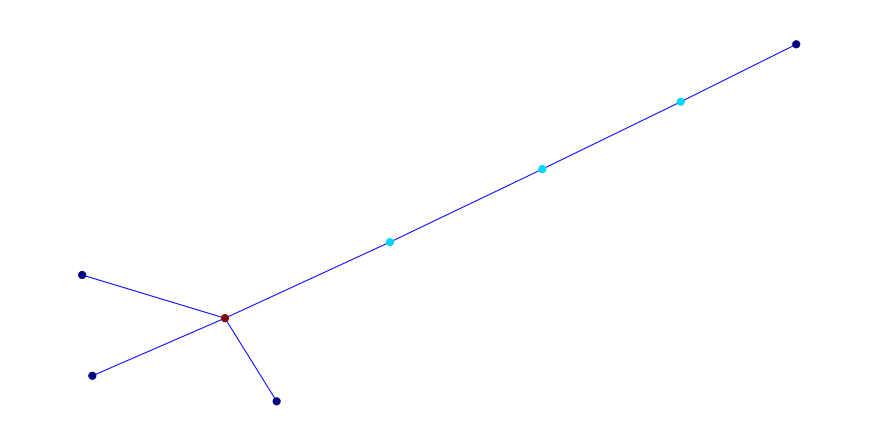

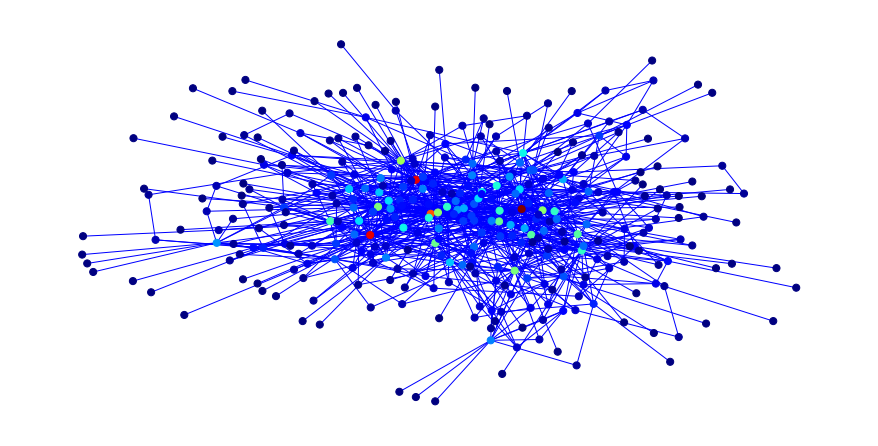

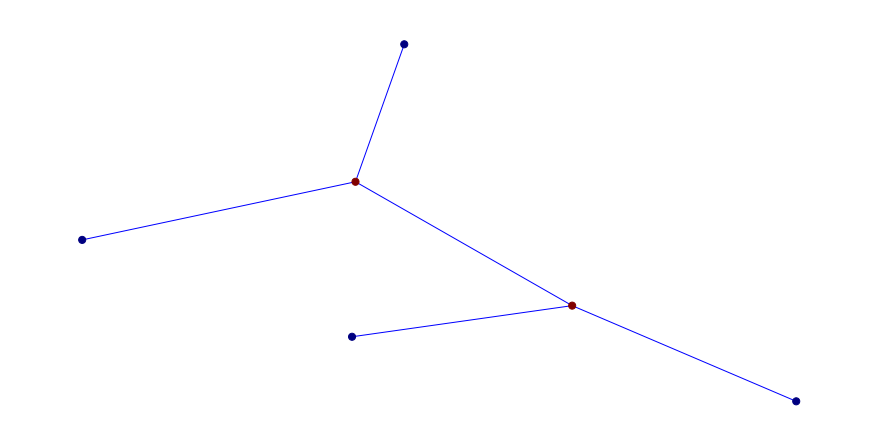

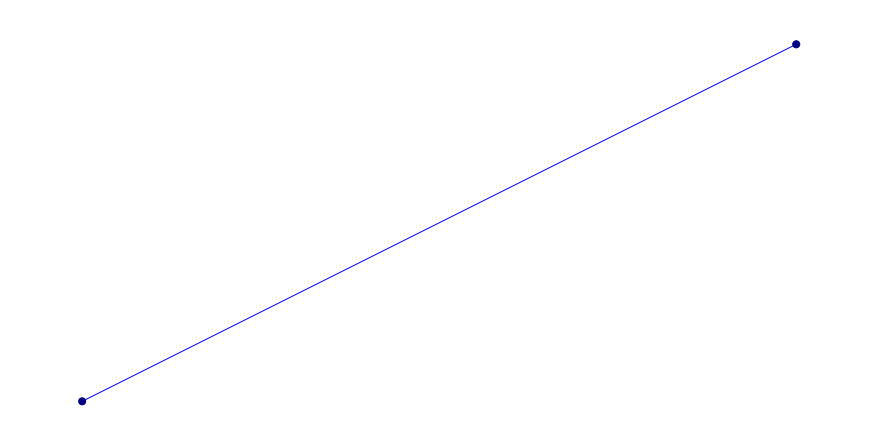

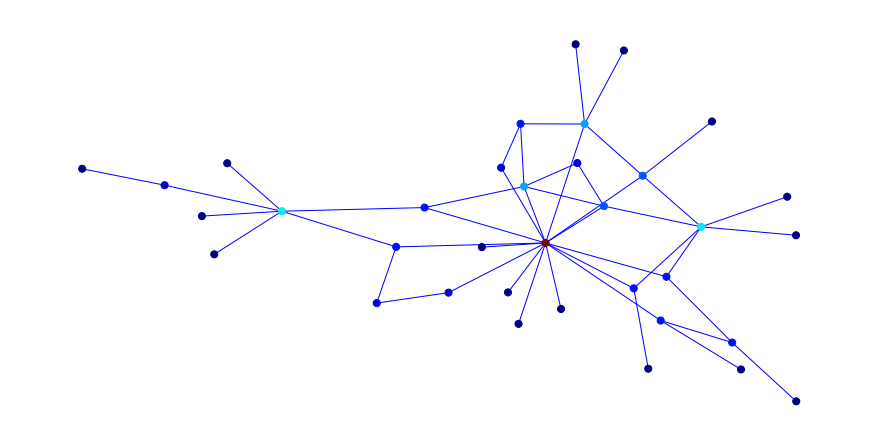

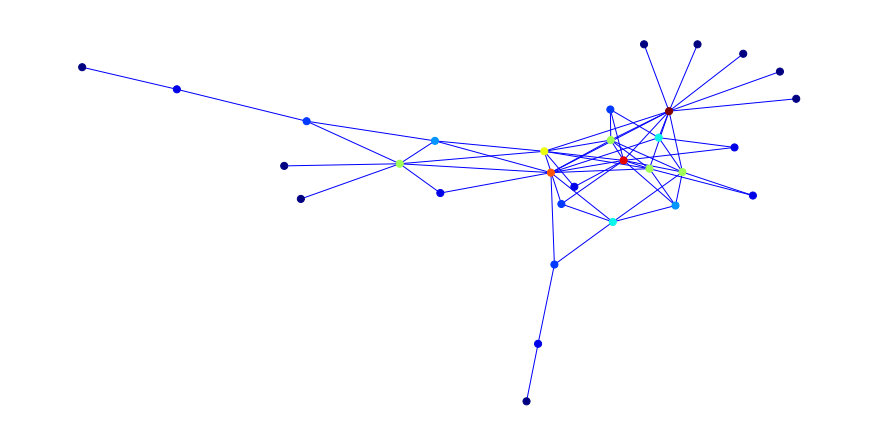

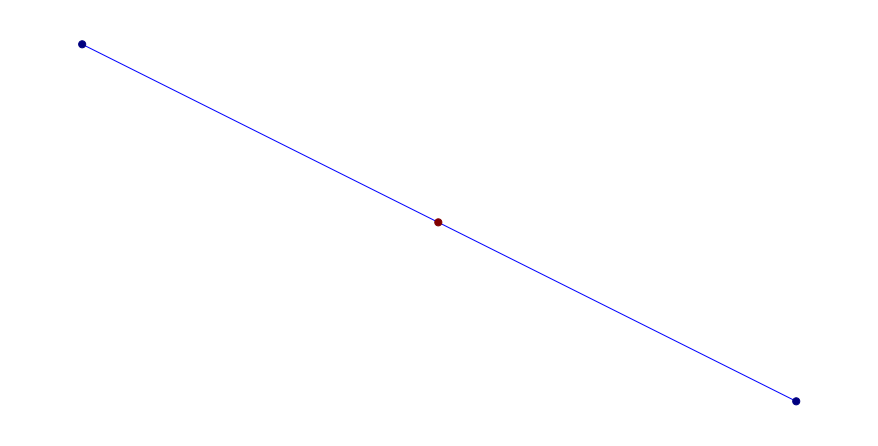

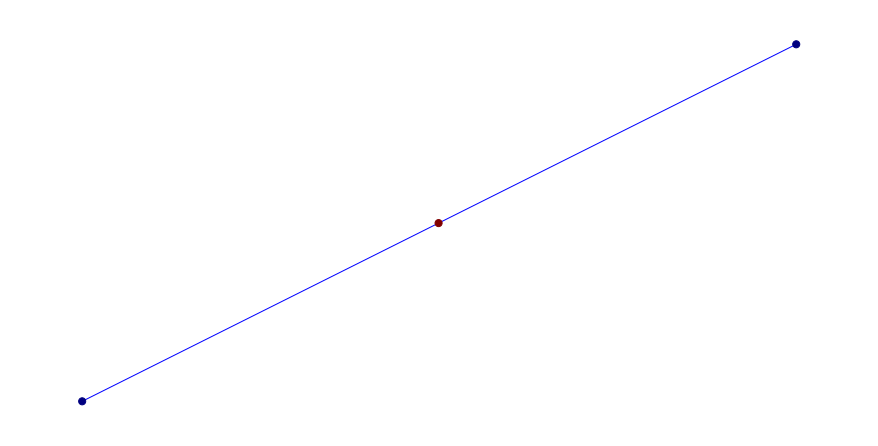

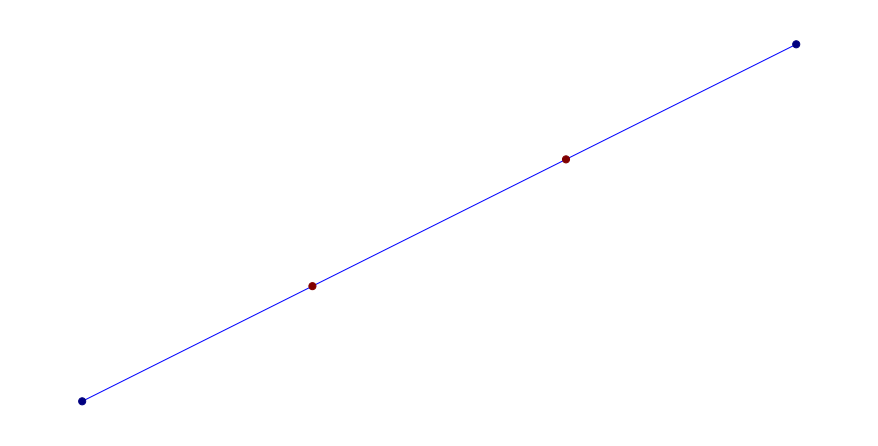

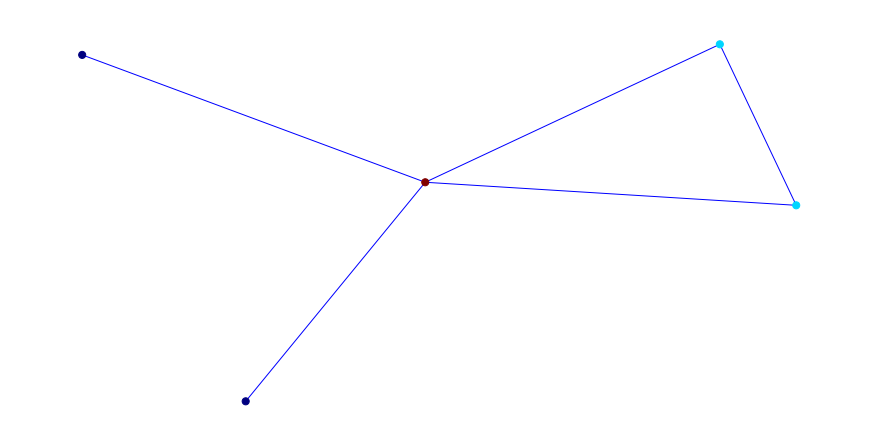

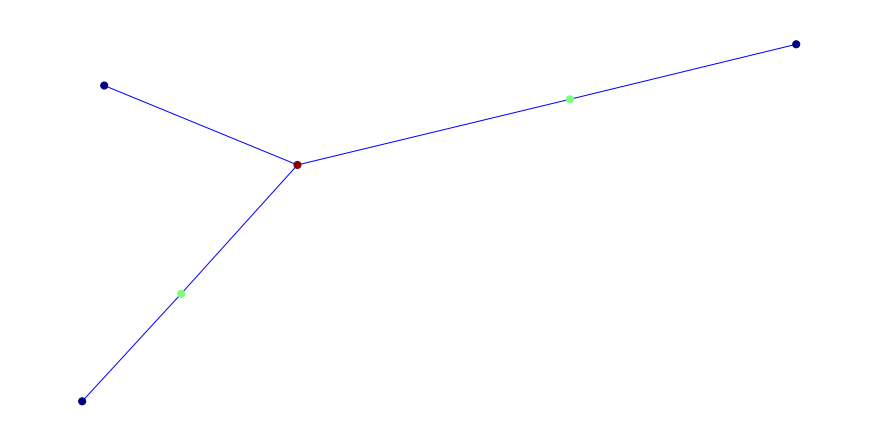

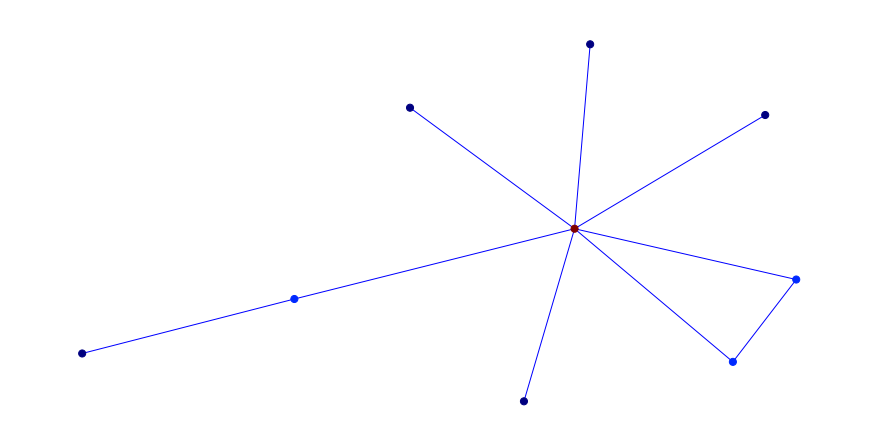

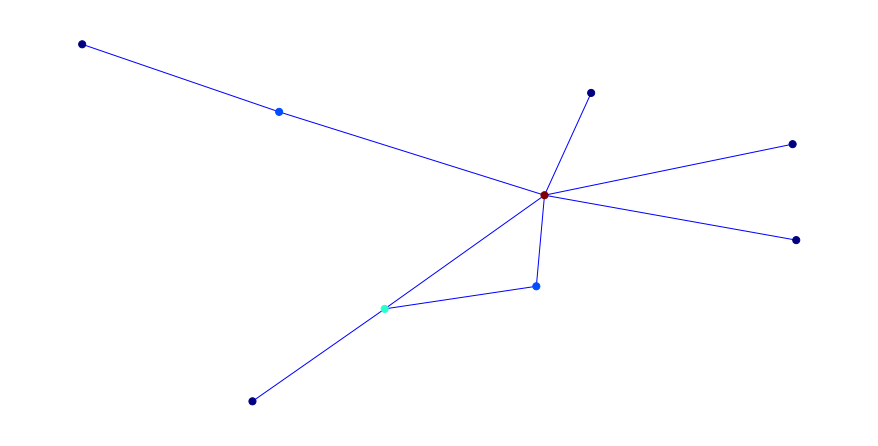

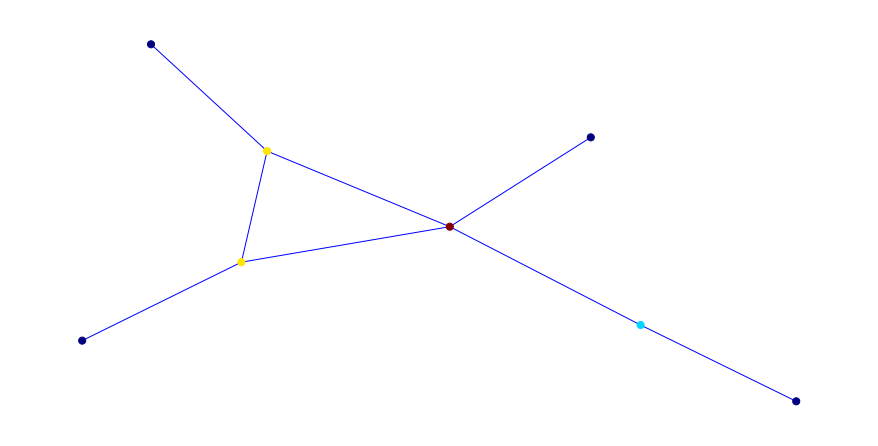

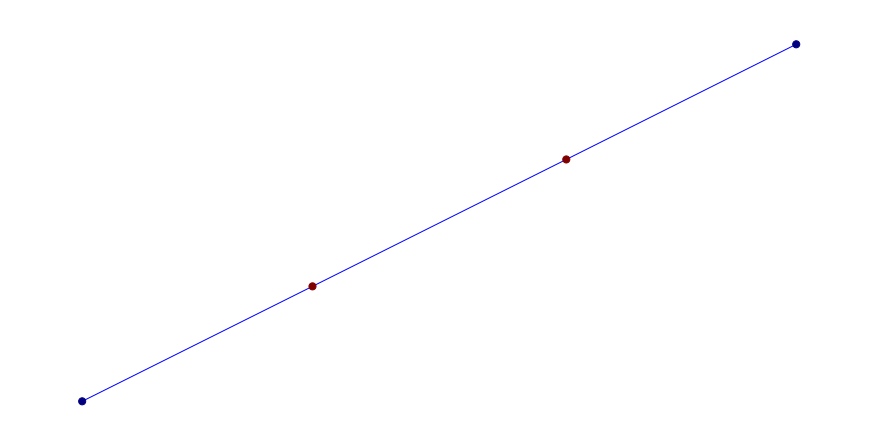

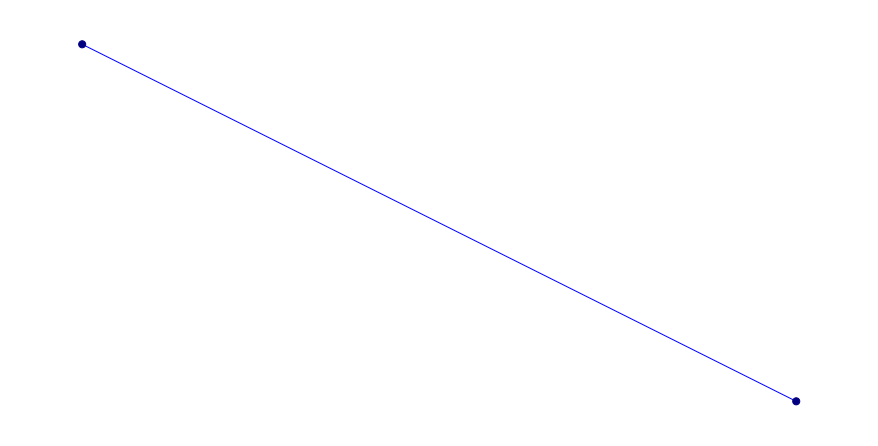

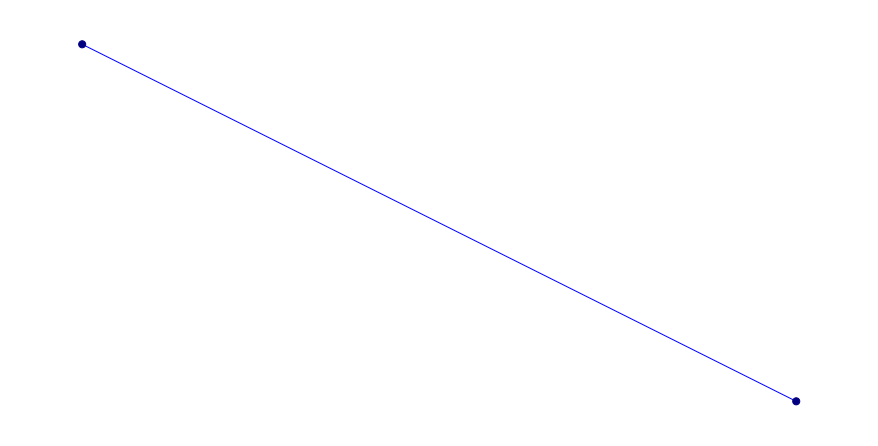

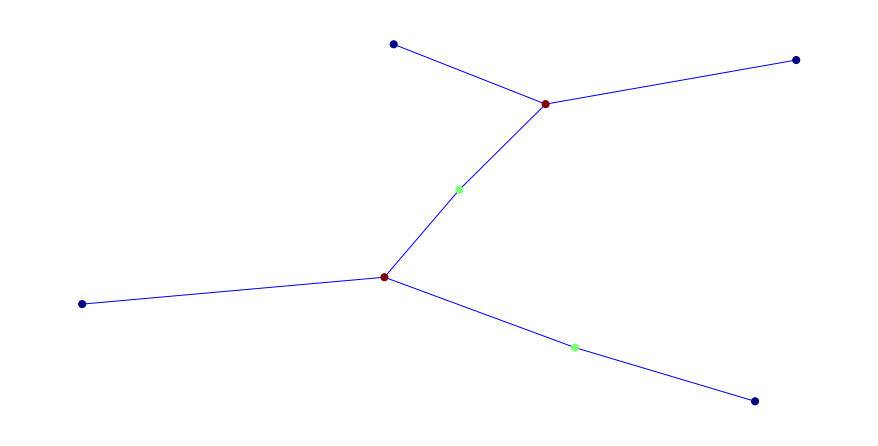

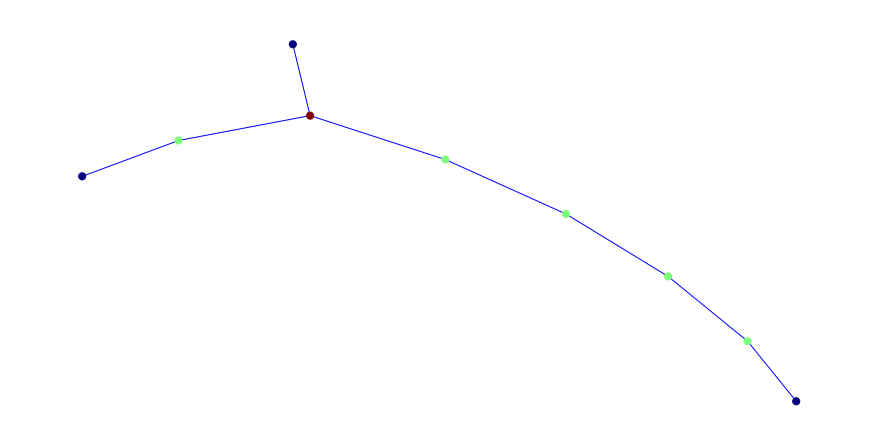

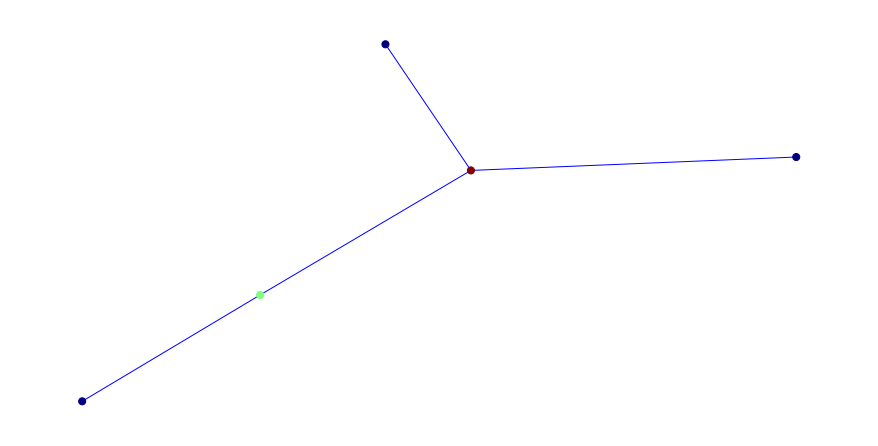

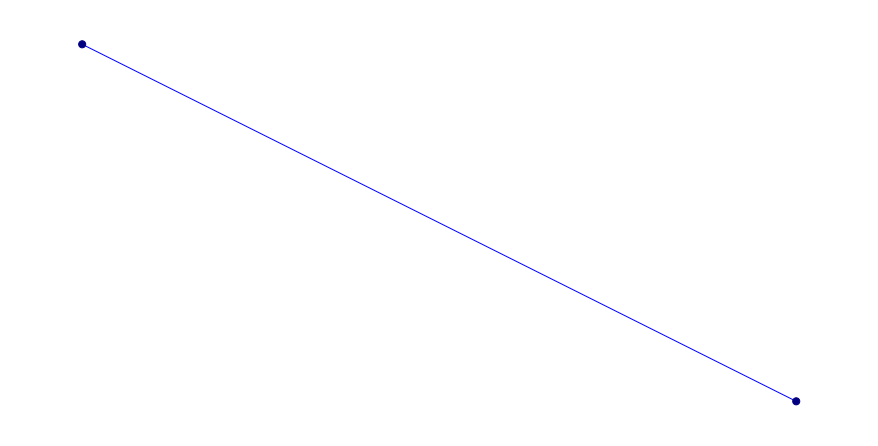

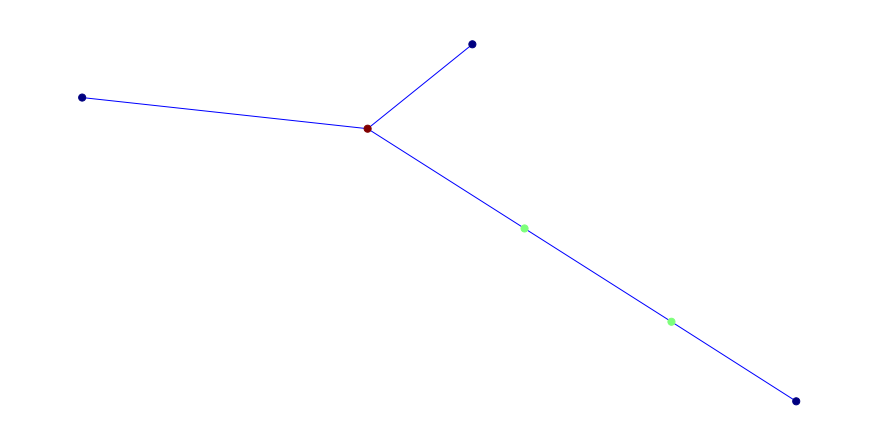

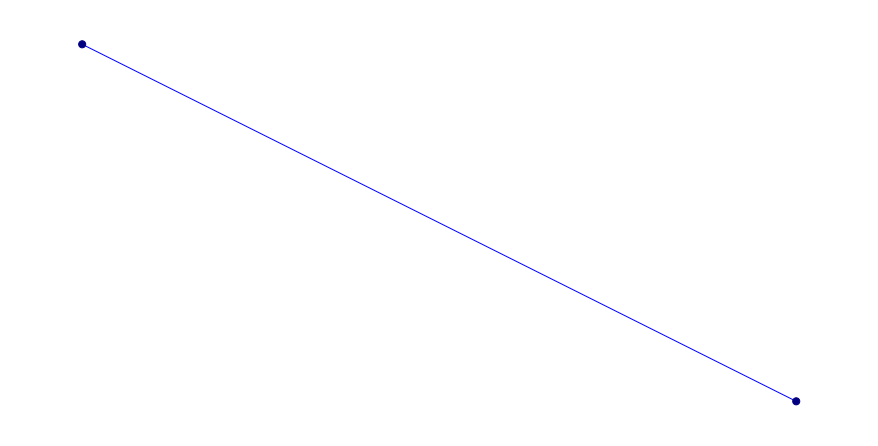

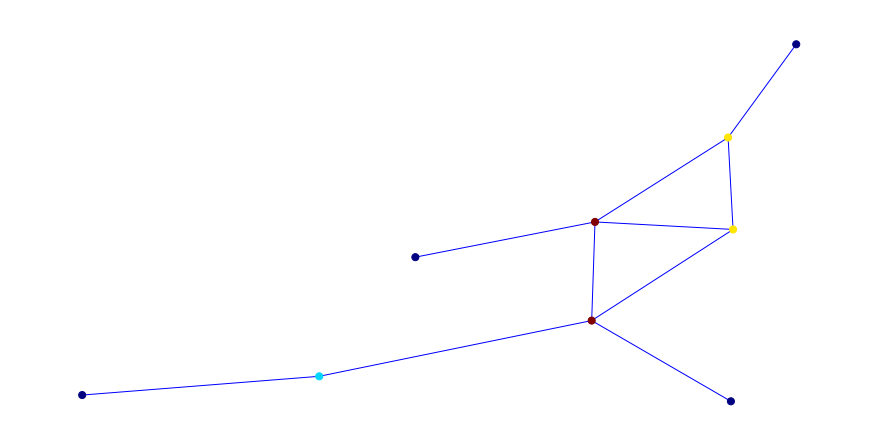

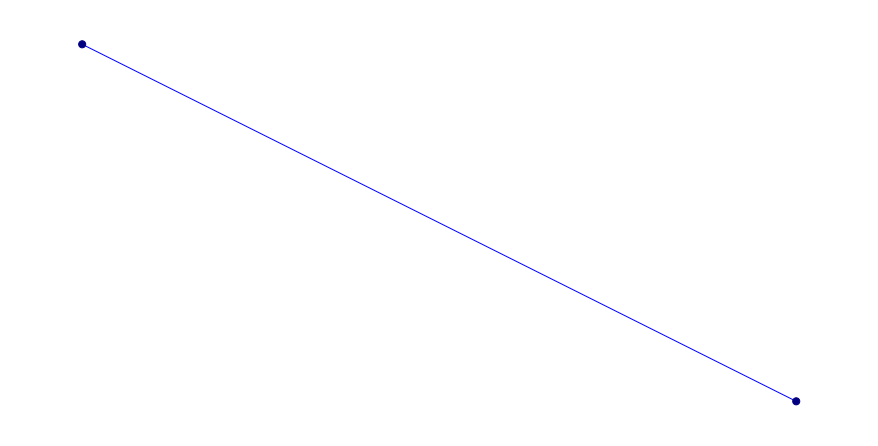

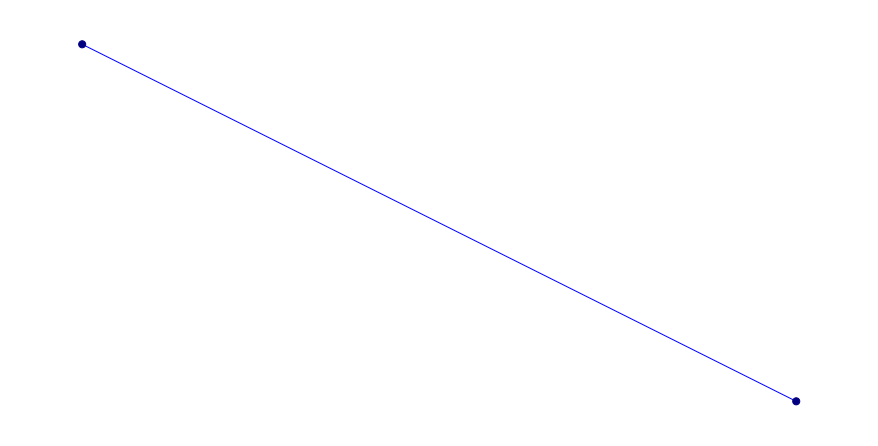

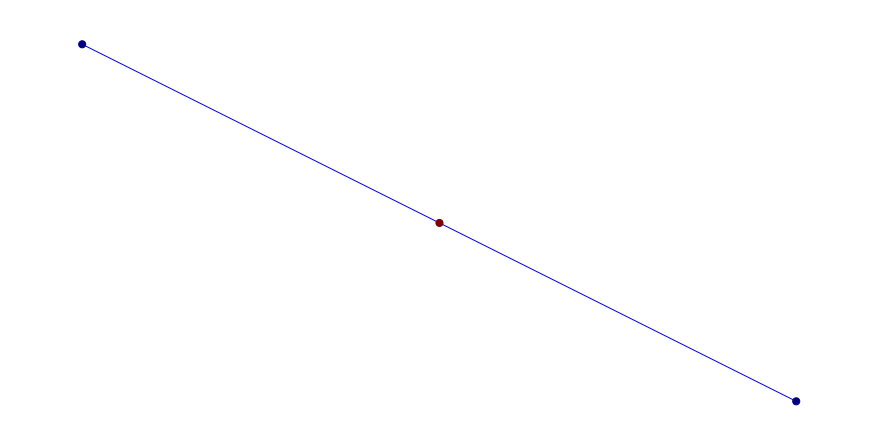

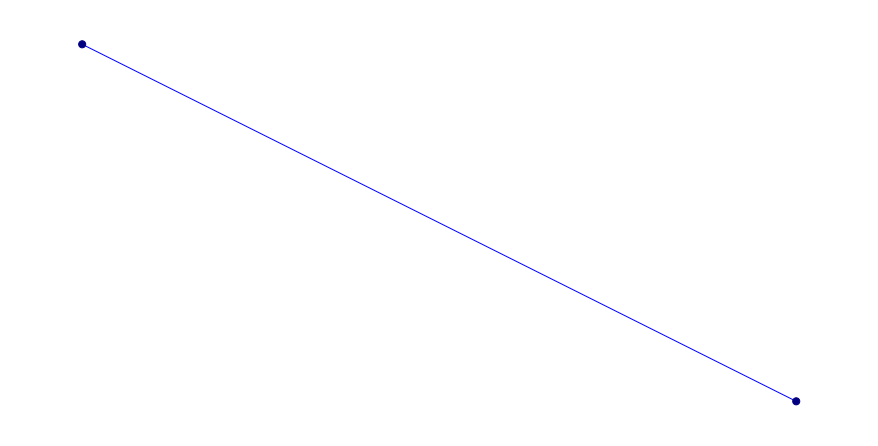

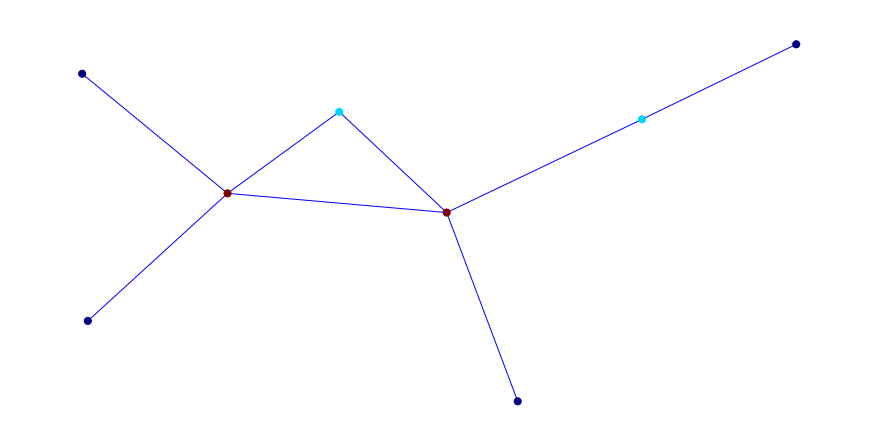

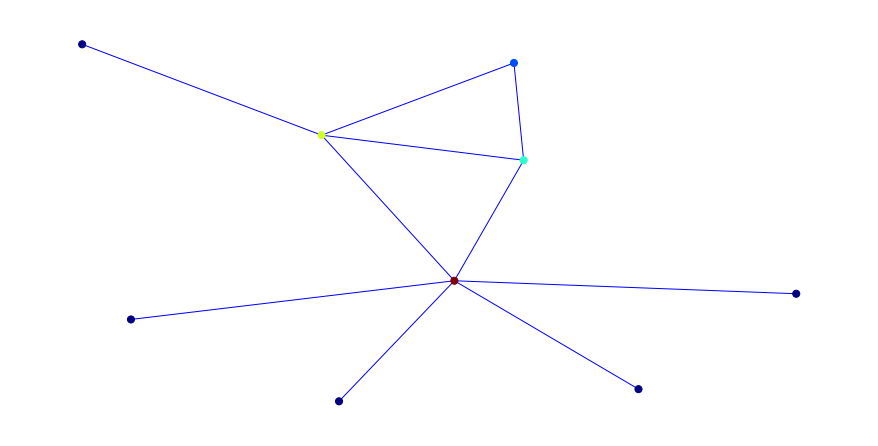

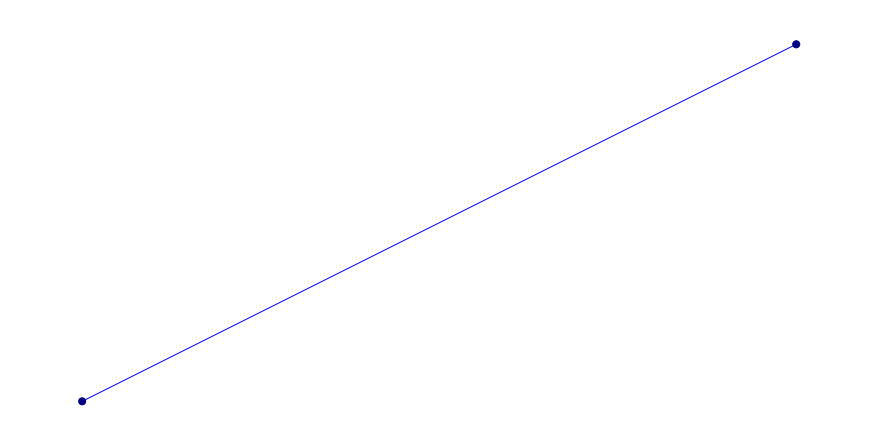

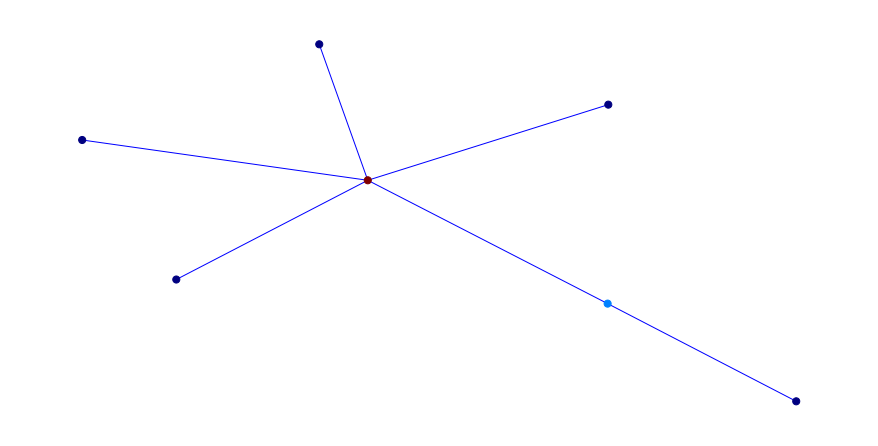

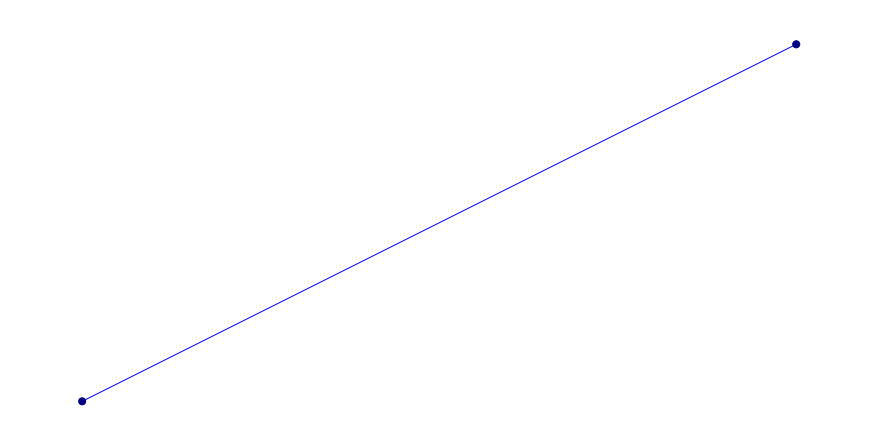

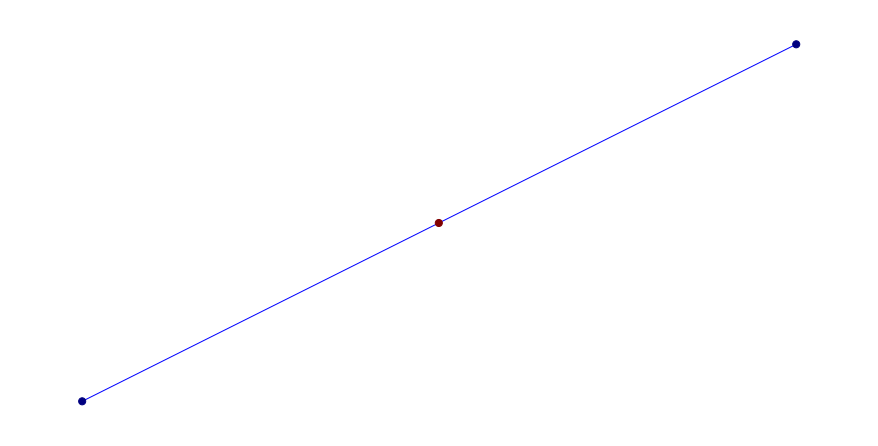

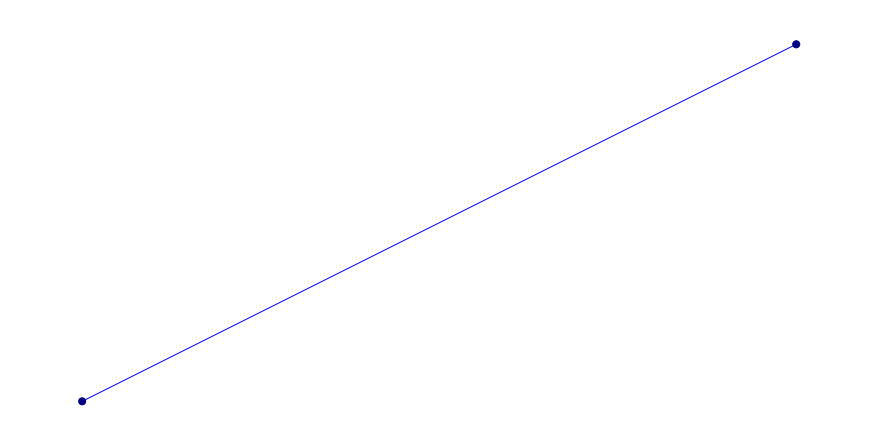

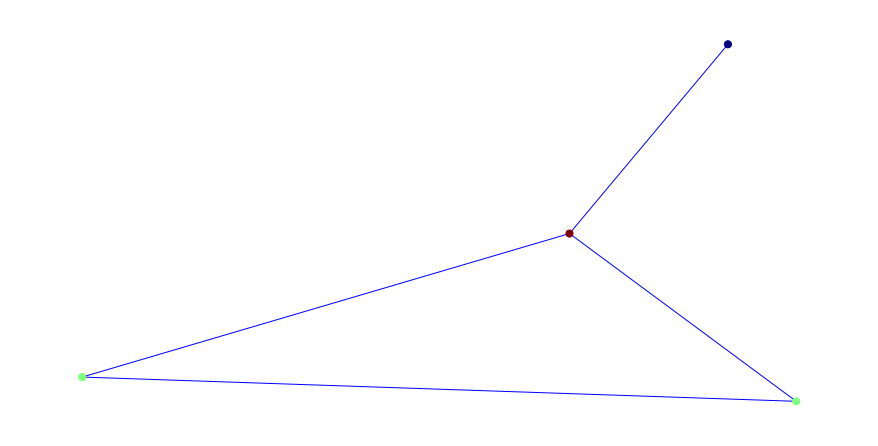

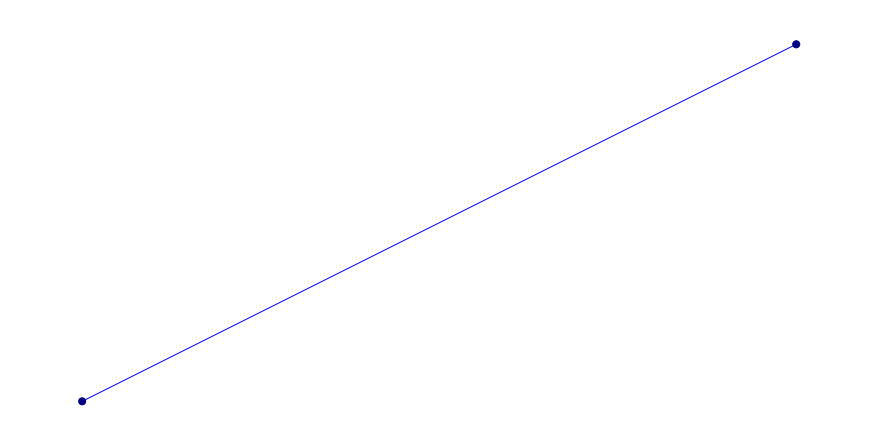

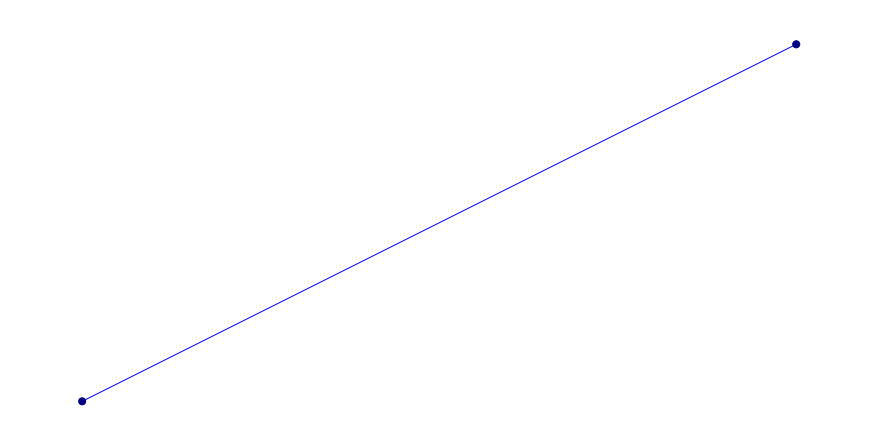

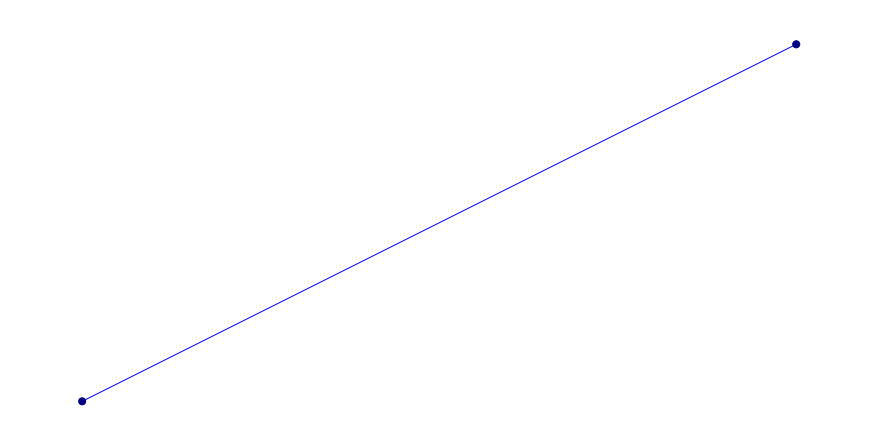

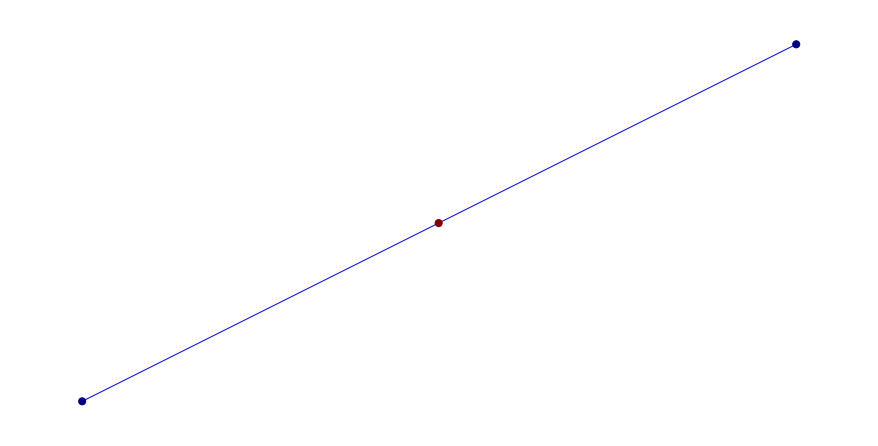

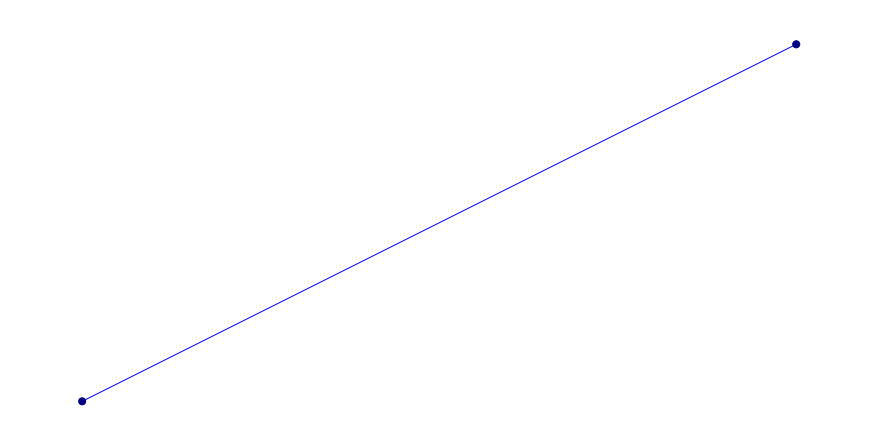

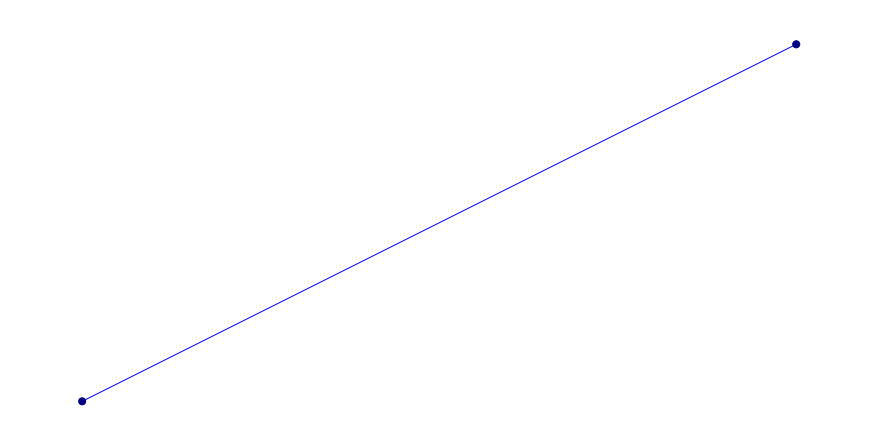

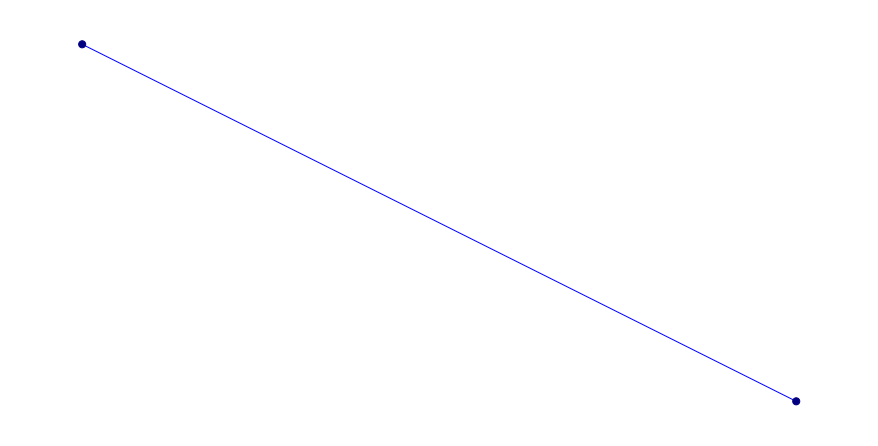

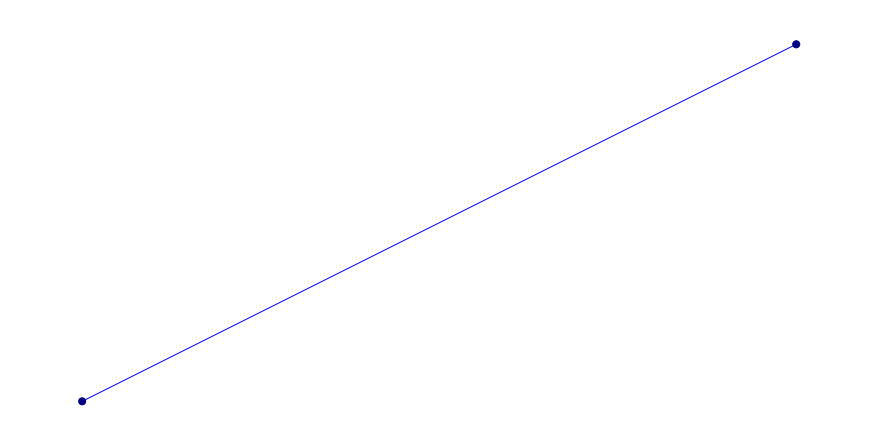

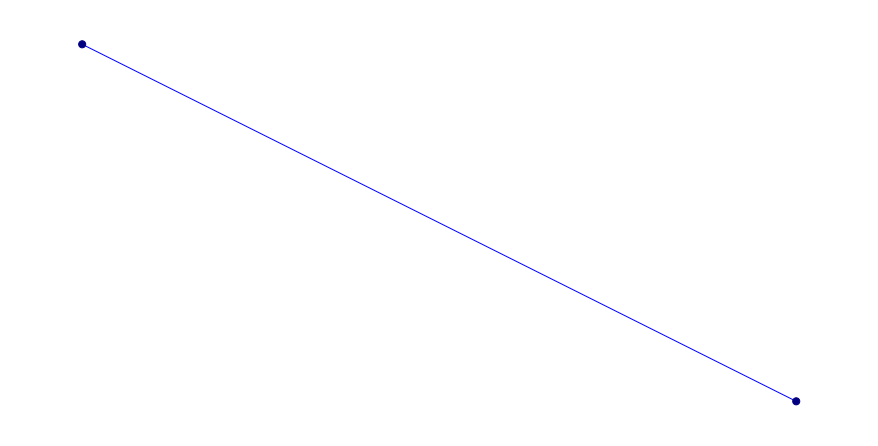

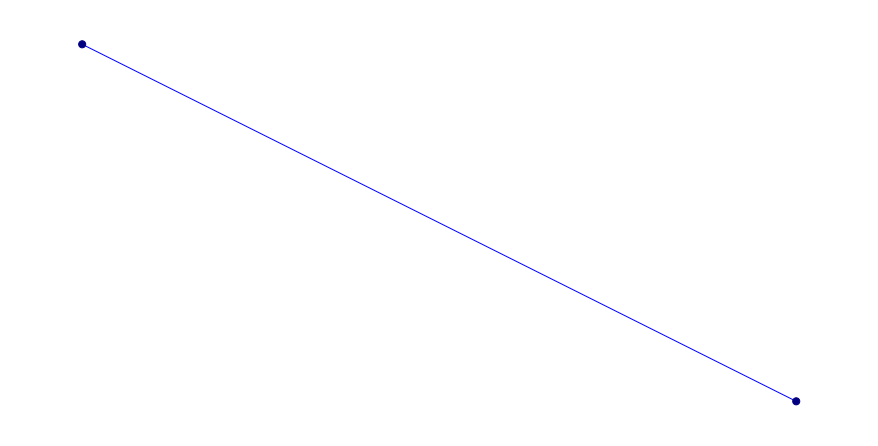

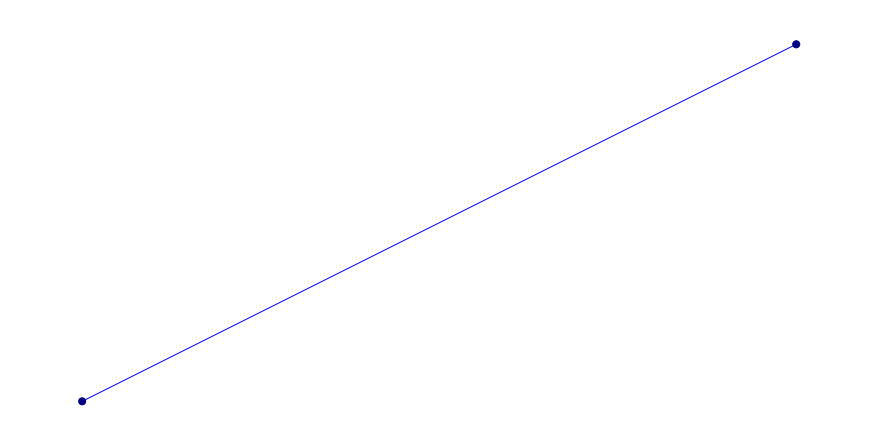

In [68]:
# print found components
#for G1 in nx.connected_component_subgraphs(G):  # for nx < 2.4 version
for G1 in connected_component_subgraphs(G1): # for nx >= 2.4 version
    node_degrees = list(dict(nx.degree(G1)).values())
    nx.draw(G1, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees)
    plt.show()

#### G2

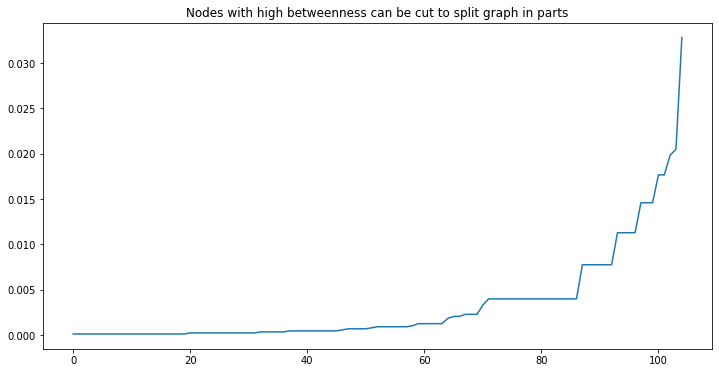

In [69]:
# print betweenness
bt = list(nx.edge_betweenness(G2).values())
plt.plot(range(len(bt)), sorted(bt))
plt.title("Nodes with high betweenness can be cut to split graph in parts")
#plt.ylim([0, 0.02])
plt.show()

In [70]:
# remove edges with betweenness larger than threshold
thr = 0.005 # around 70% of the max value
while True:
    bt = nx.edge_betweenness(G2)
    
    i = np.argmax(list(bt.values()))
    if list(bt.values())[i] < thr:
        break
    n1, n2 = list(bt.keys())[i]
    G2.remove_edge(n1, n2)

# clean graph from single-node components for easy printing
for n, d in list(nx.degree(G2)):
    if d == 0:
        G2.remove_node(n)

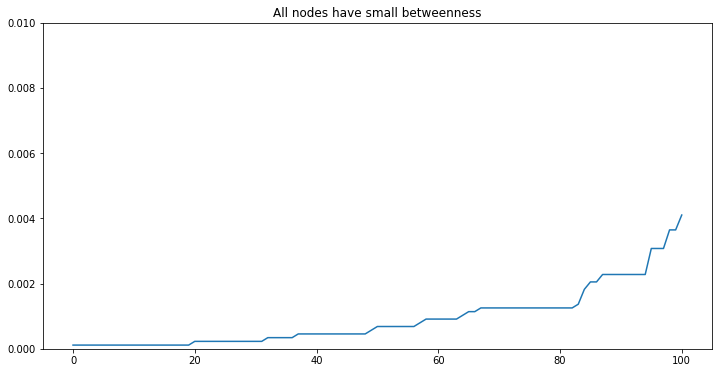

In [71]:
# print new betweenness
bt = nx.edge_betweenness(G2).values()
plt.plot(range(len(bt)), sorted(bt))
plt.title("All nodes have small betweenness")
plt.ylim([0, 0.01])
plt.show()

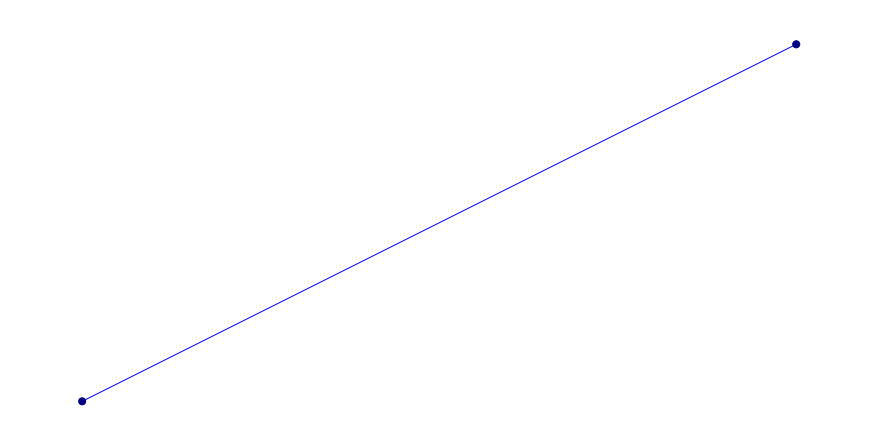

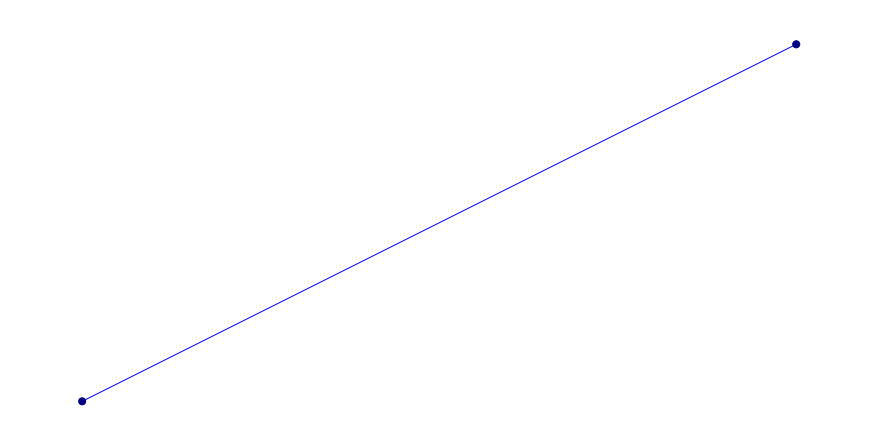

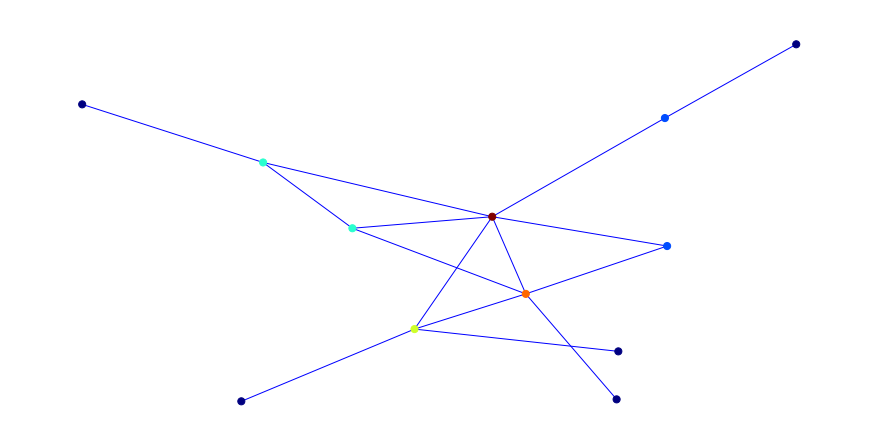

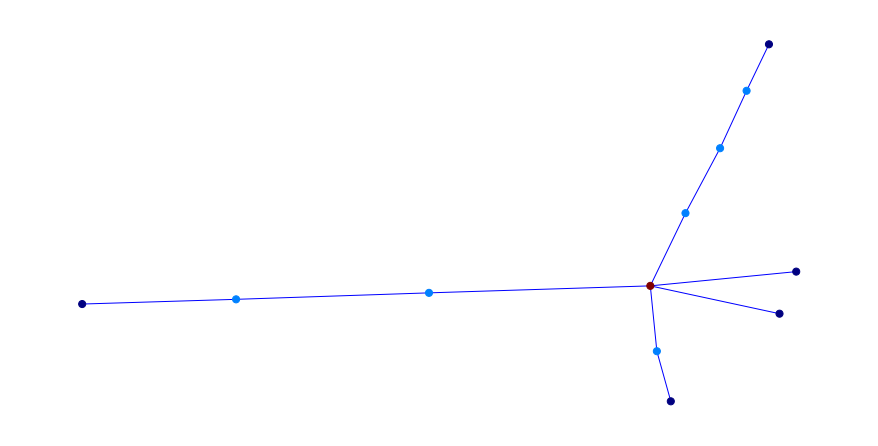

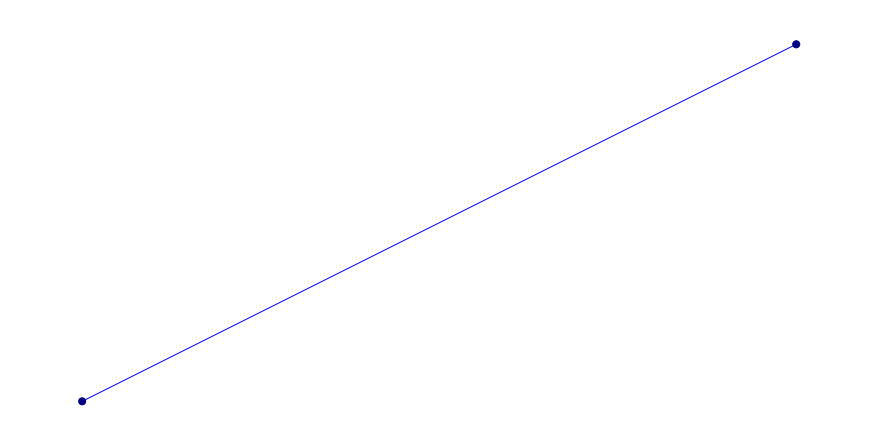

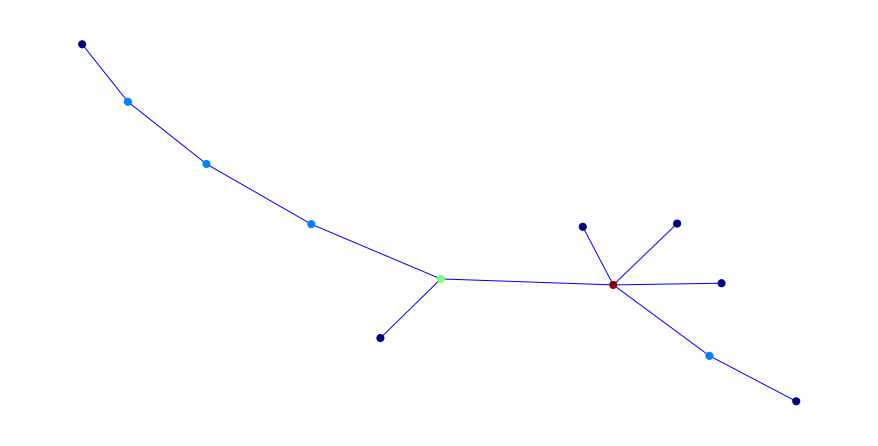

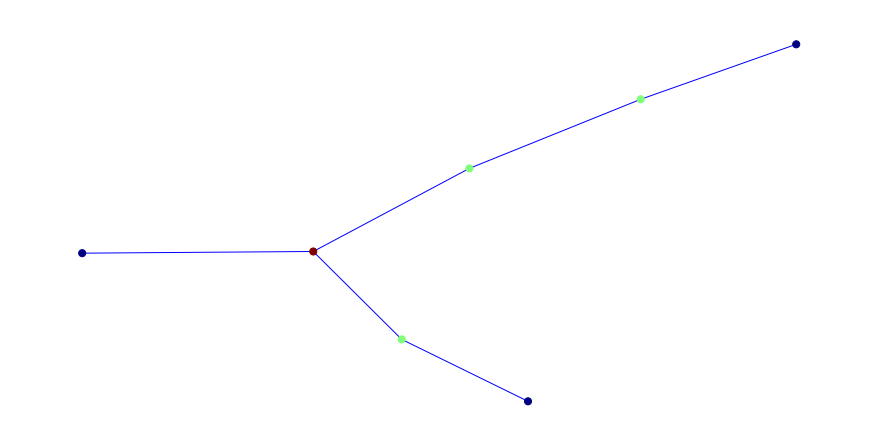

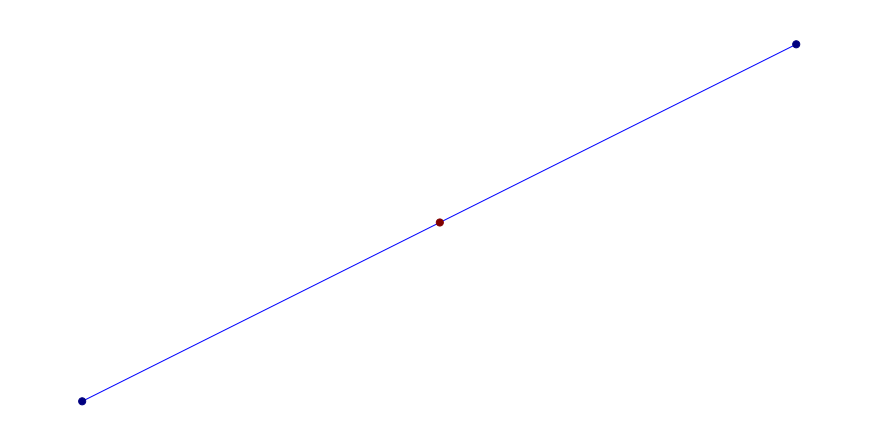

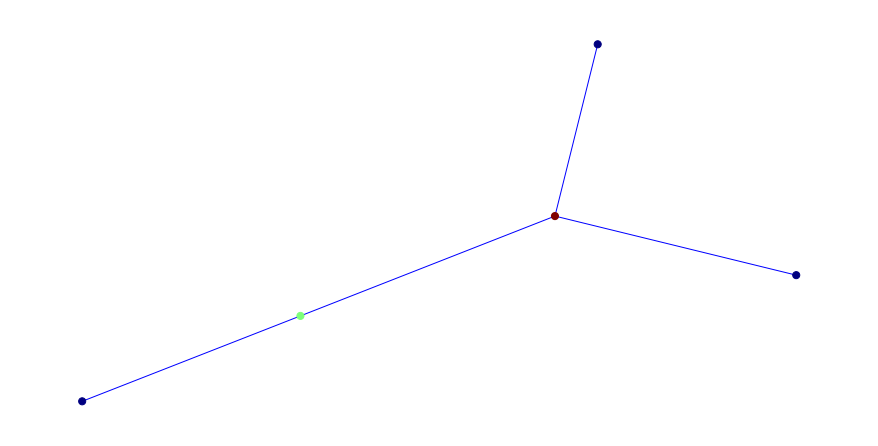

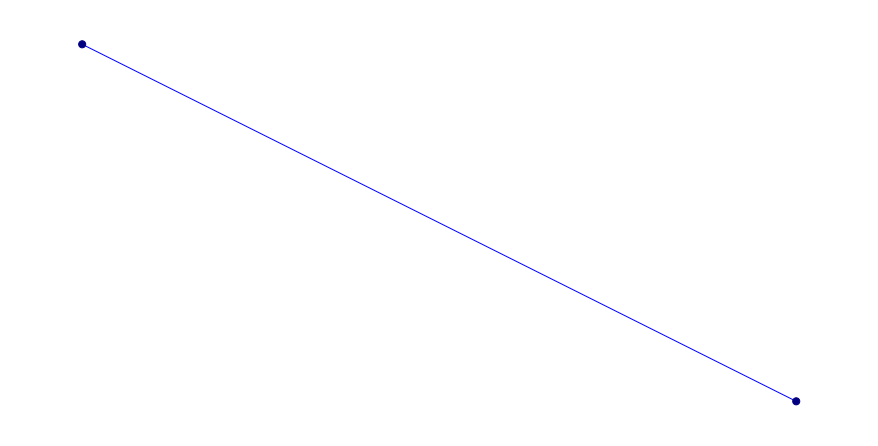

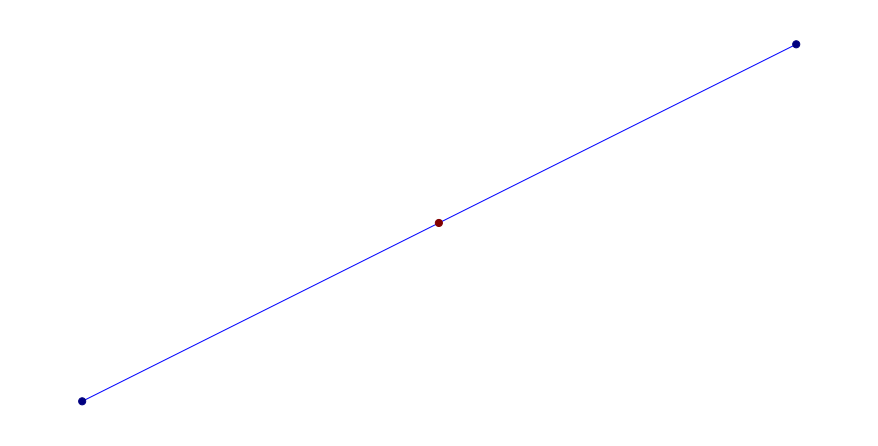

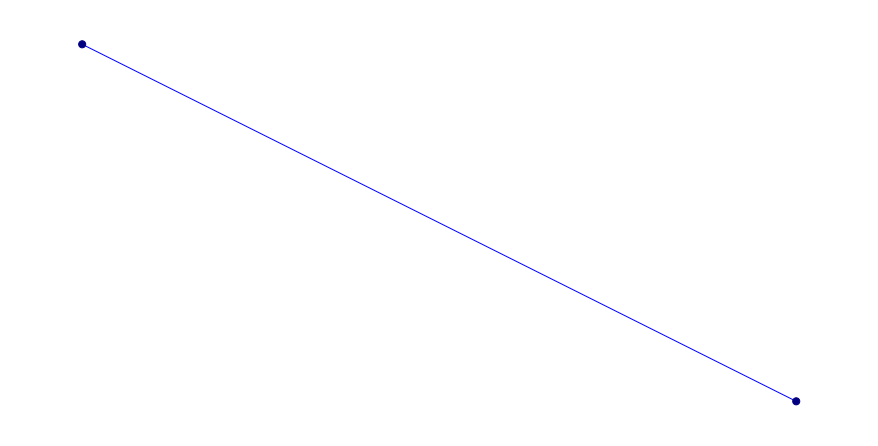

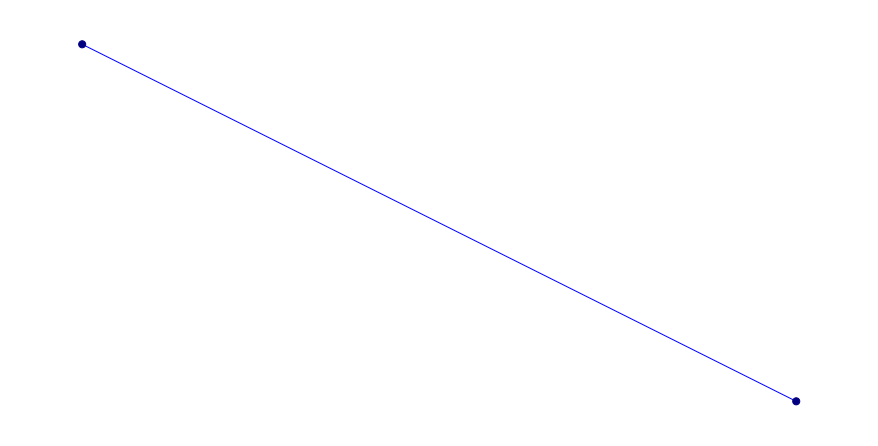

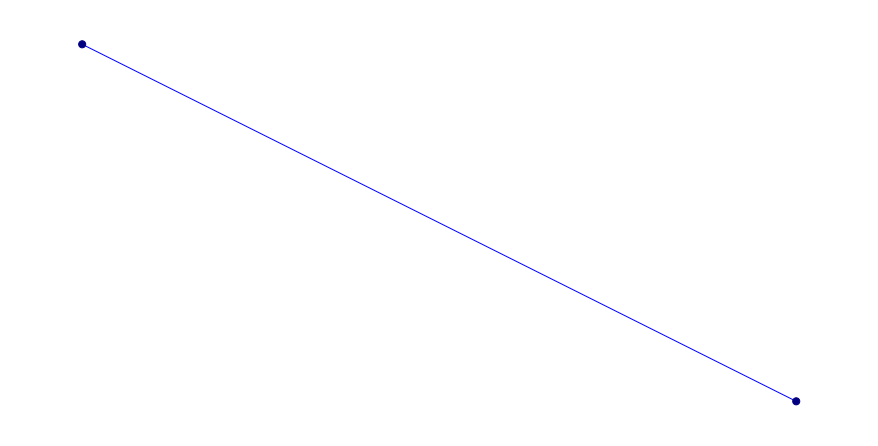

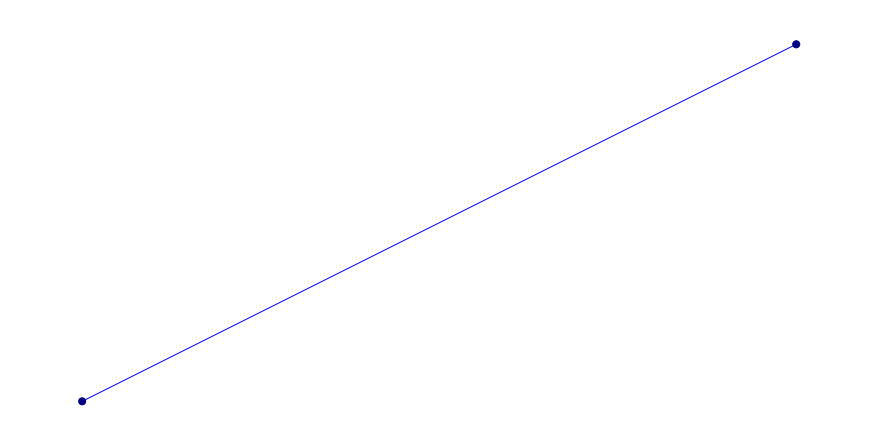

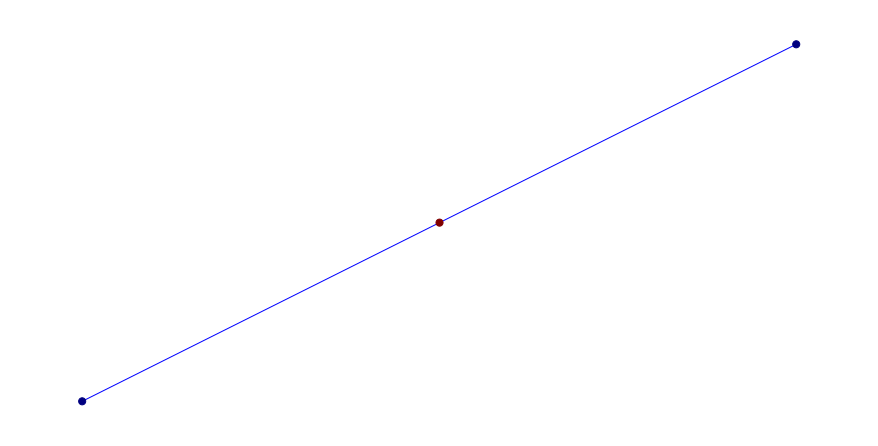

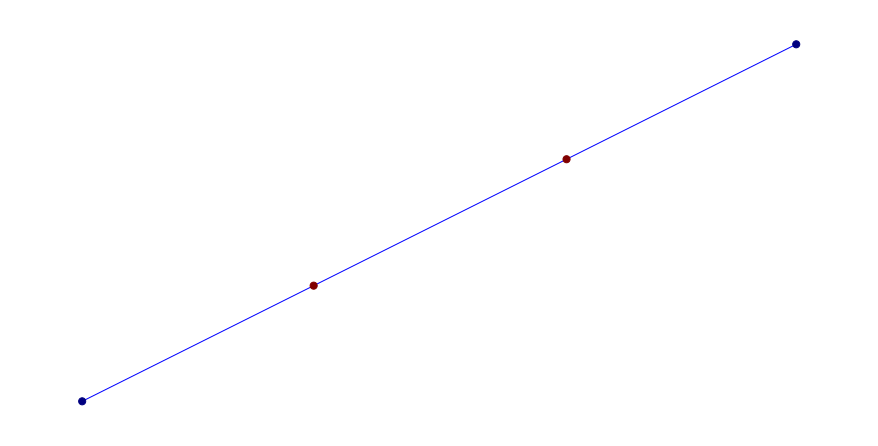

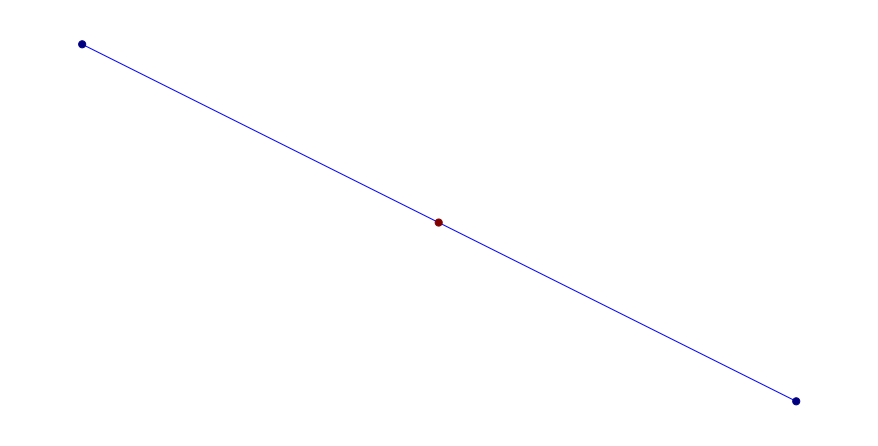

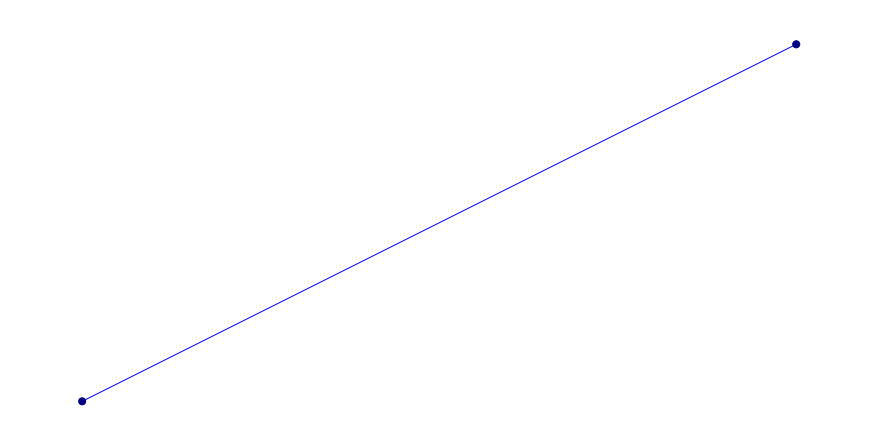

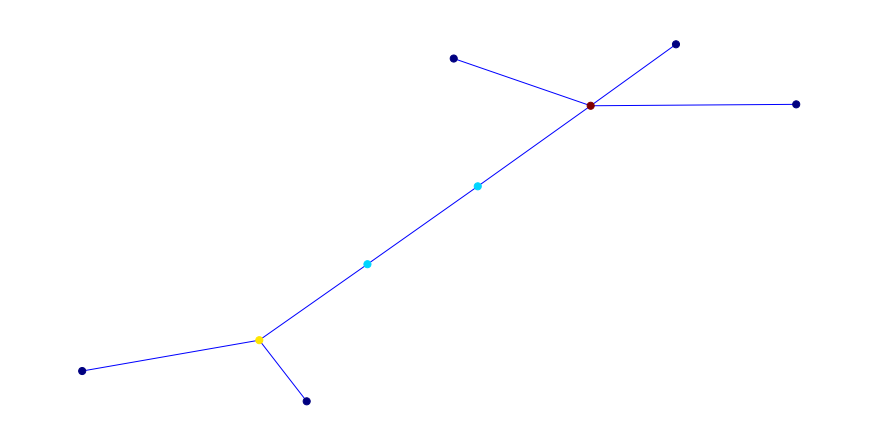

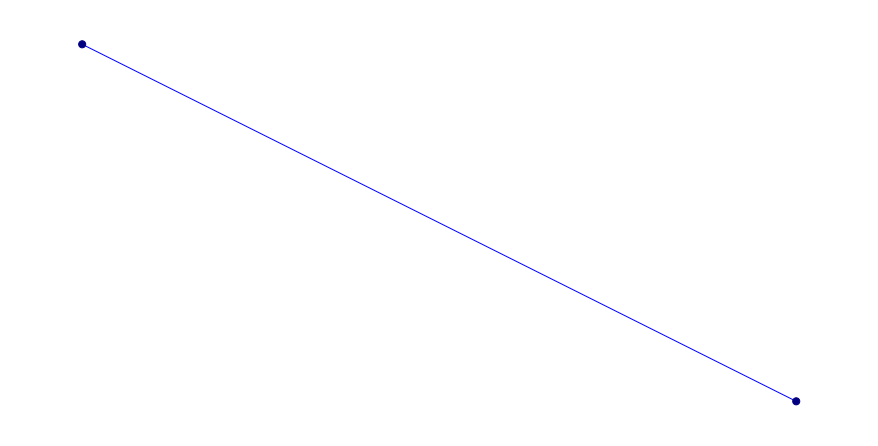

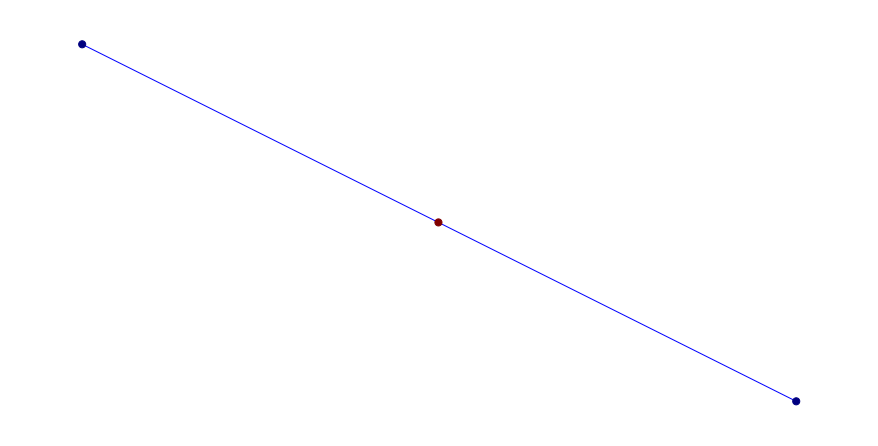

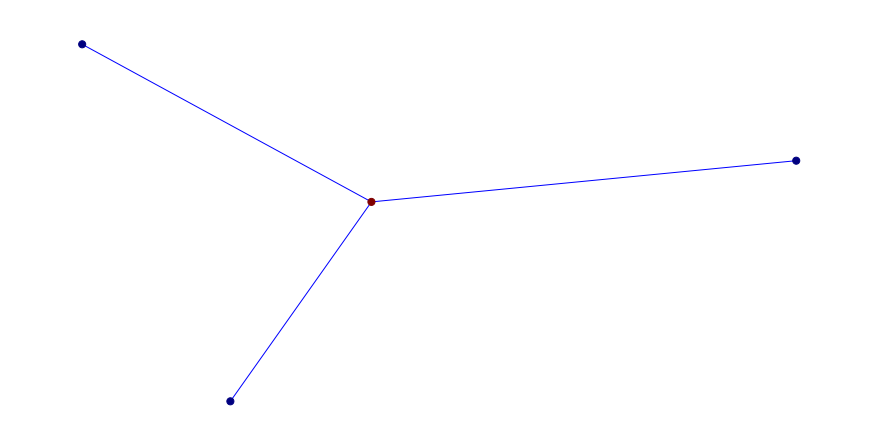

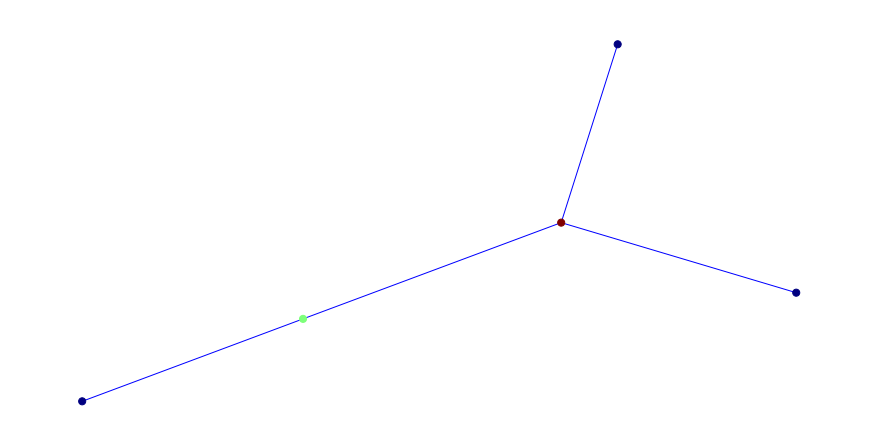

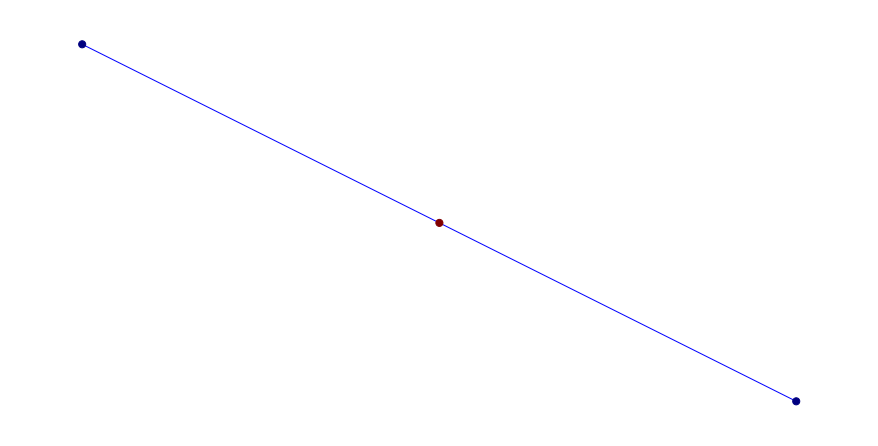

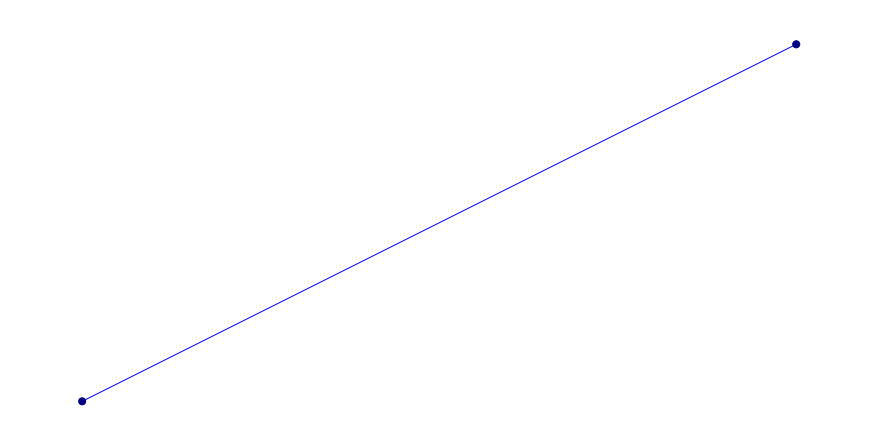

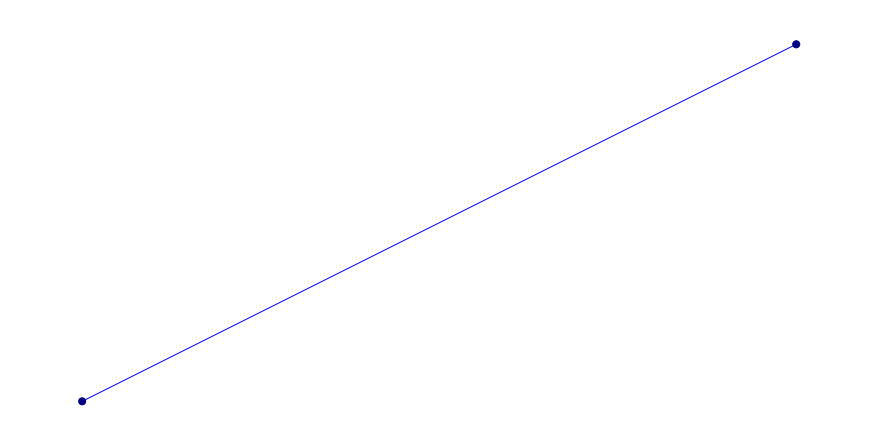

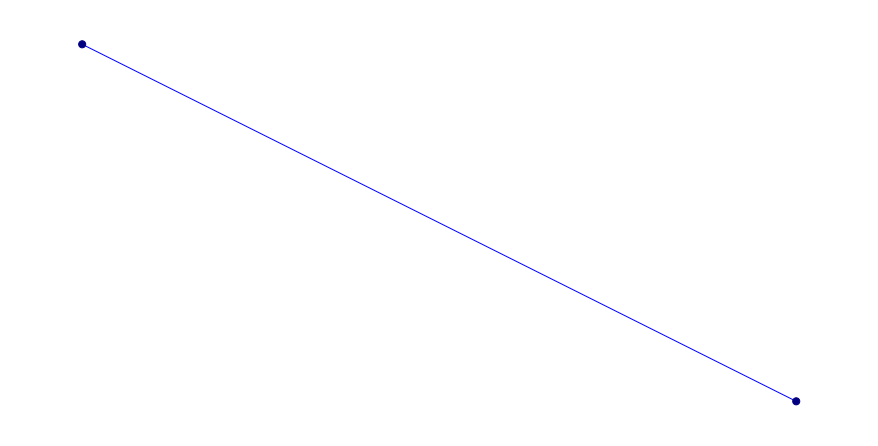

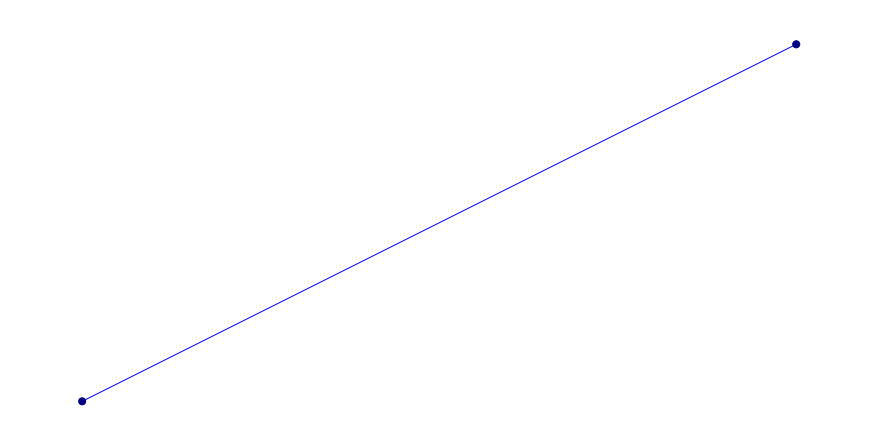

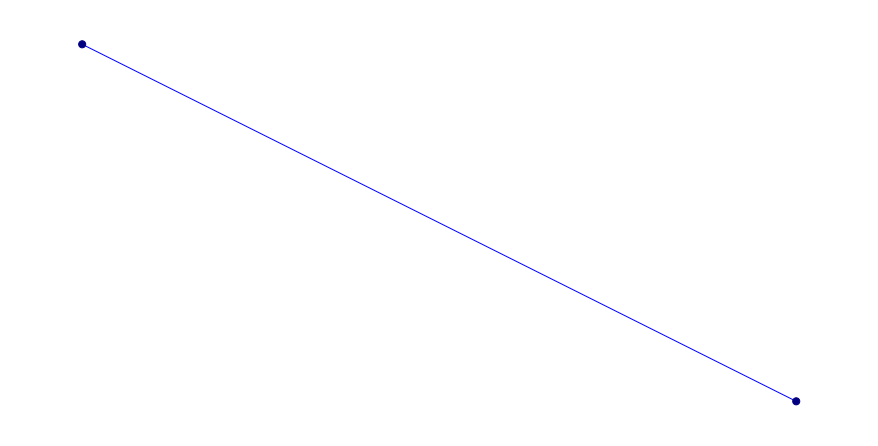

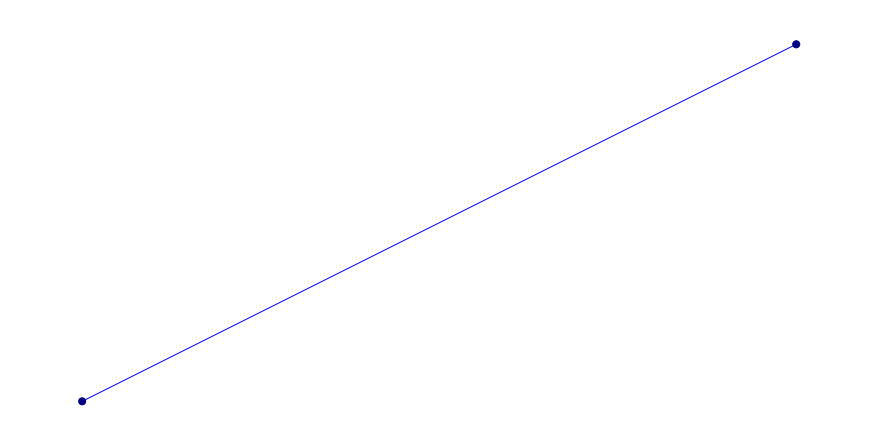

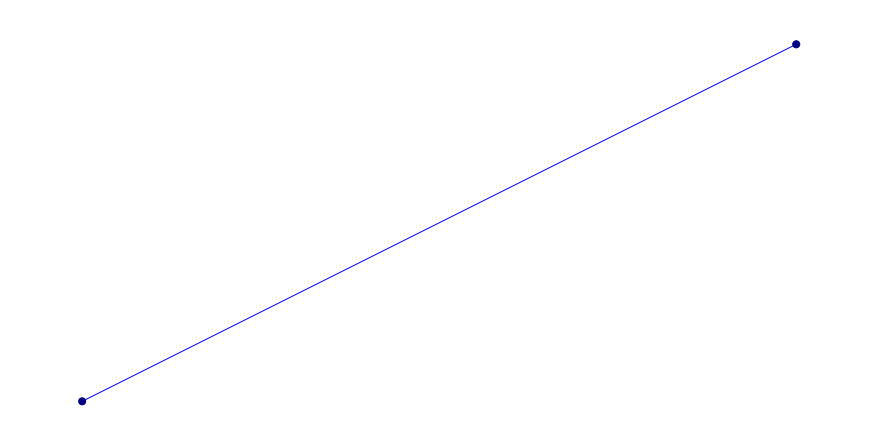

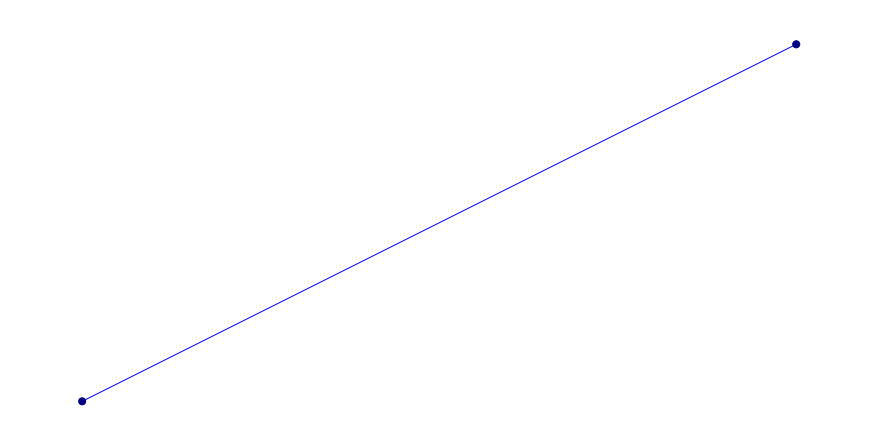

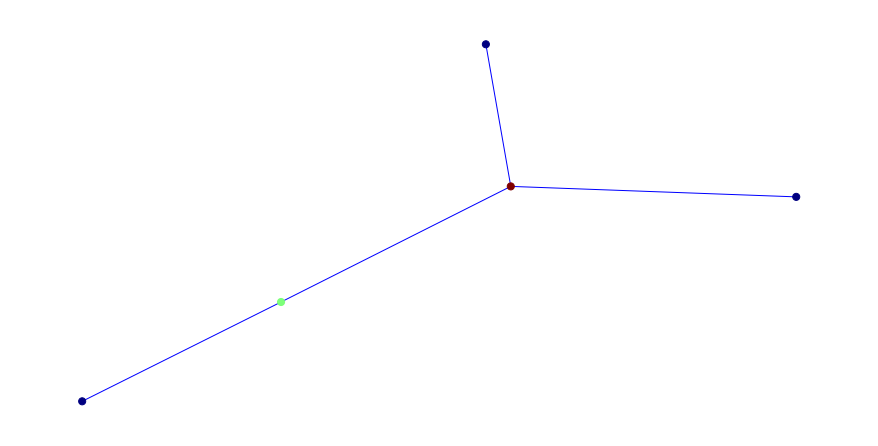

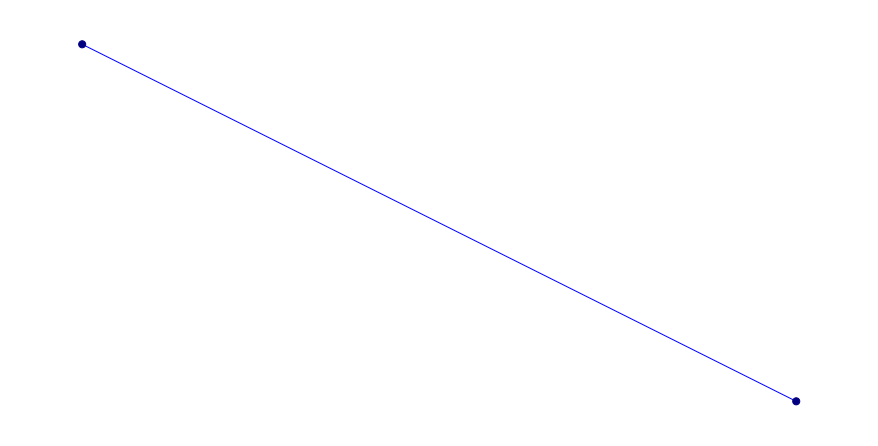

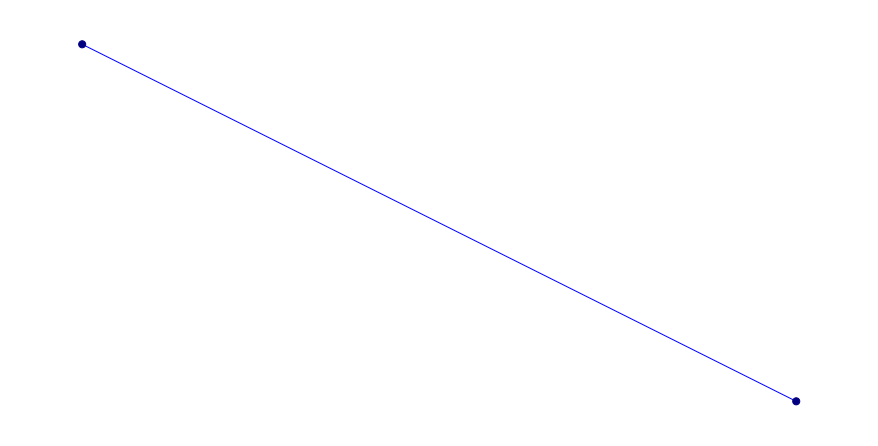

In [72]:
# print found components
#for G2 in nx.connected_component_subgraphs(G):  # for nx < 2.4 version
for G2 in connected_component_subgraphs(G2): # for nx >= 2.4 version
    node_degrees = list(dict(nx.degree(G2)).values())
    nx.draw(G2, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees)
    plt.show()

#### G3

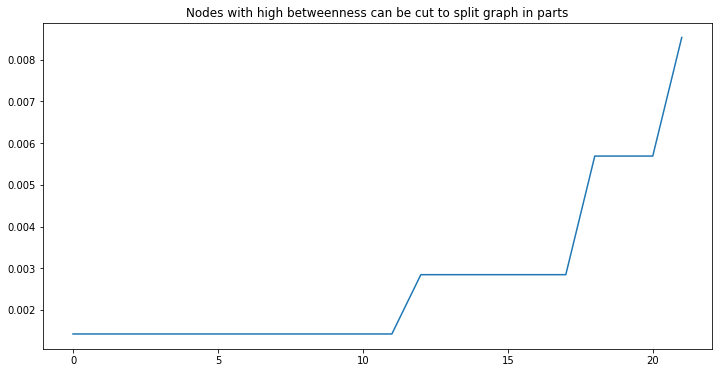

In [73]:
# print betweenness
bt = list(nx.edge_betweenness(G3).values())
plt.plot(range(len(bt)), sorted(bt))
plt.title("Nodes with high betweenness can be cut to split graph in parts")
#plt.ylim([0, 0.02])
plt.show()

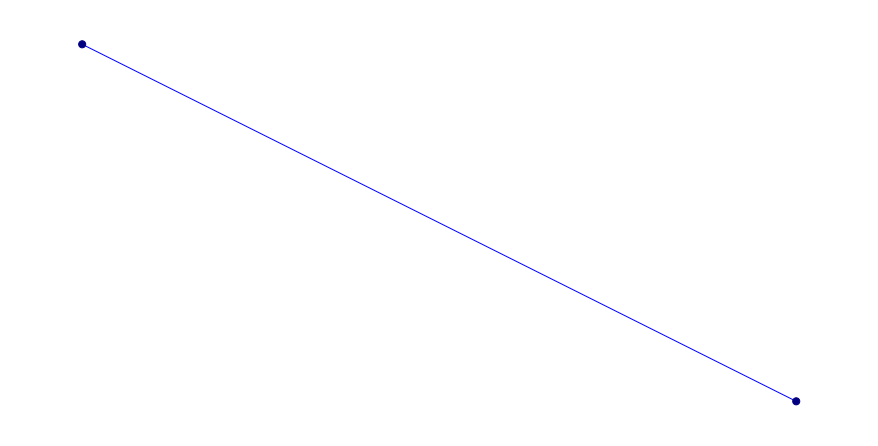

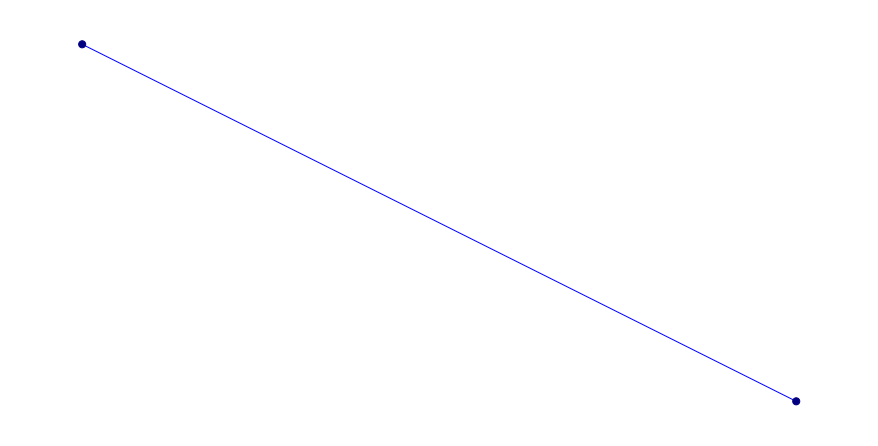

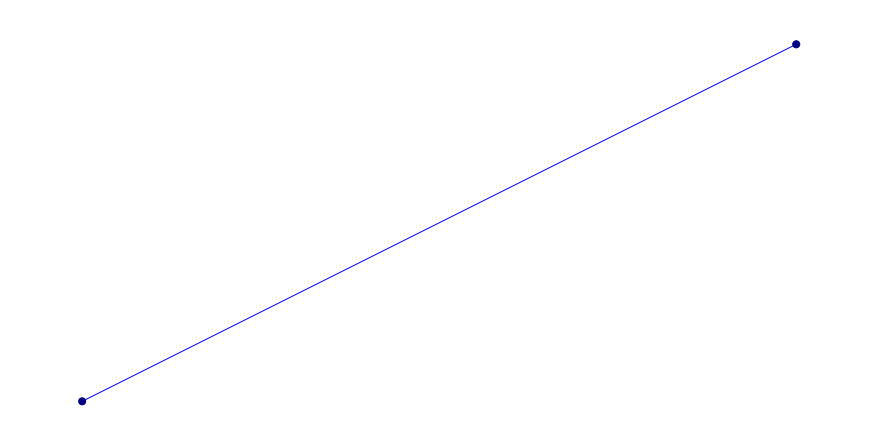

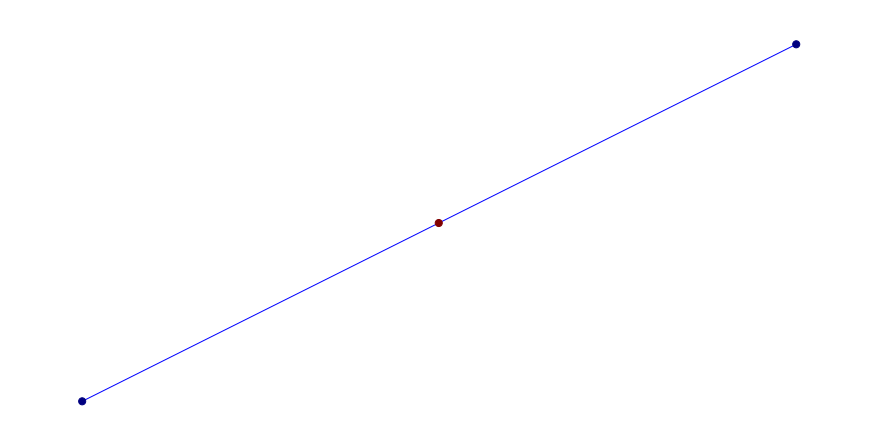

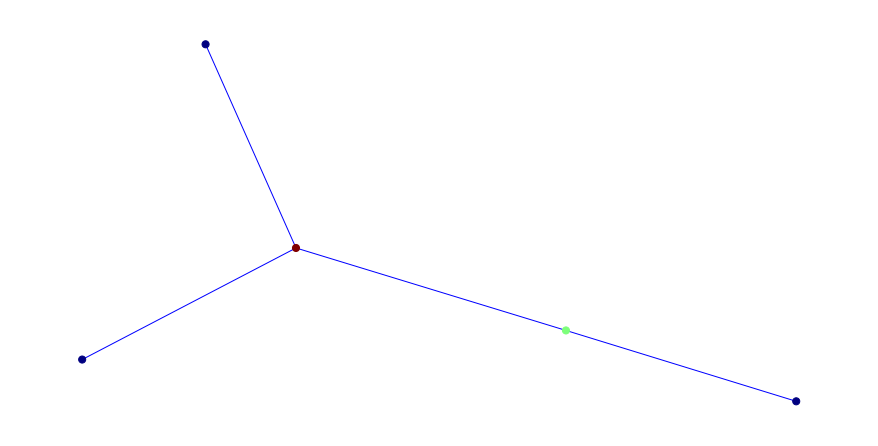

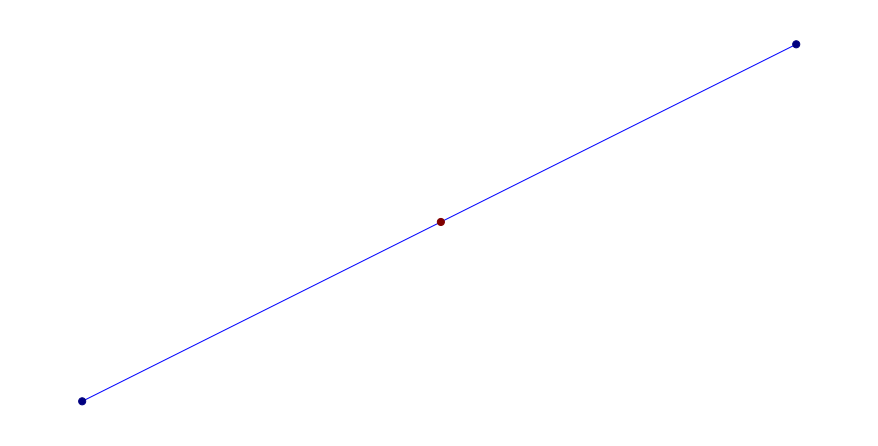

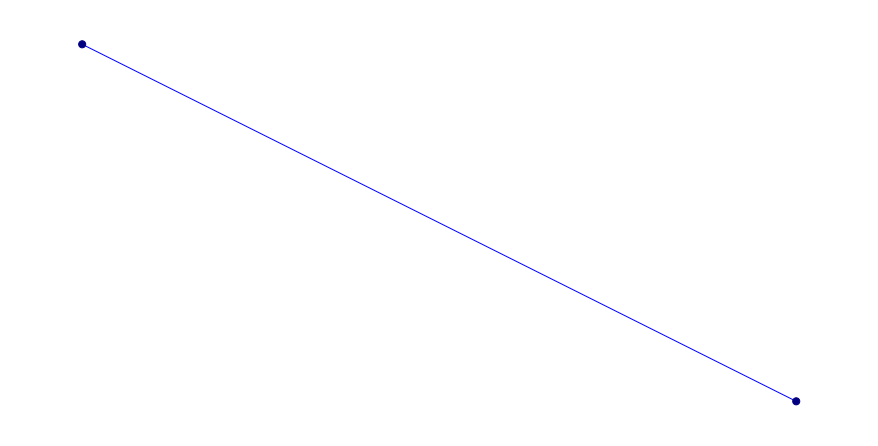

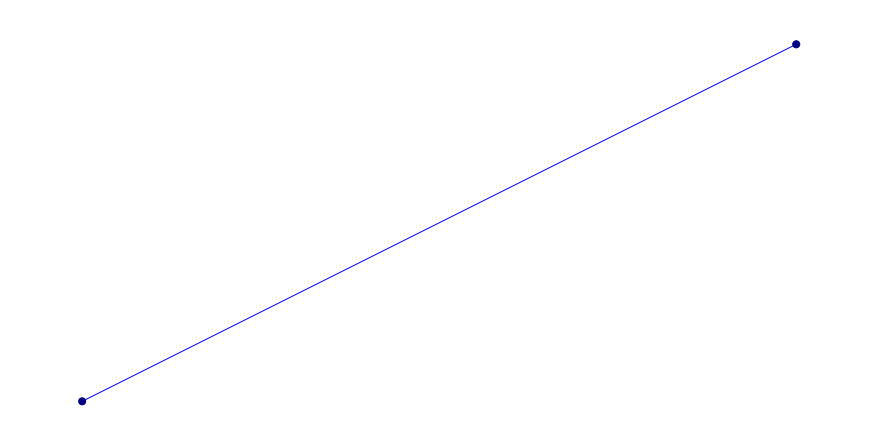

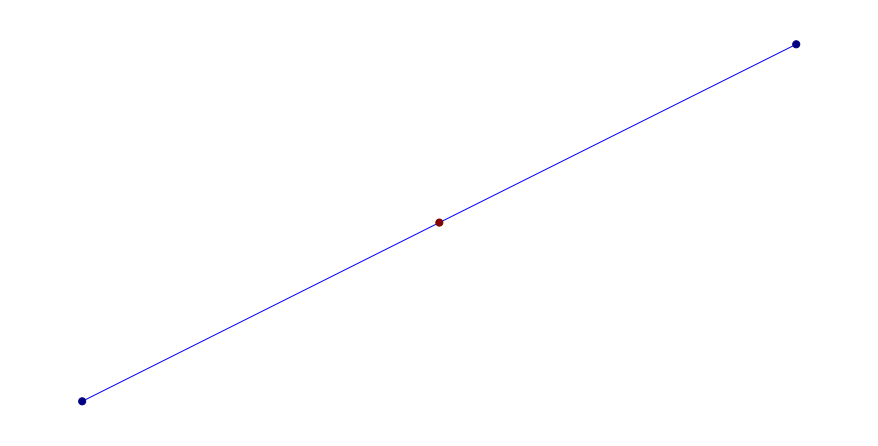

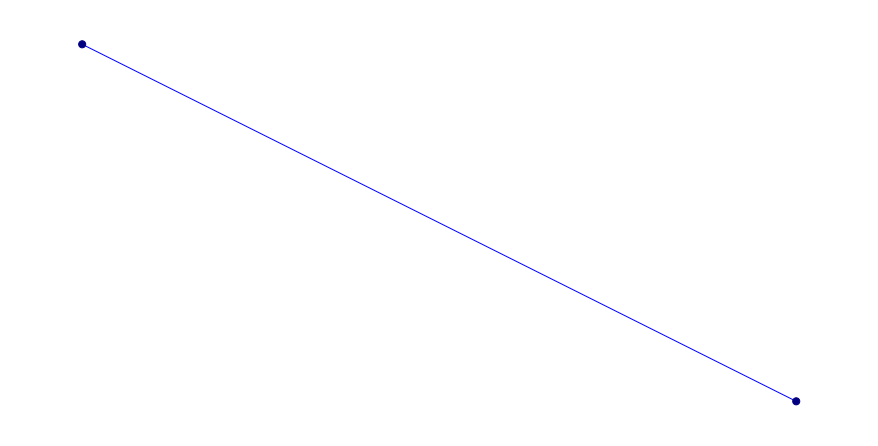

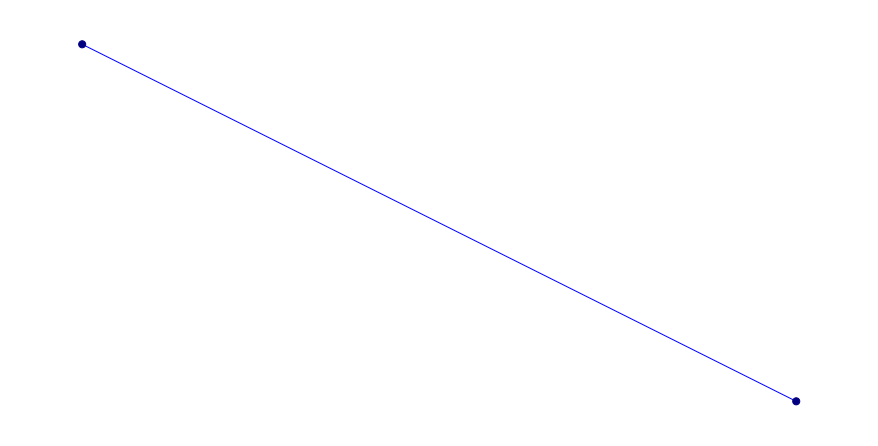

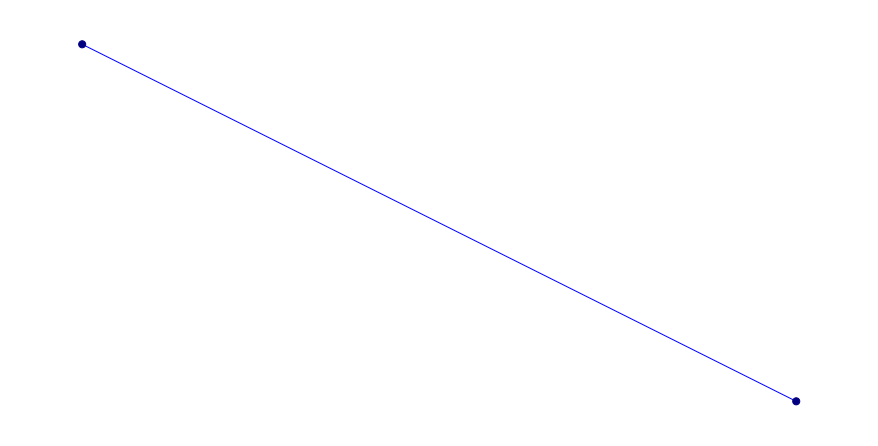

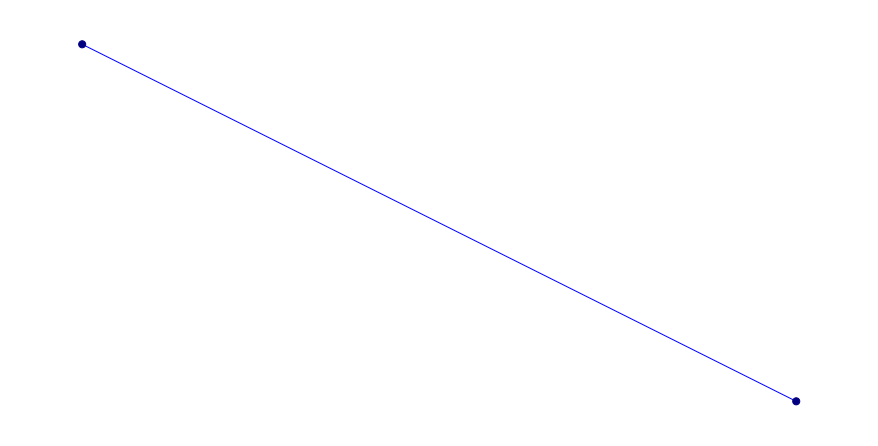

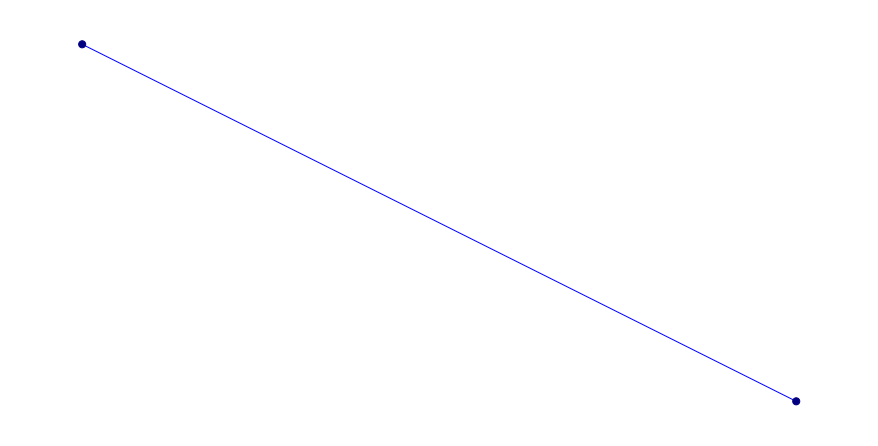

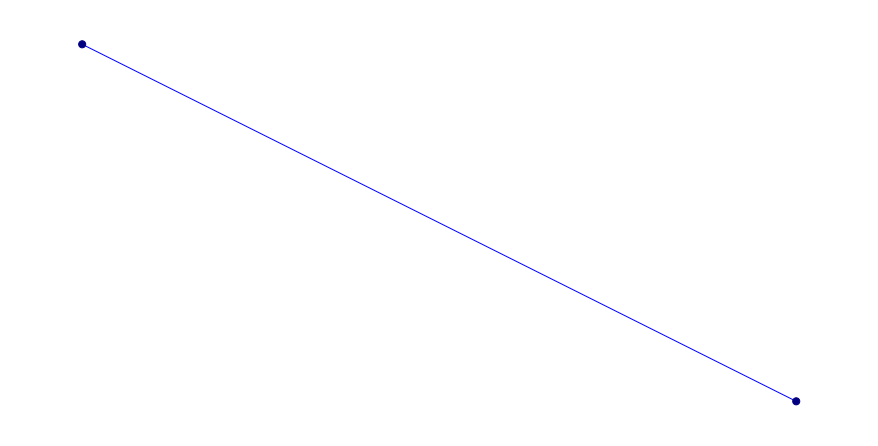

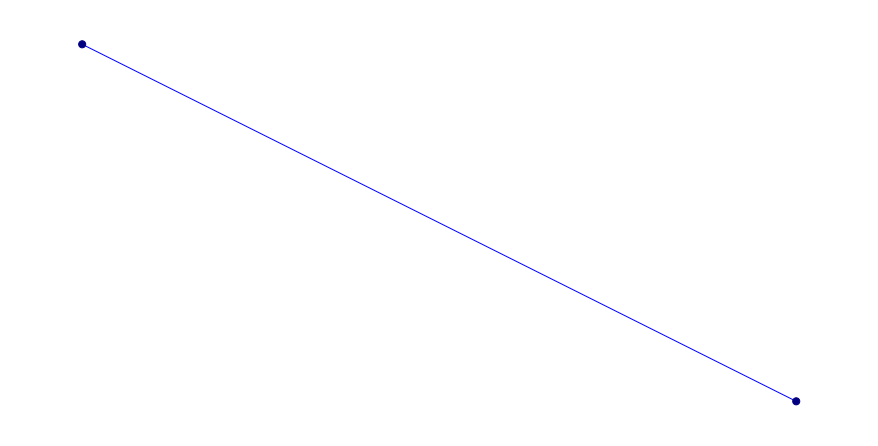

In [74]:
# print found components
#for G2 in nx.connected_component_subgraphs(G):  # for nx < 2.4 version
for G3 in connected_component_subgraphs(G3): # for nx >= 2.4 version
    node_degrees = list(dict(nx.degree(G3)).values())
    nx.draw(G3, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees)
    plt.show()

#### Communities based on pairs of authors 

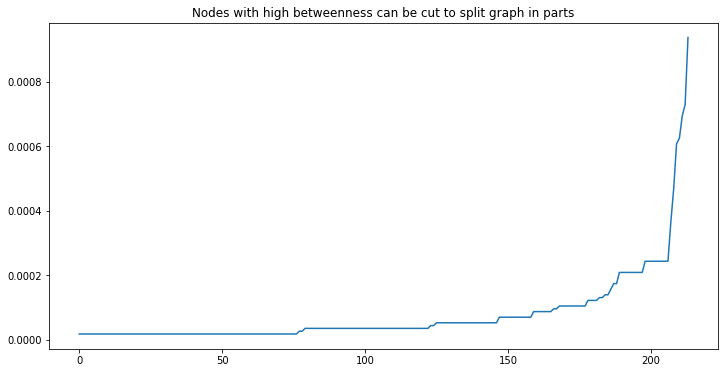

In [77]:
# print betweenness
bt = list(nx.edge_betweenness(G4).values())
plt.plot(range(len(bt)), sorted(bt))
plt.title("Nodes with high betweenness can be cut to split graph in parts")
#plt.ylim([0, 0.02])
plt.show()

In [78]:
# remove edges with betweenness larger than threshold
thr = 0.0002 # around 70% of the max value
while True:
    bt = nx.edge_betweenness(G4)
    
    i = np.argmax(list(bt.values()))
    if list(bt.values())[i] < thr:
        break
    n1, n2 = list(bt.keys())[i]
    G4.remove_edge(n1, n2)

# clean graph from single-node components for easy printing
for n, d in list(nx.degree(G4)):
    if d == 0:
        G4.remove_node(n)

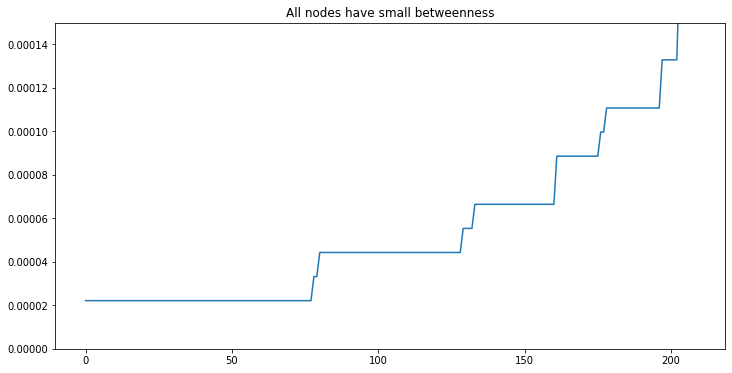

In [79]:
# print new betweenness
bt = nx.edge_betweenness(G4).values()
plt.plot(range(len(bt)), sorted(bt))
plt.title("All nodes have small betweenness")
plt.ylim([0, 0.00015])
plt.show()

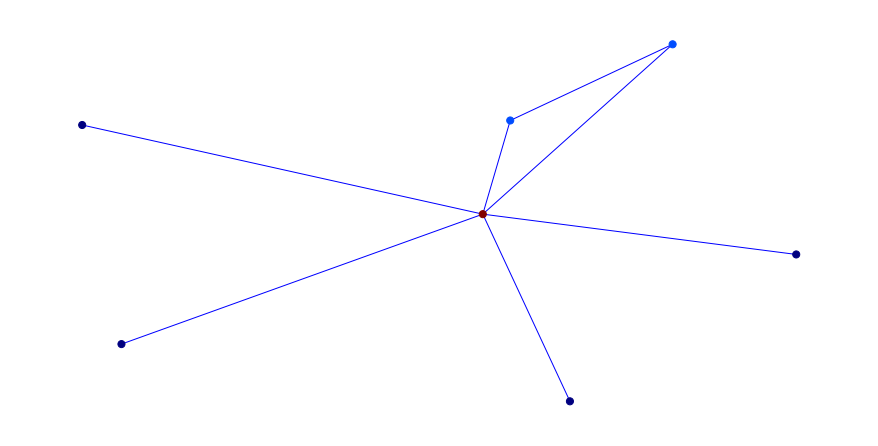

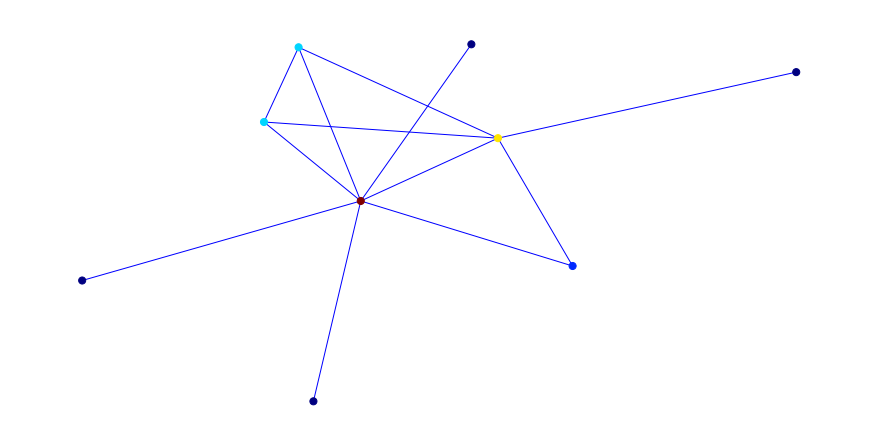

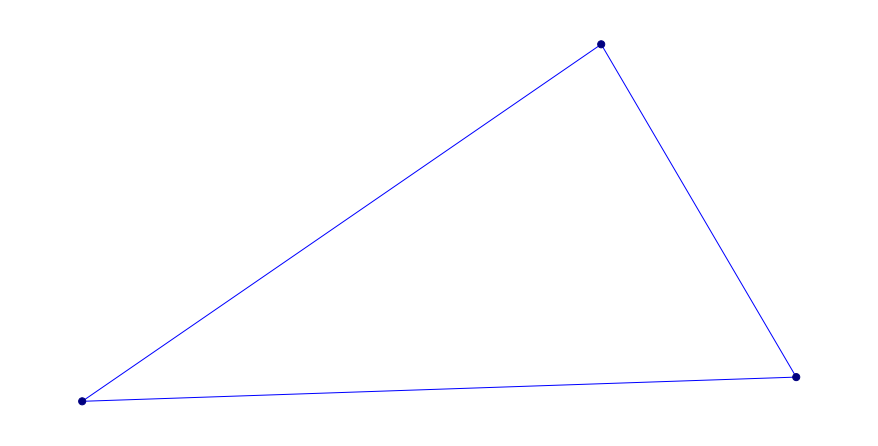

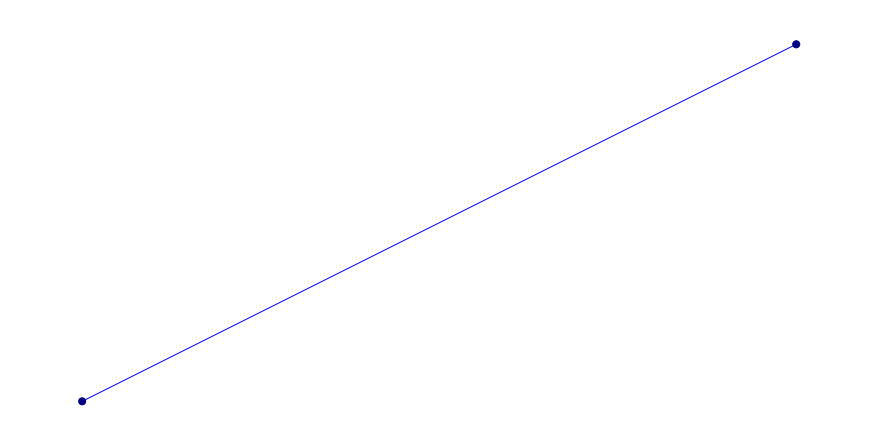

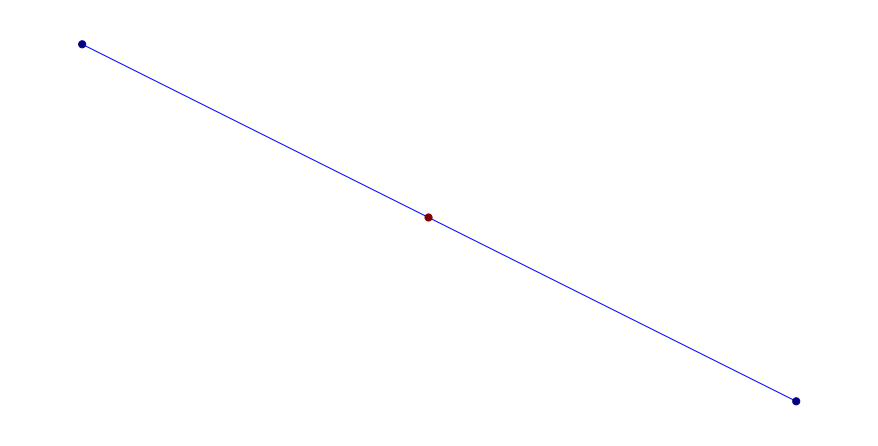

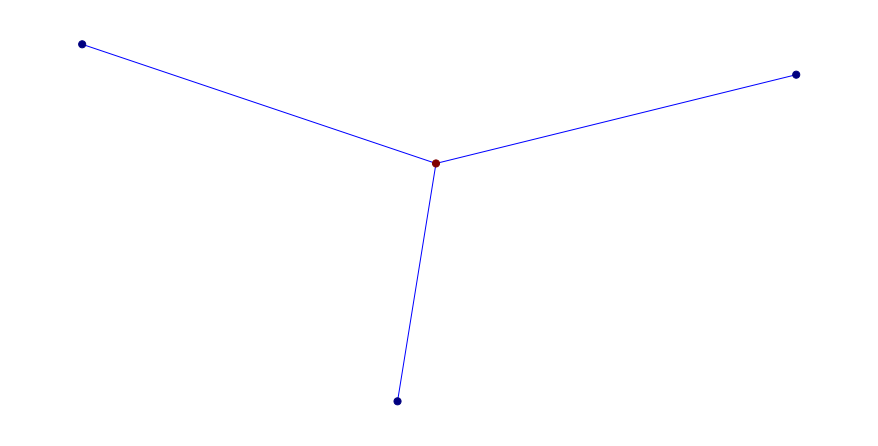

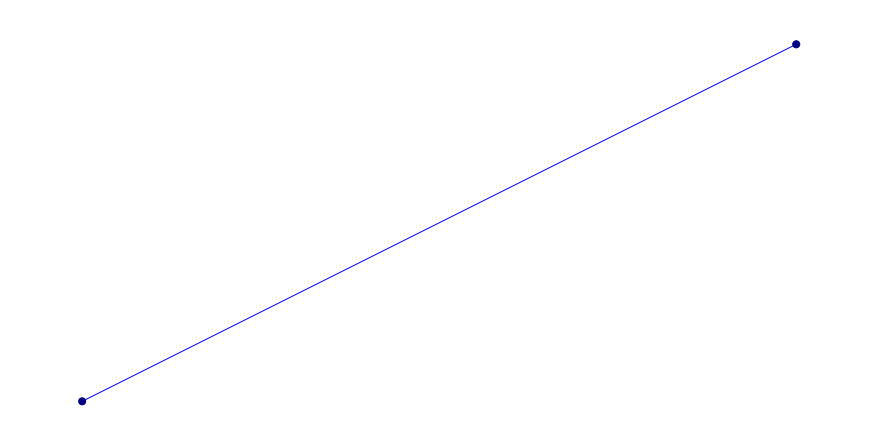

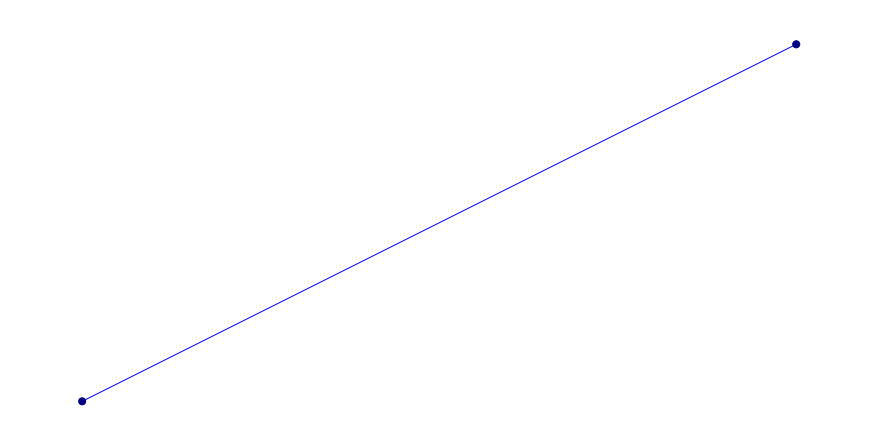

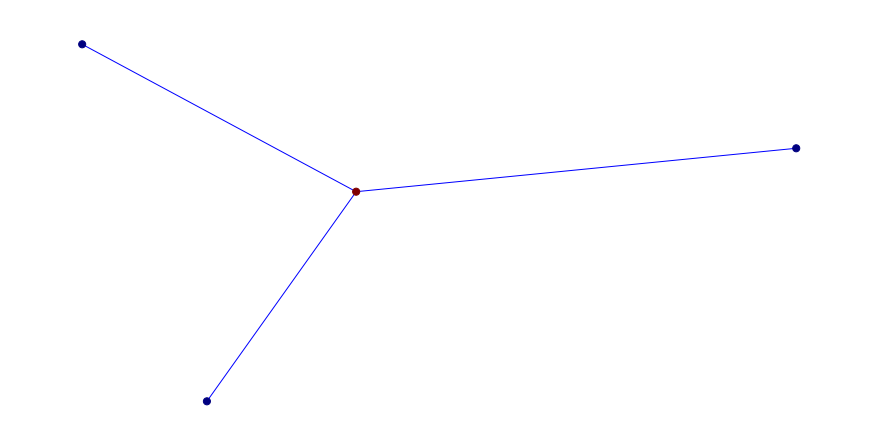

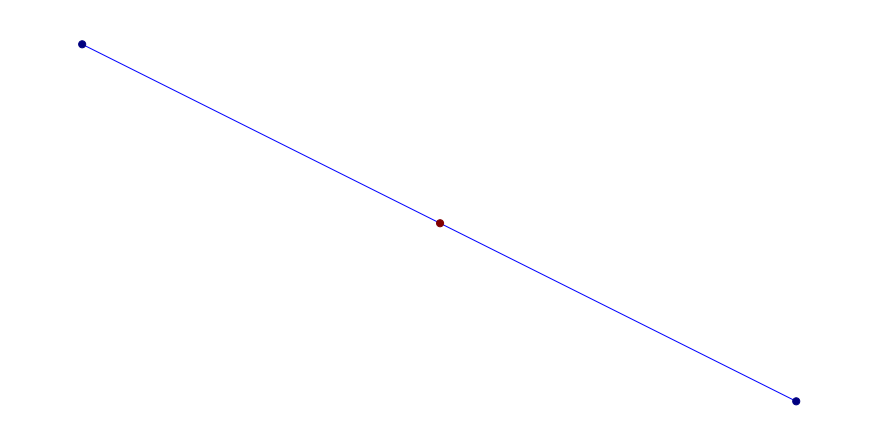

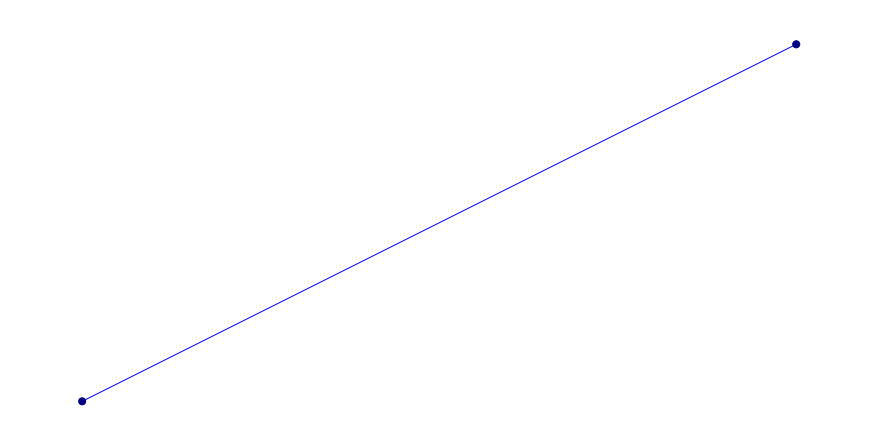

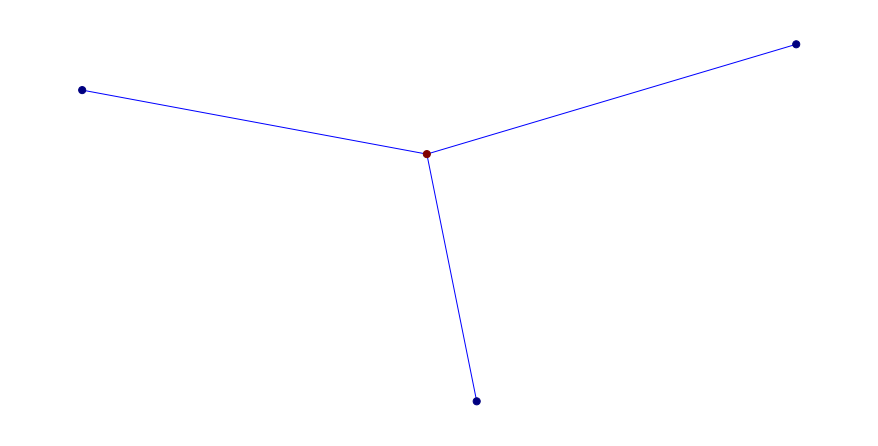

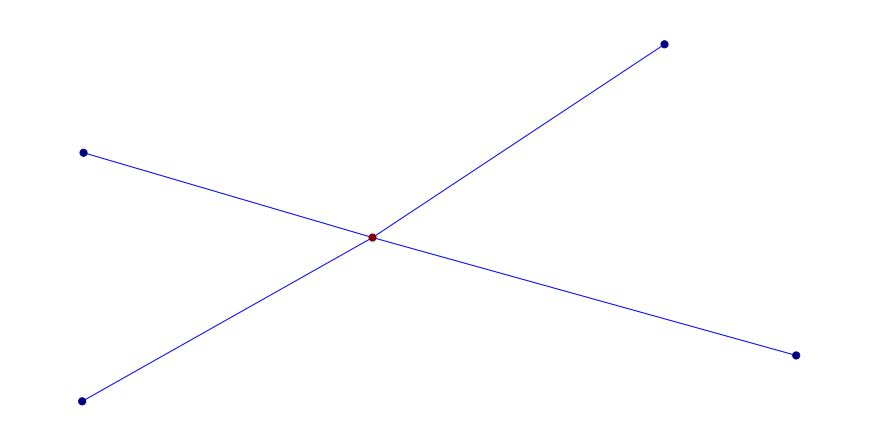

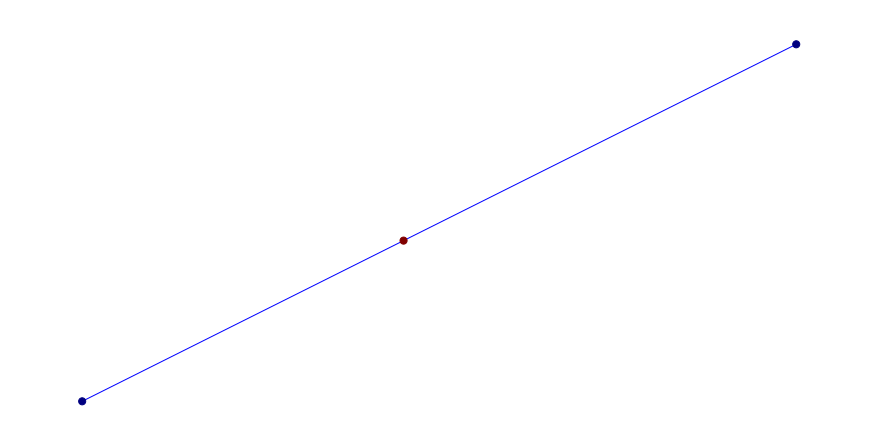

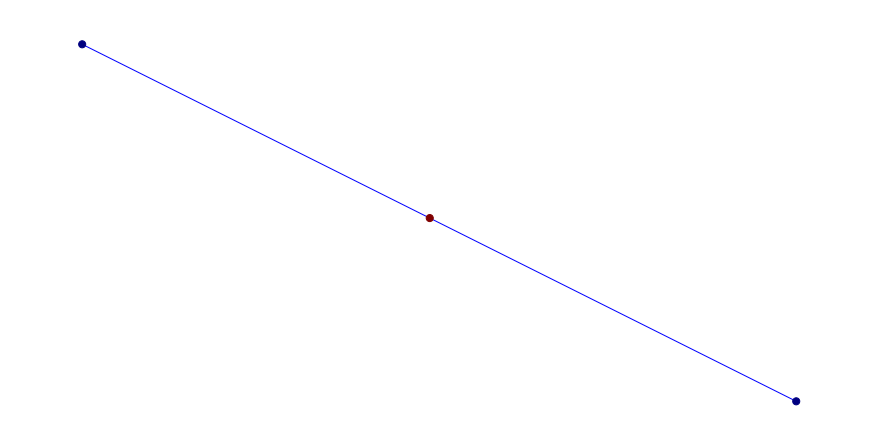

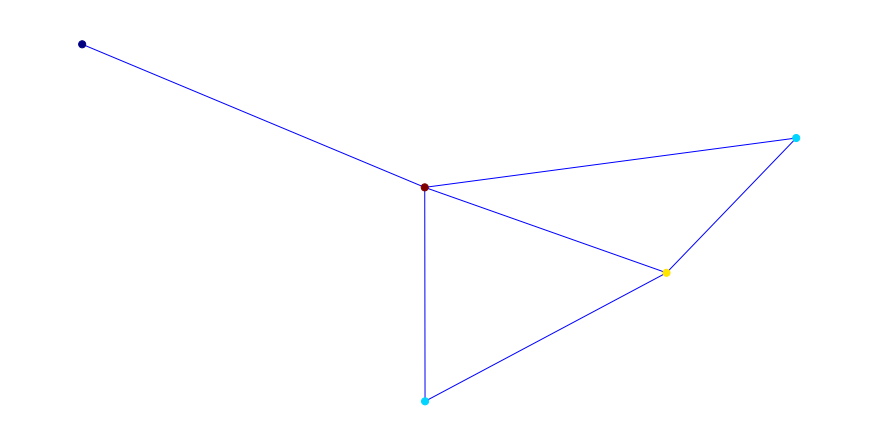

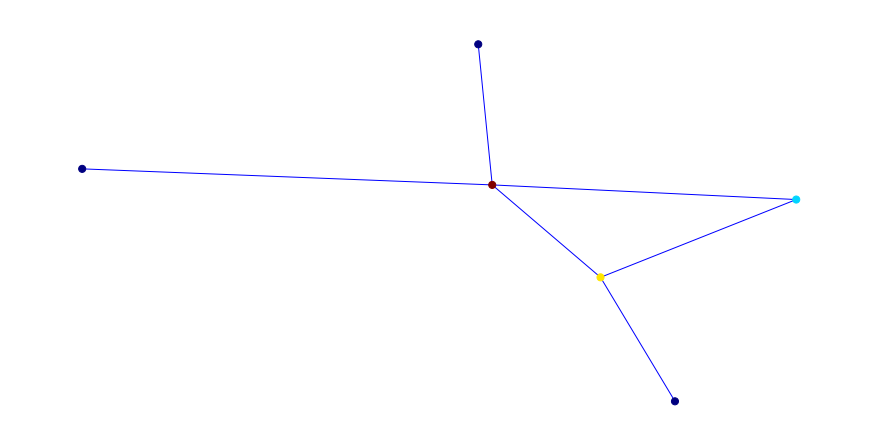

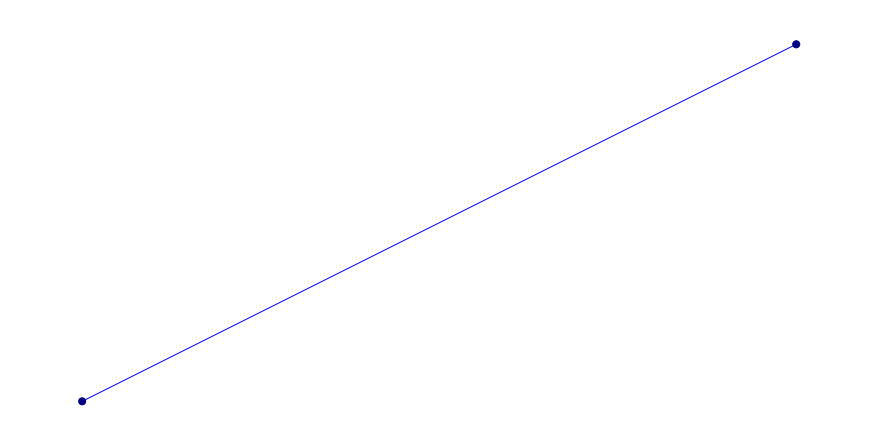

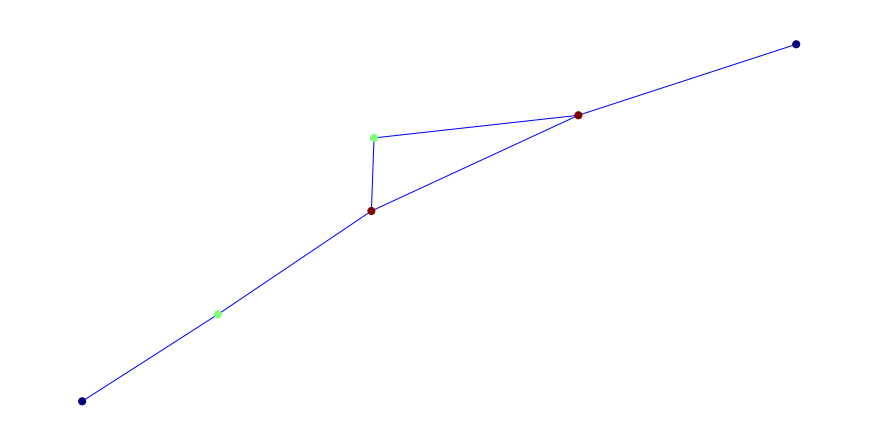

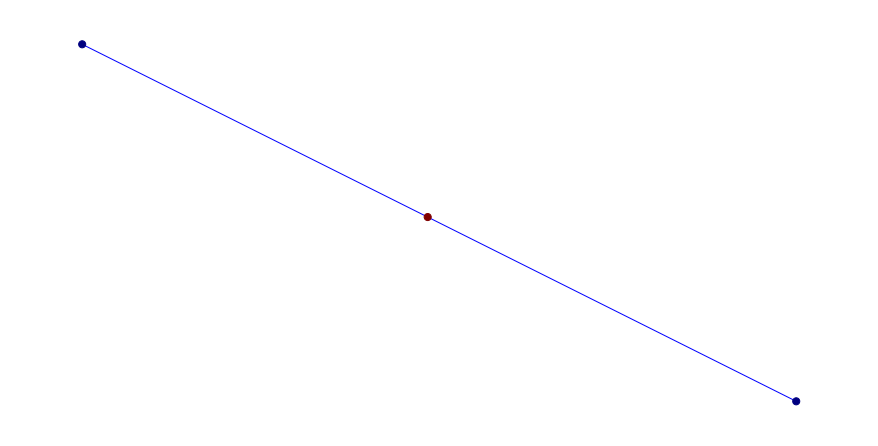

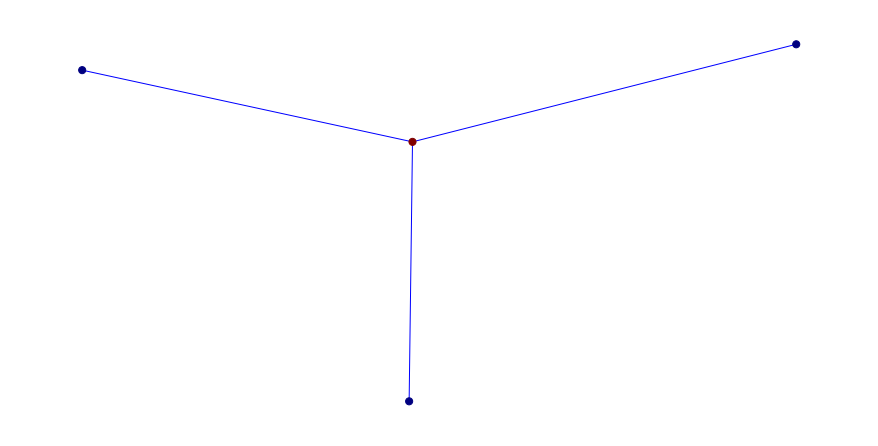

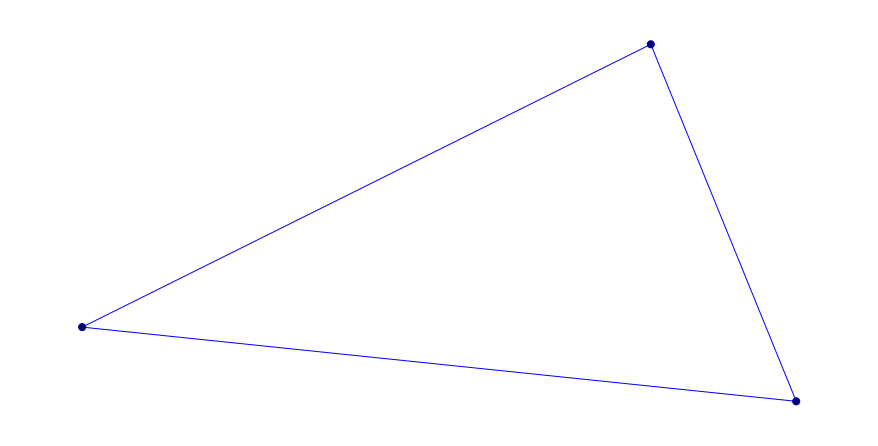

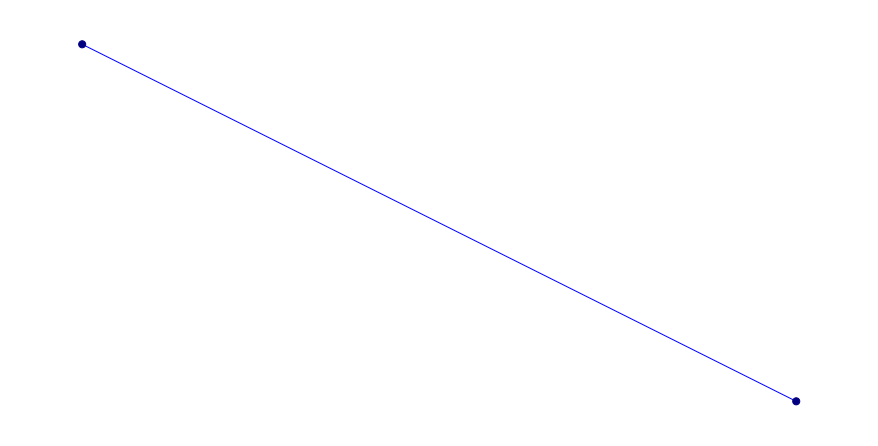

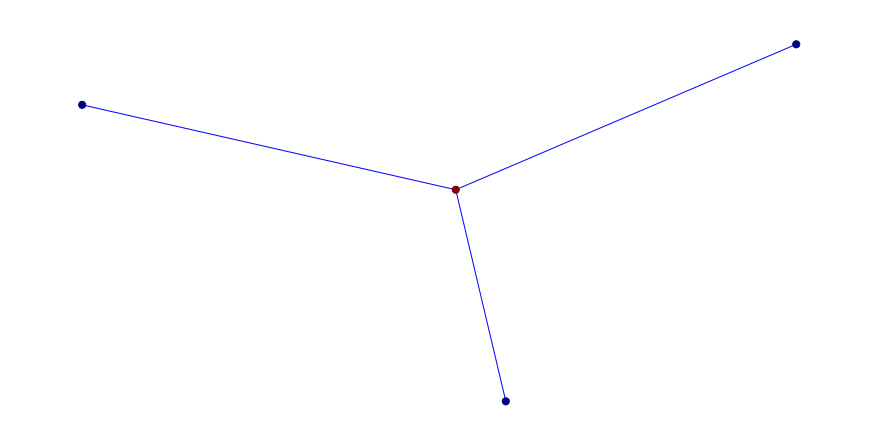

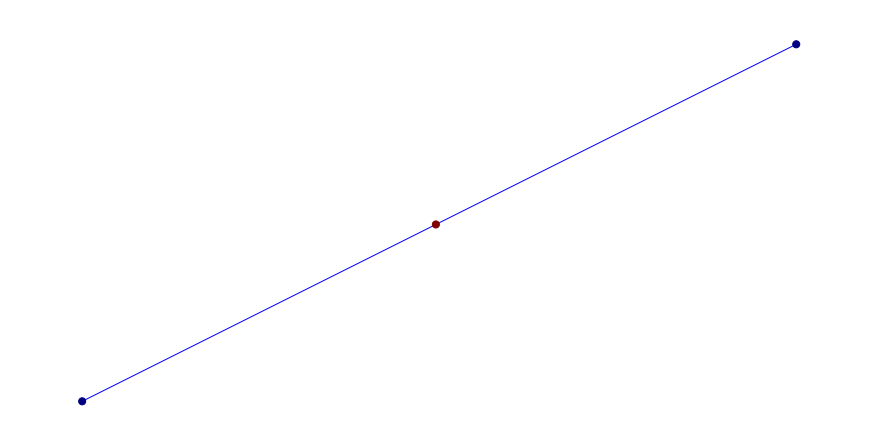

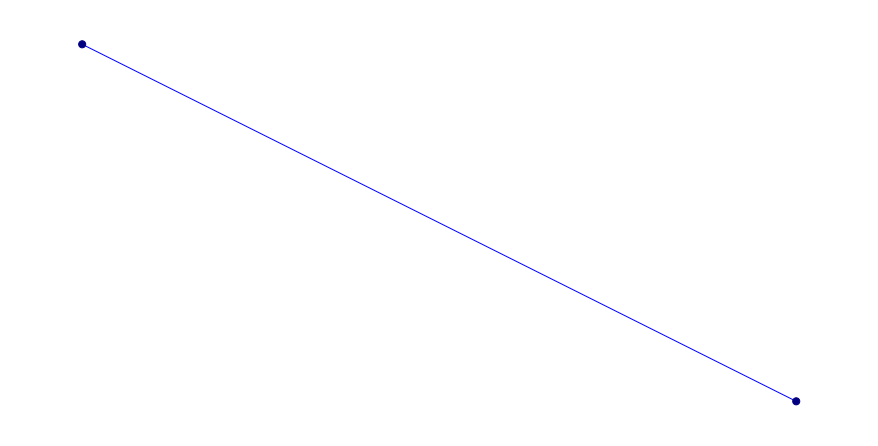

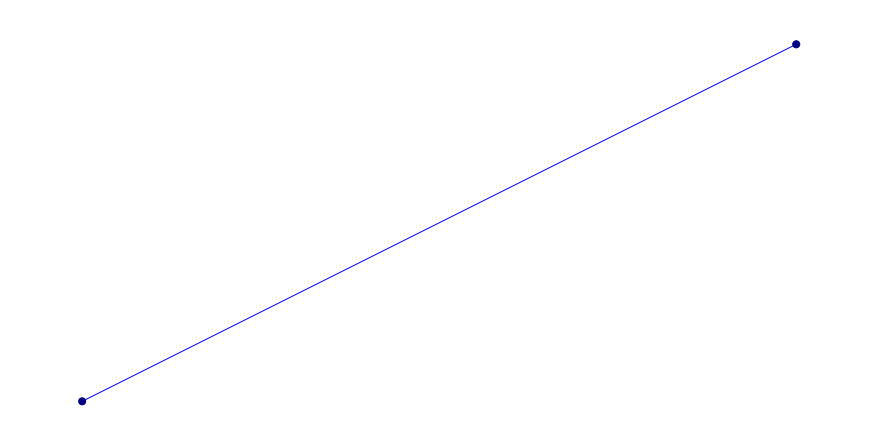

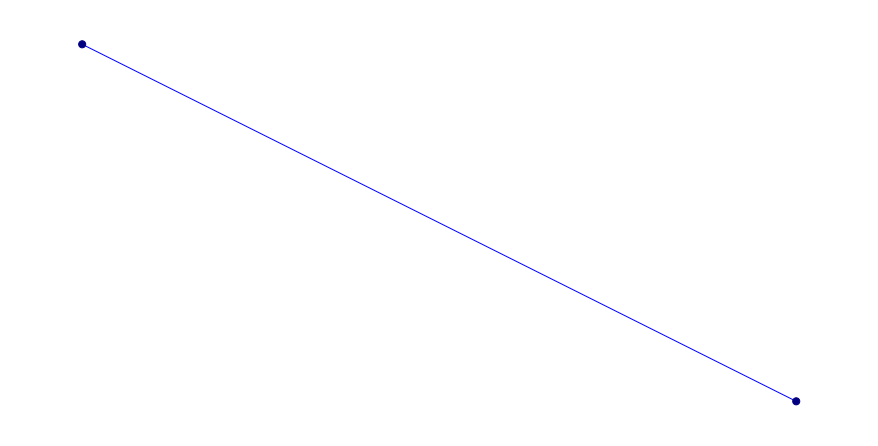

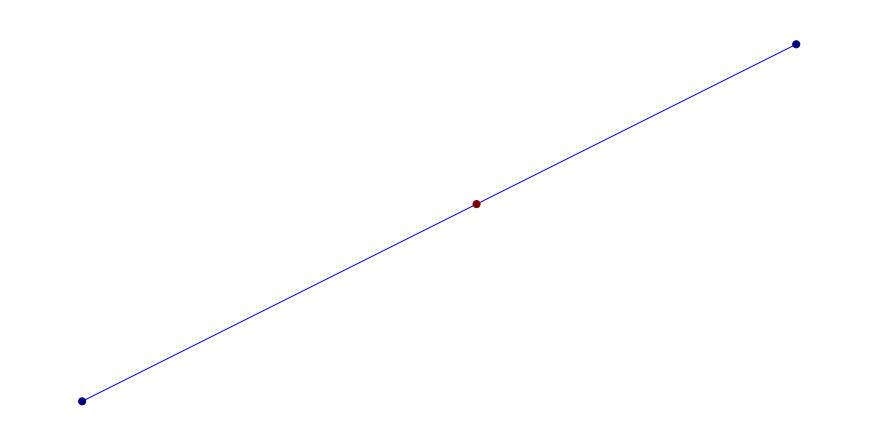

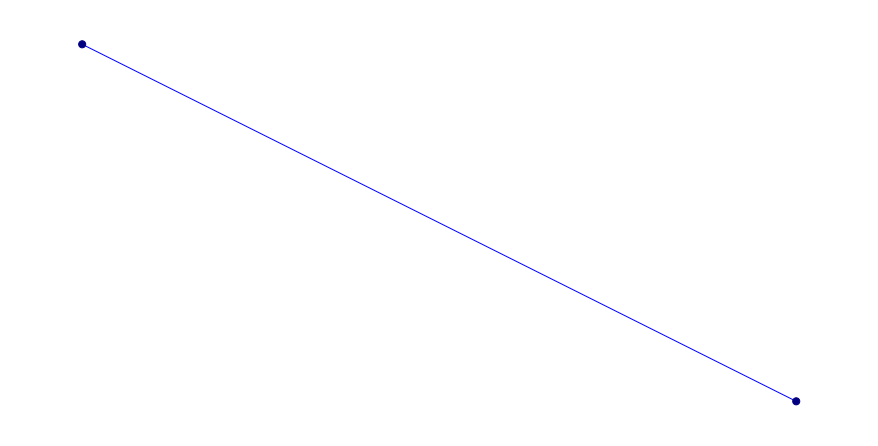

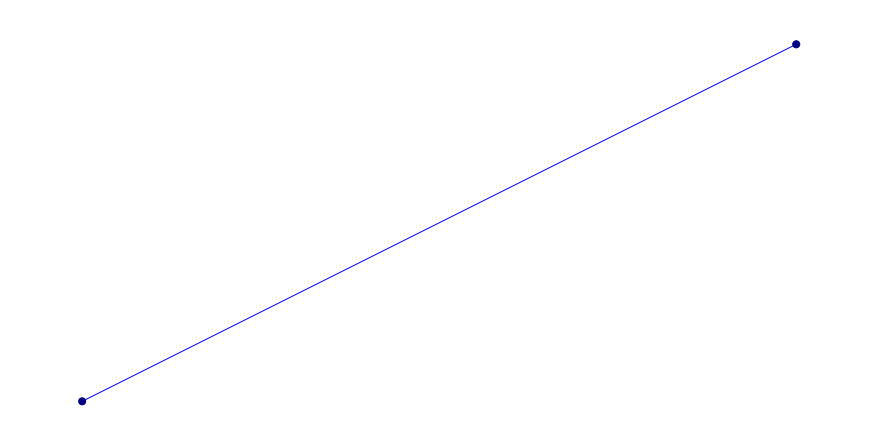

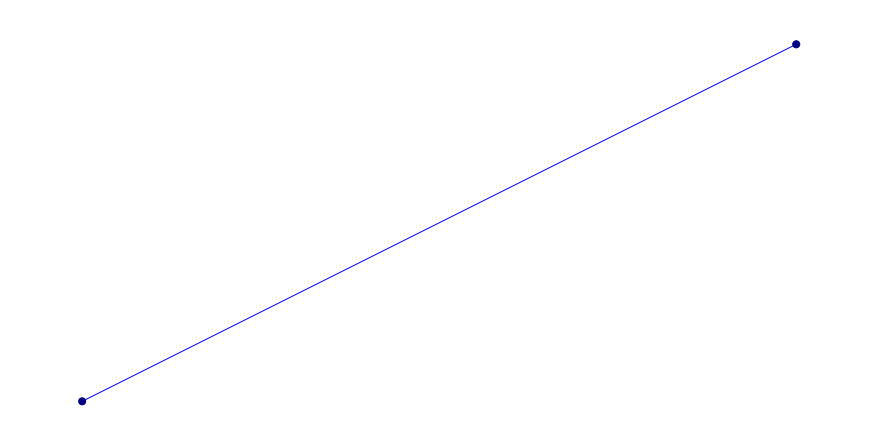

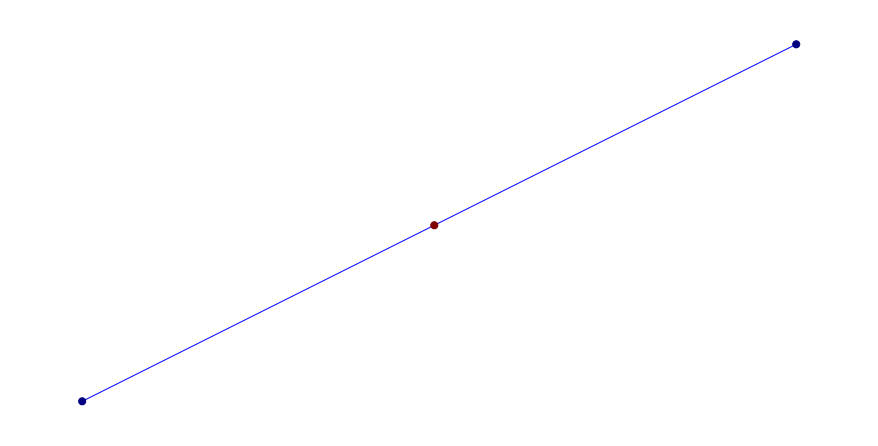

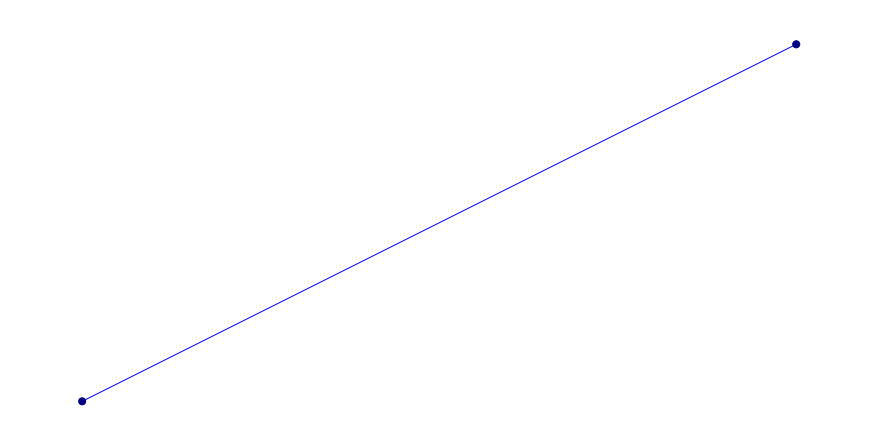

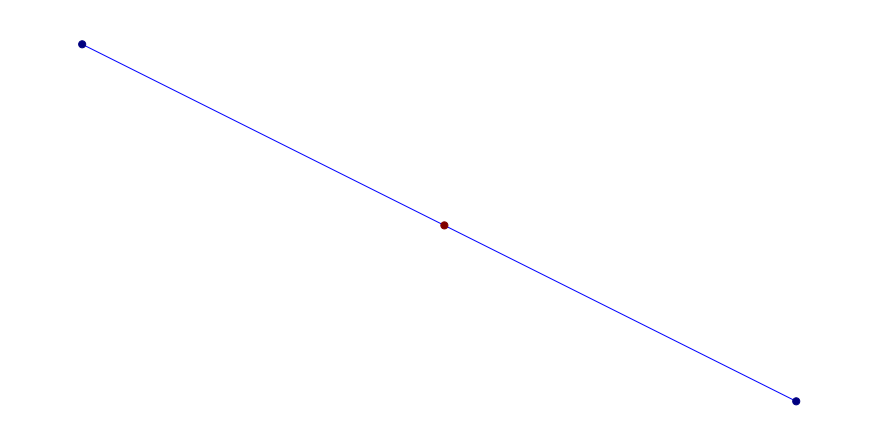

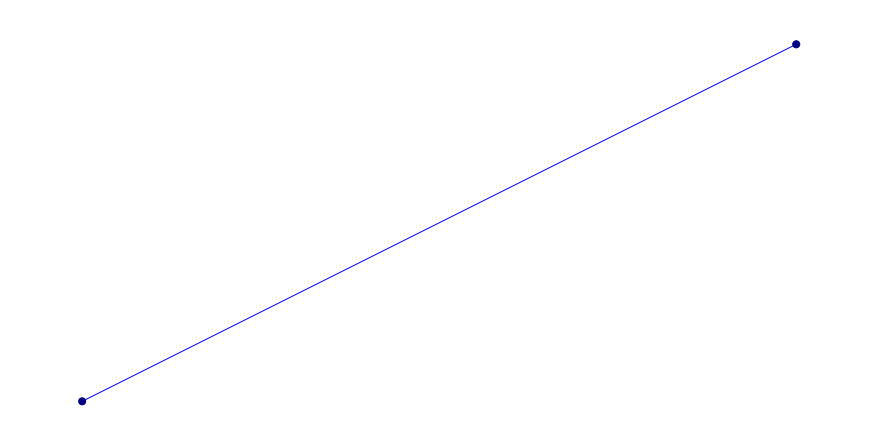

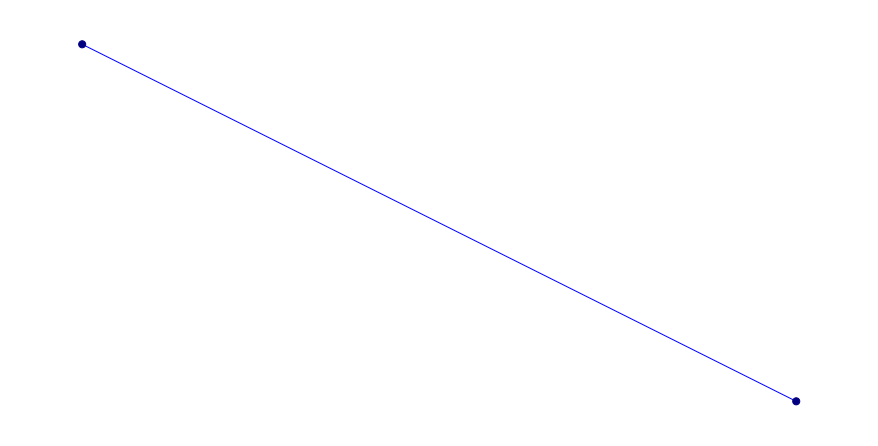

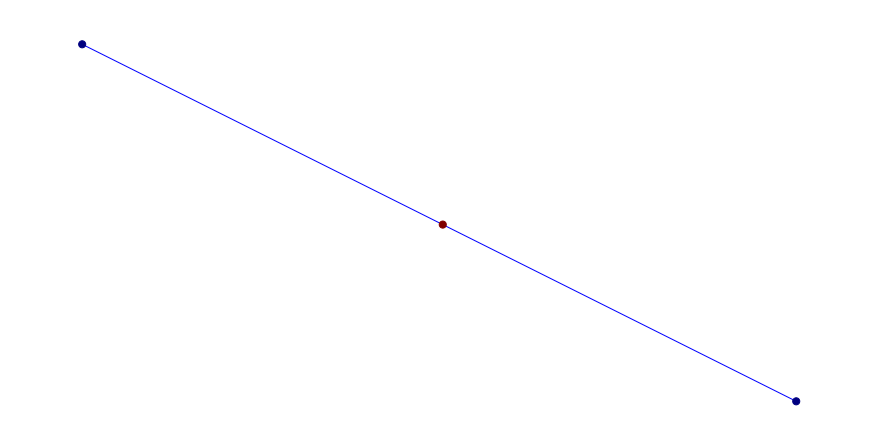

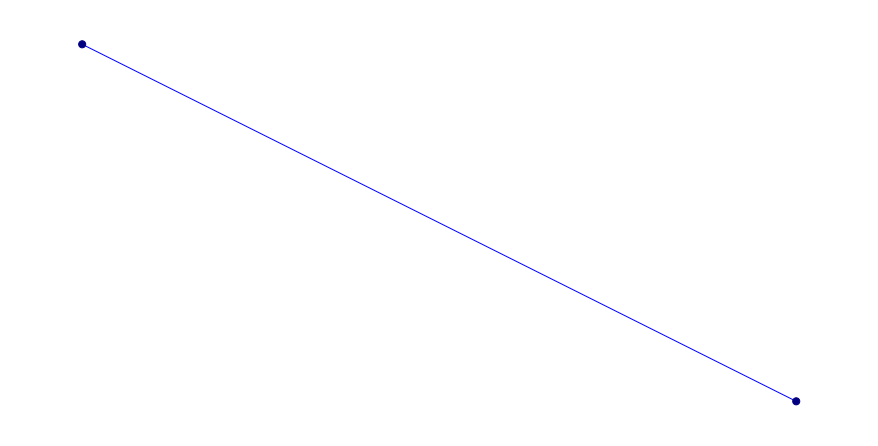

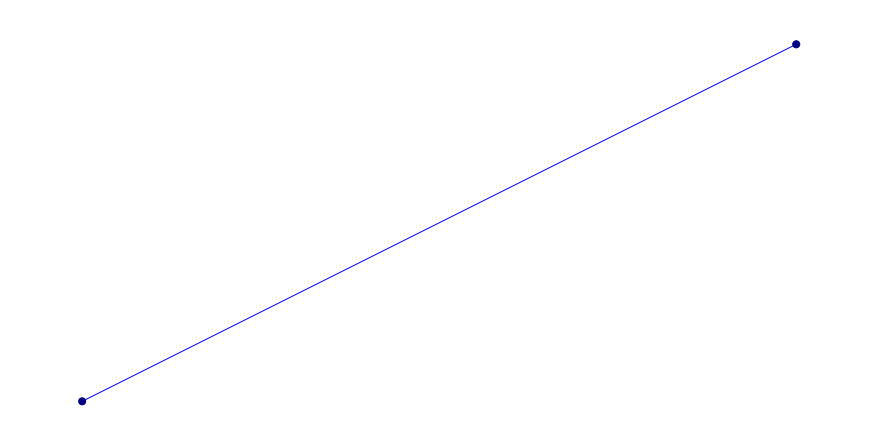

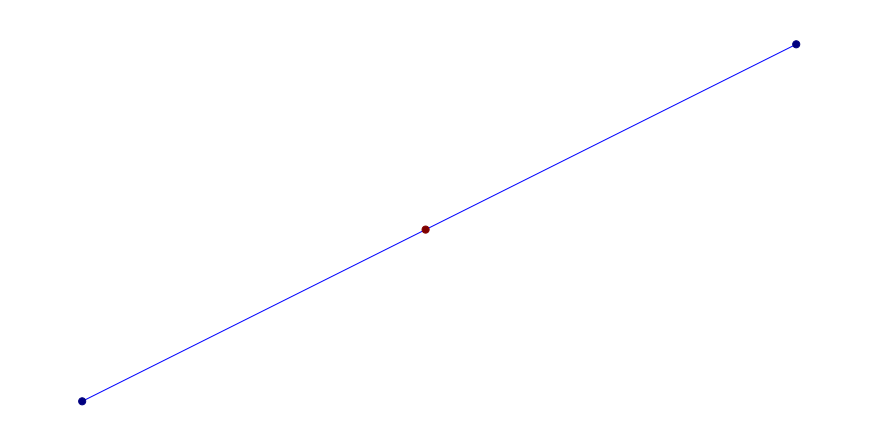

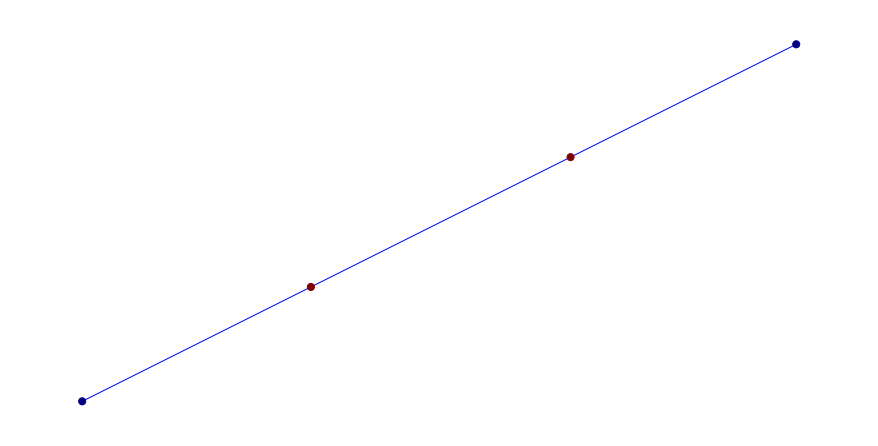

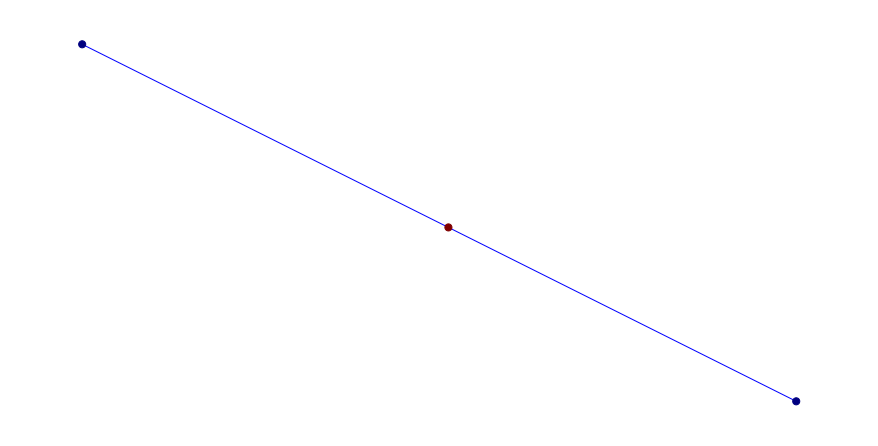

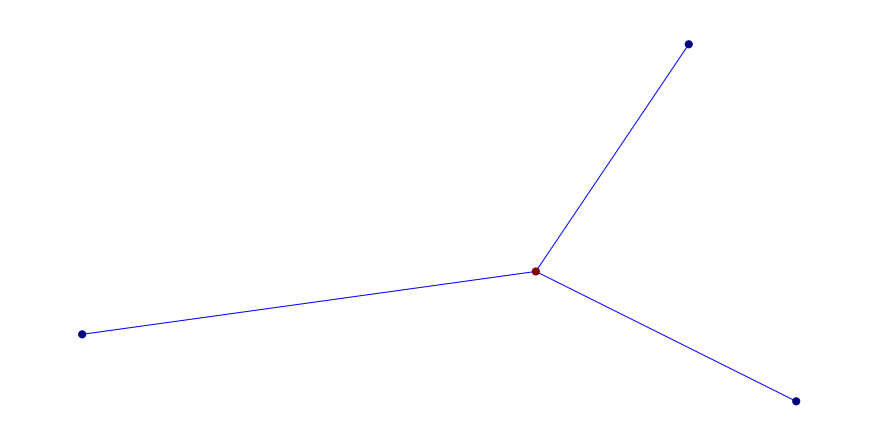

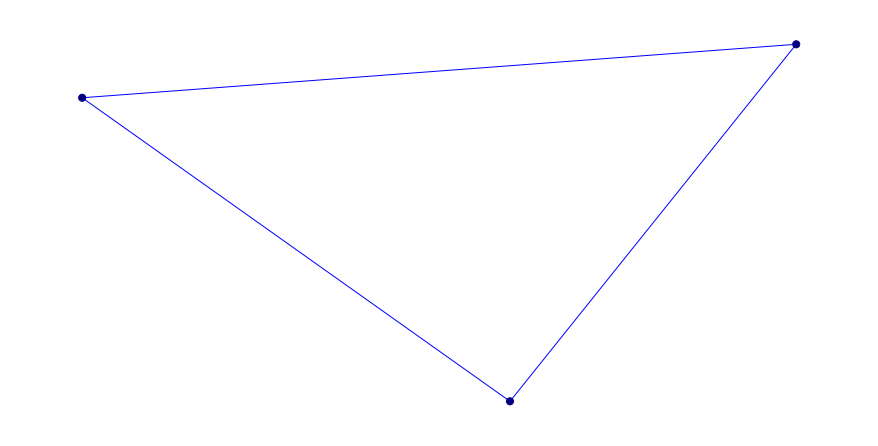

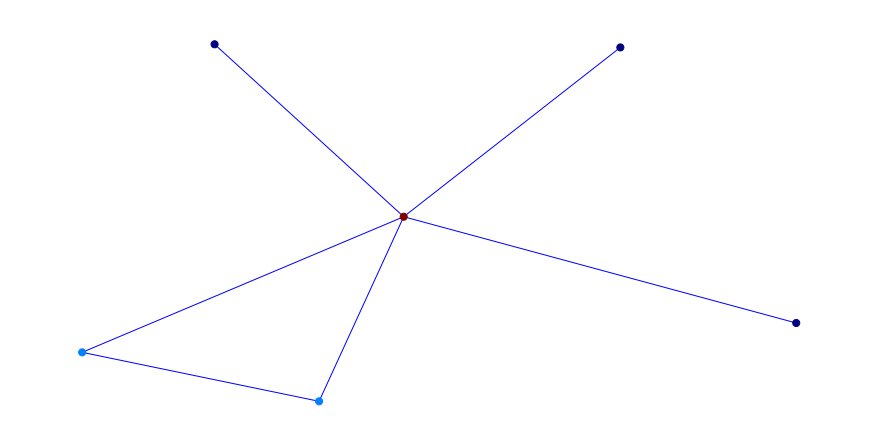

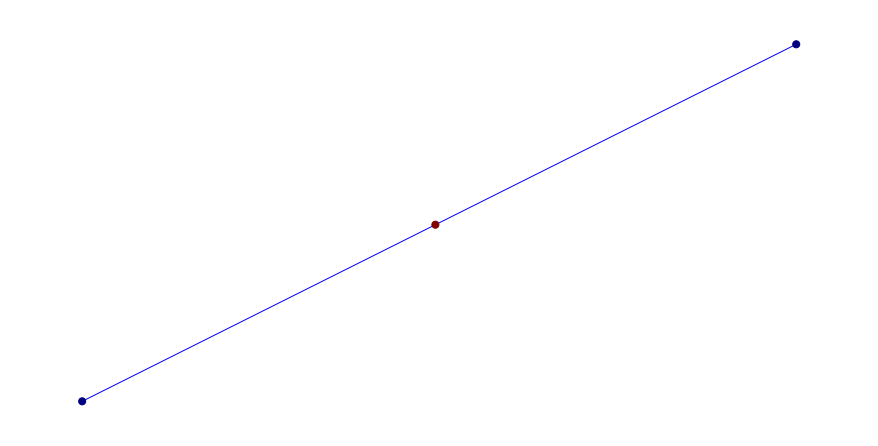

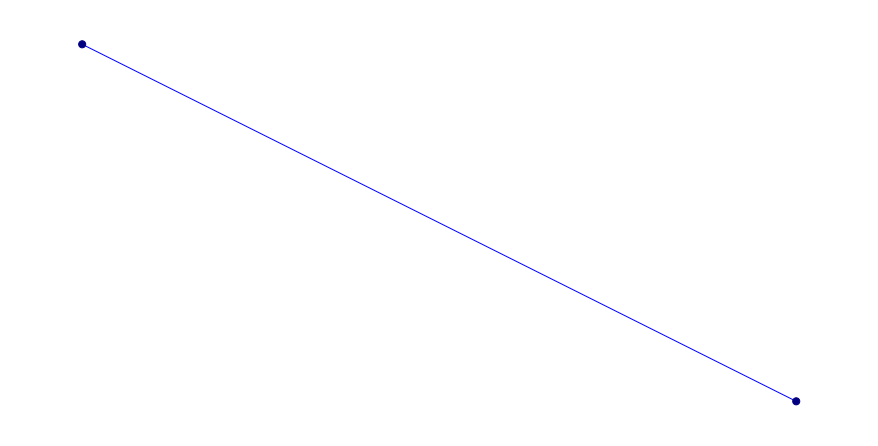

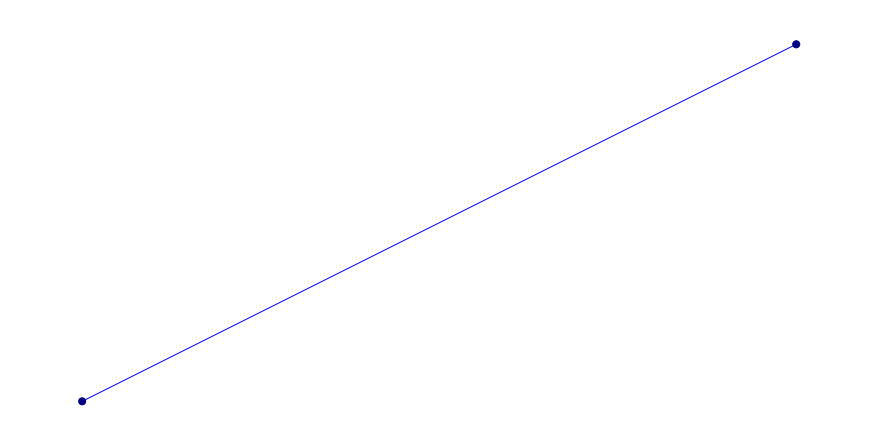

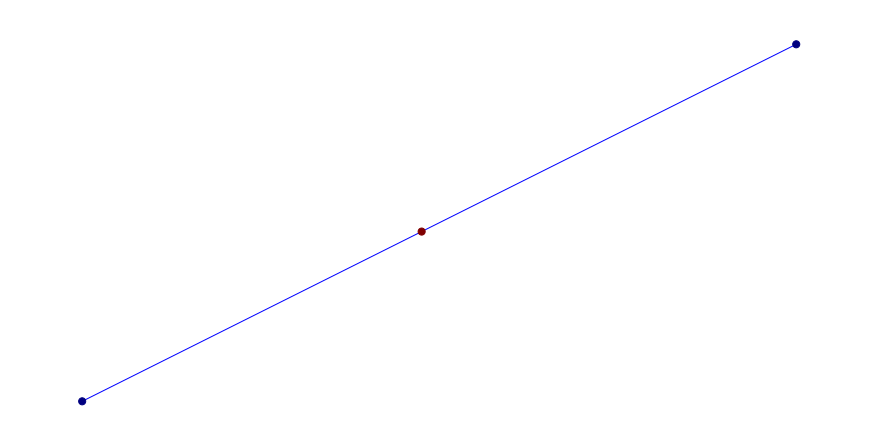

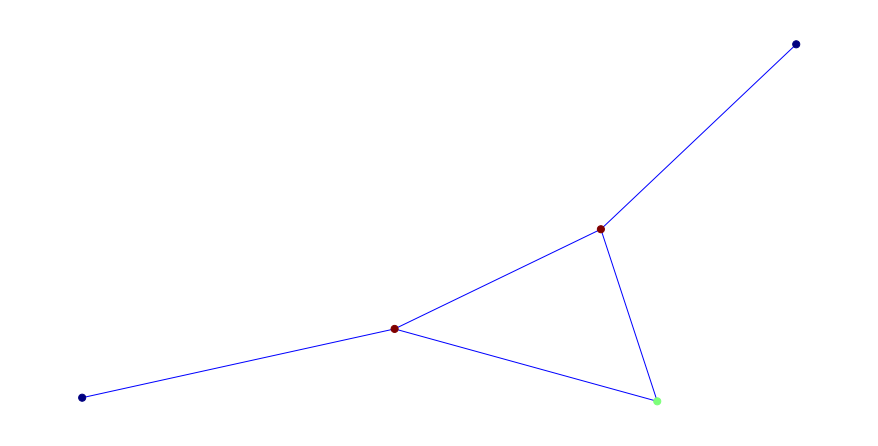

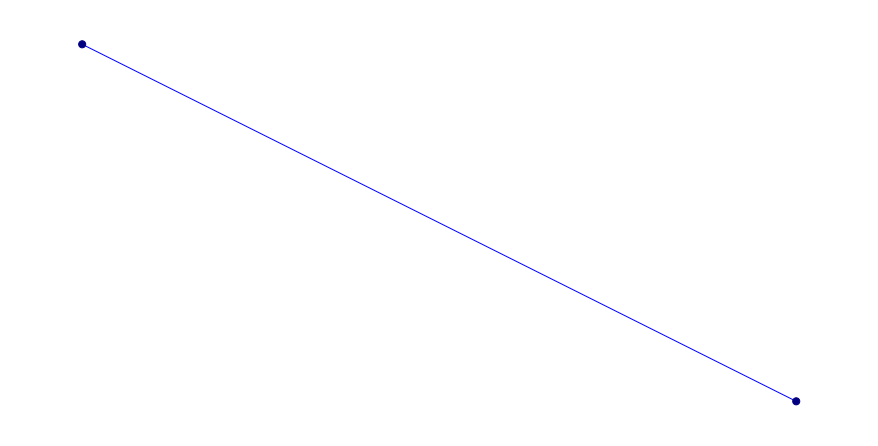

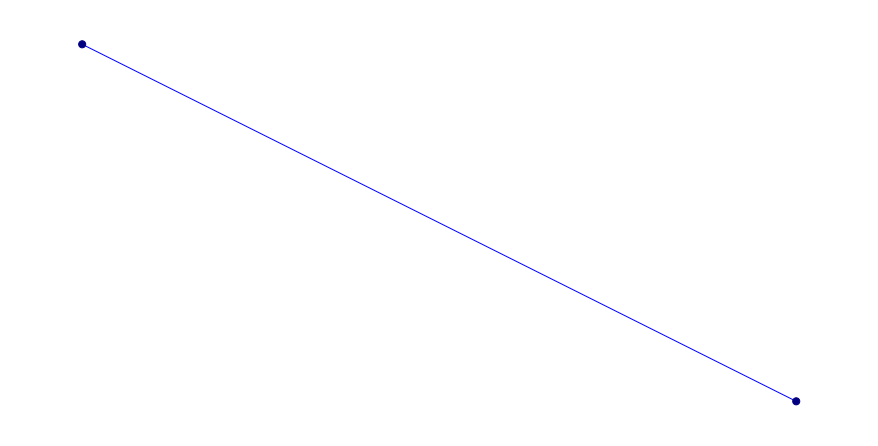

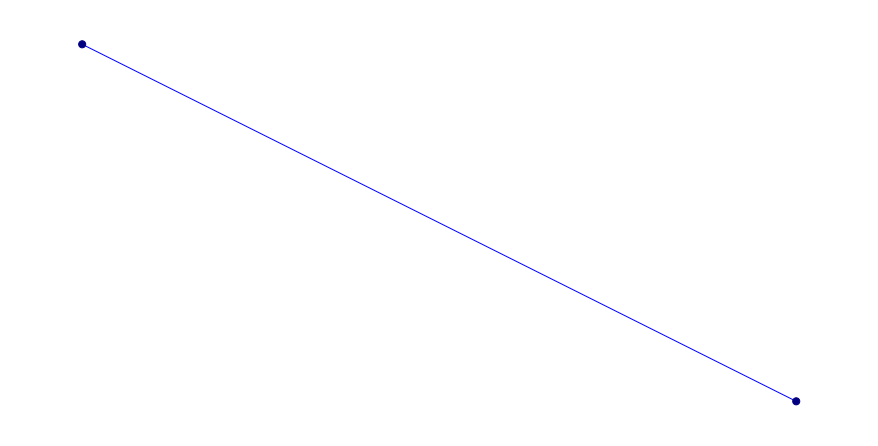

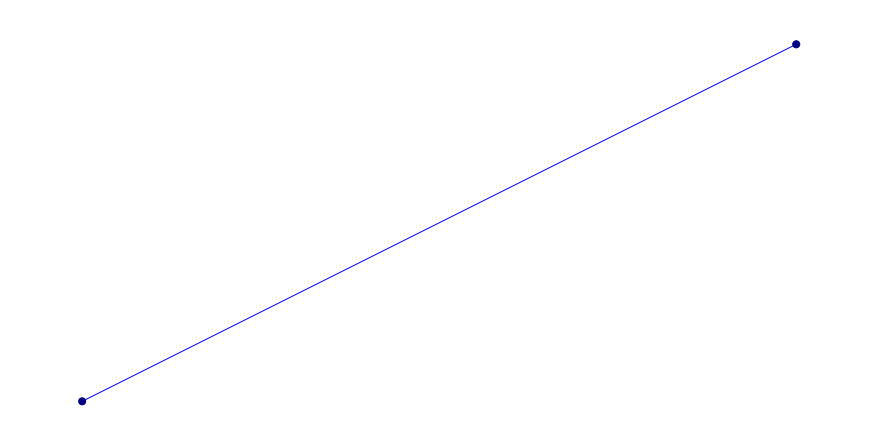

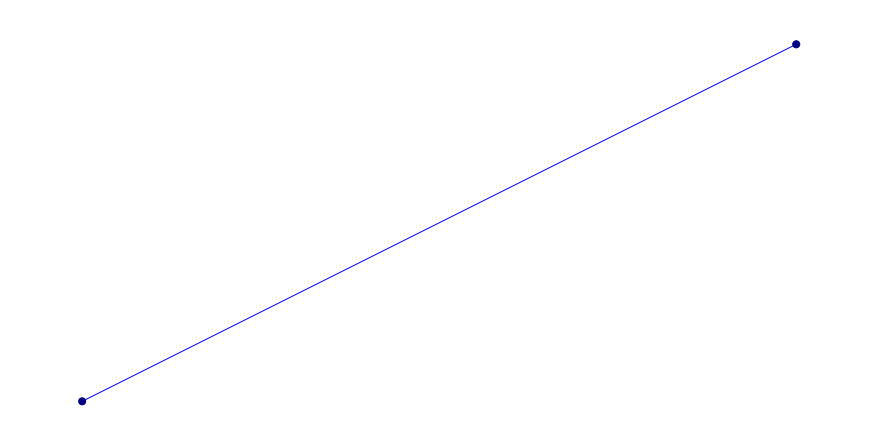

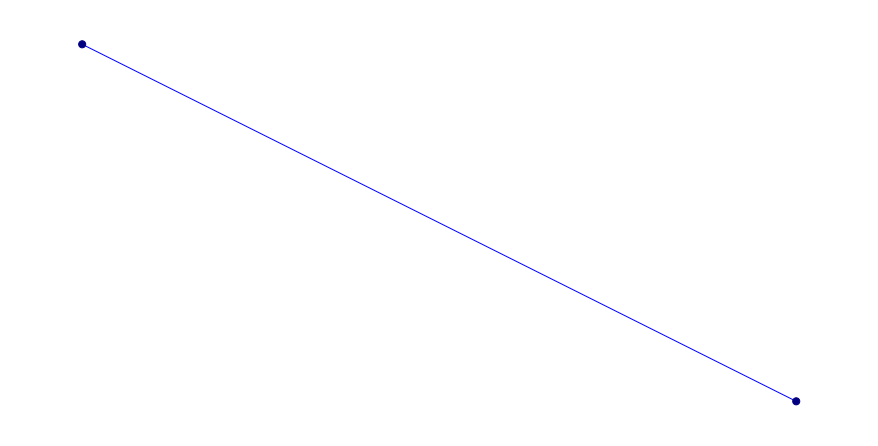

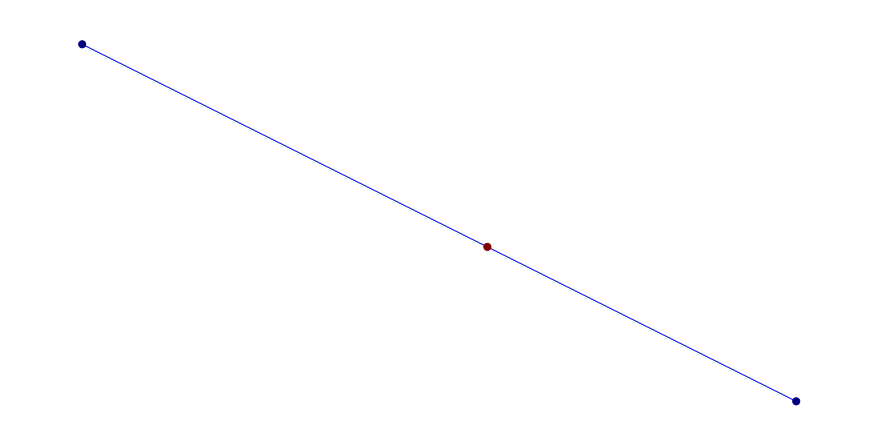

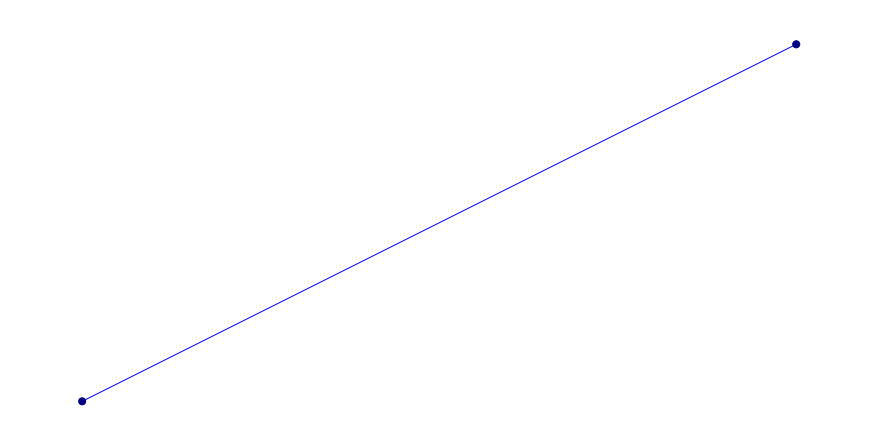

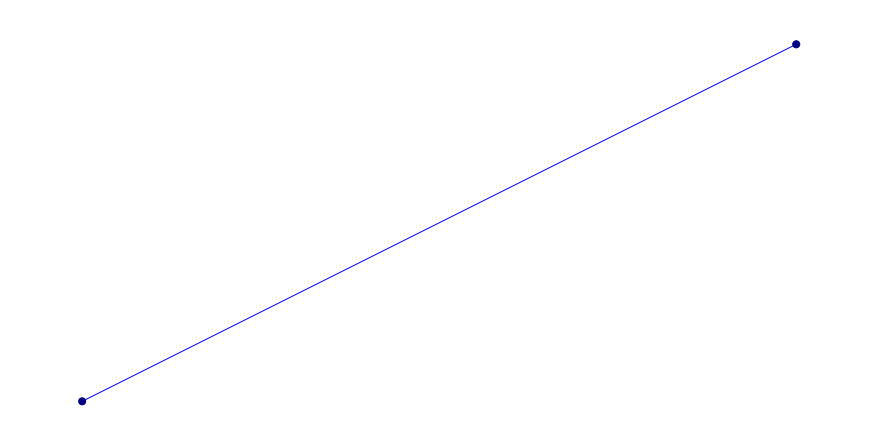

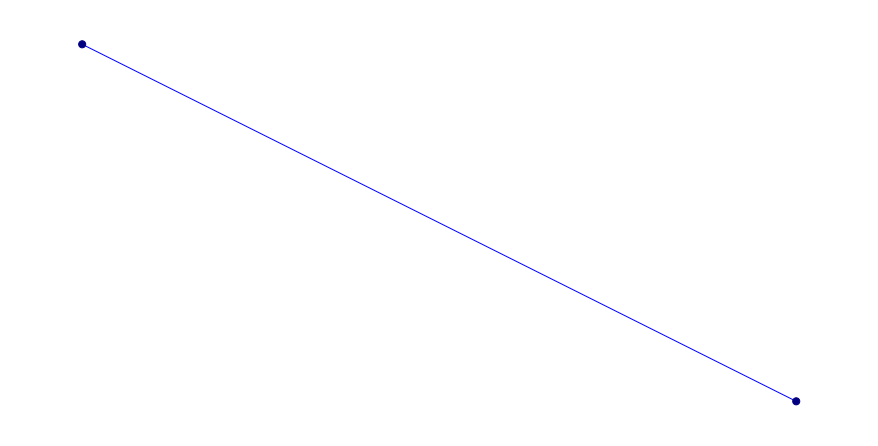

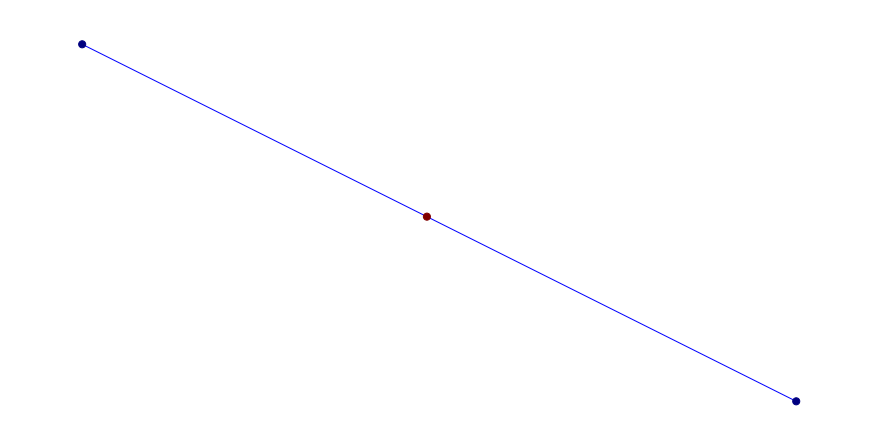

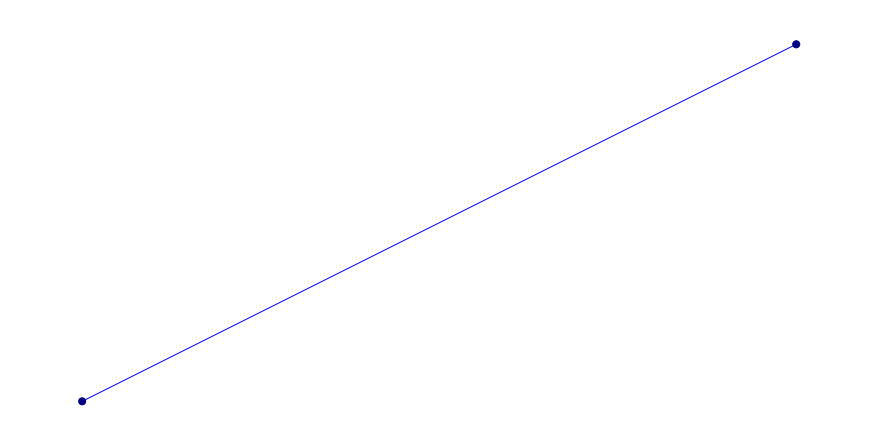

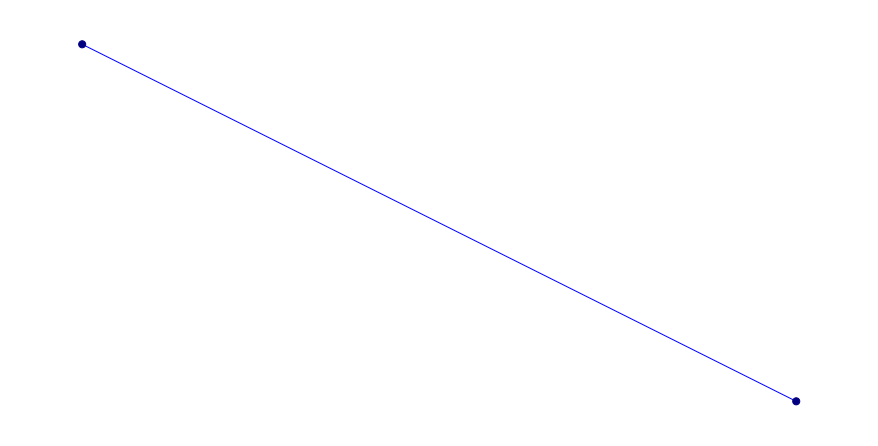

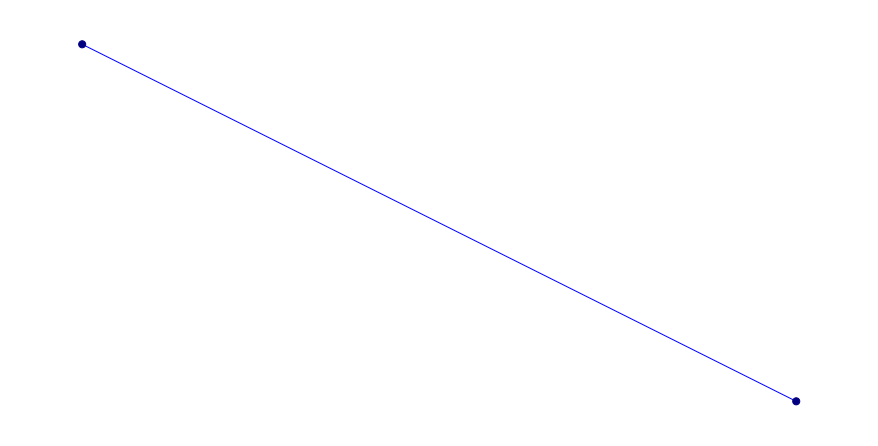

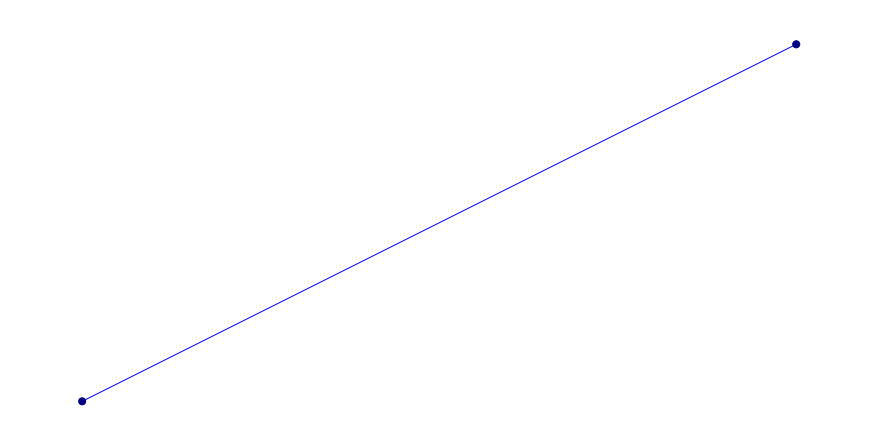

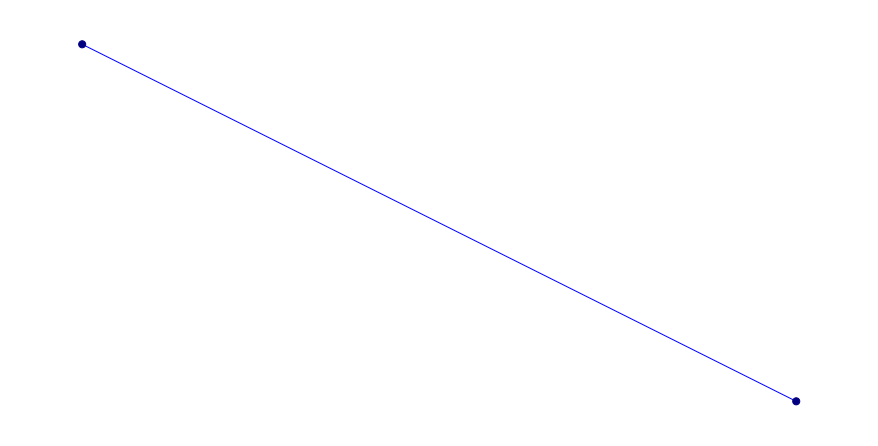

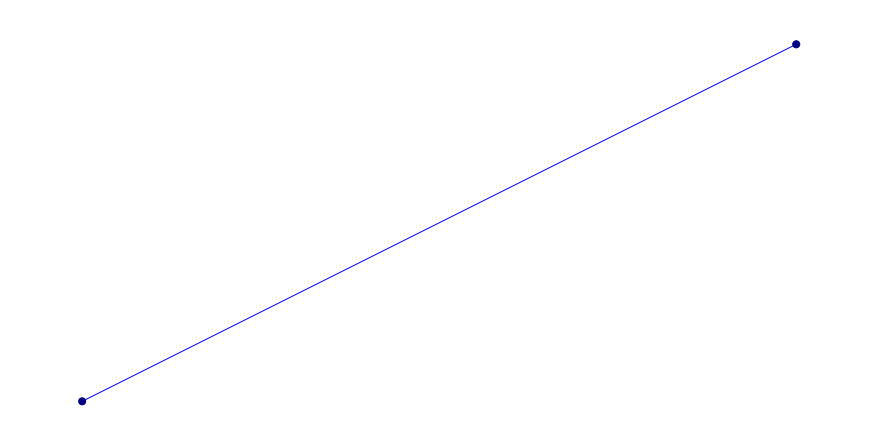

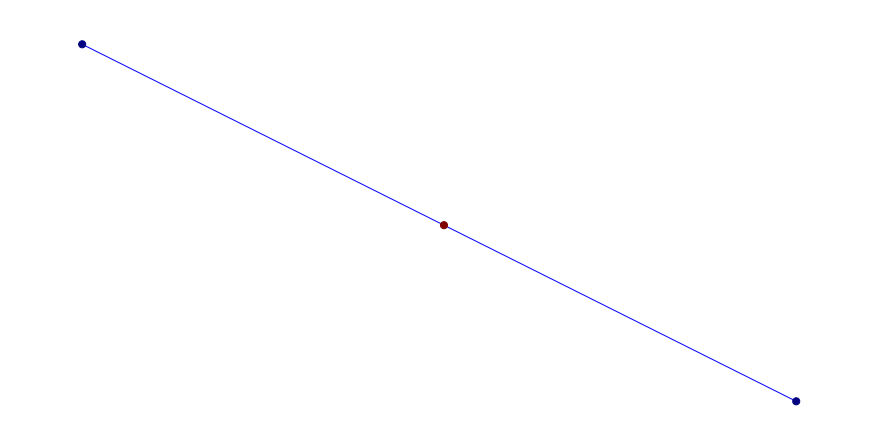

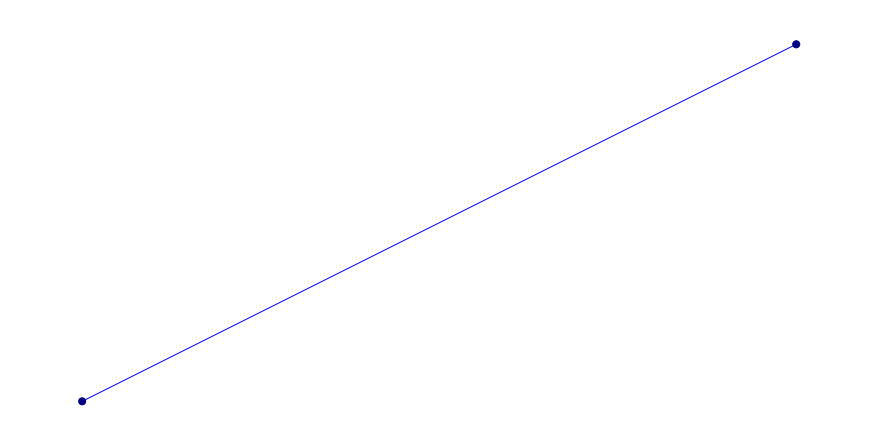

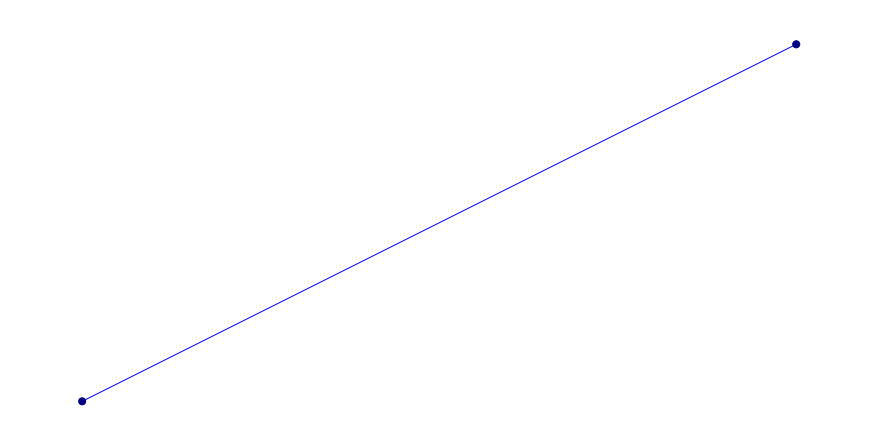

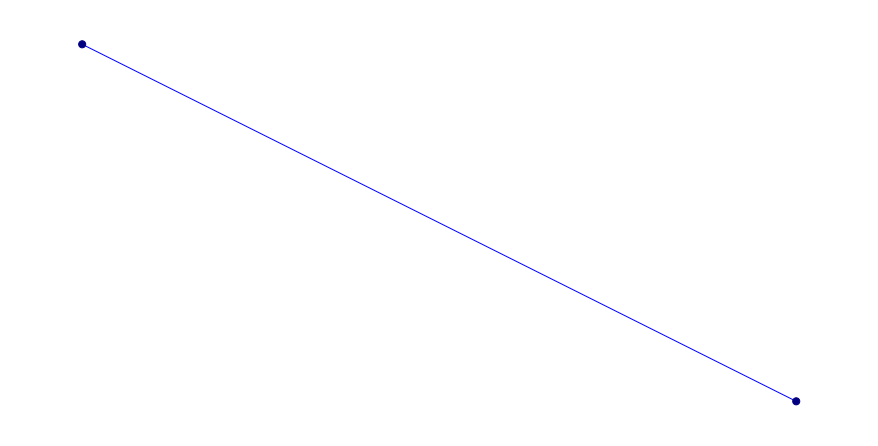

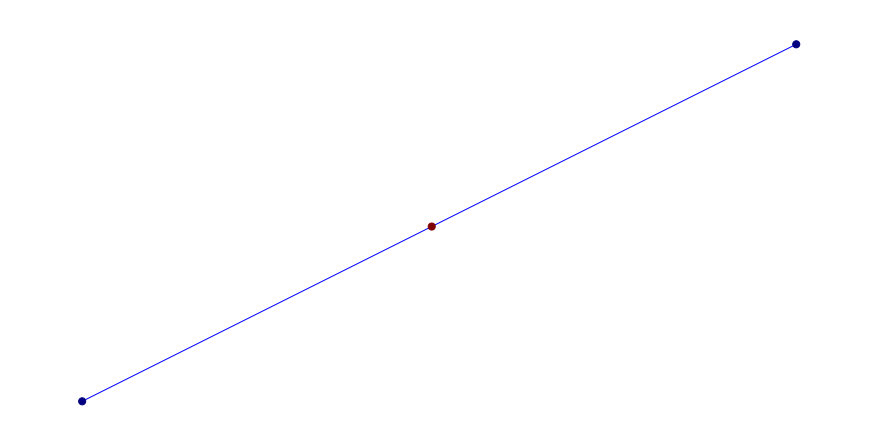

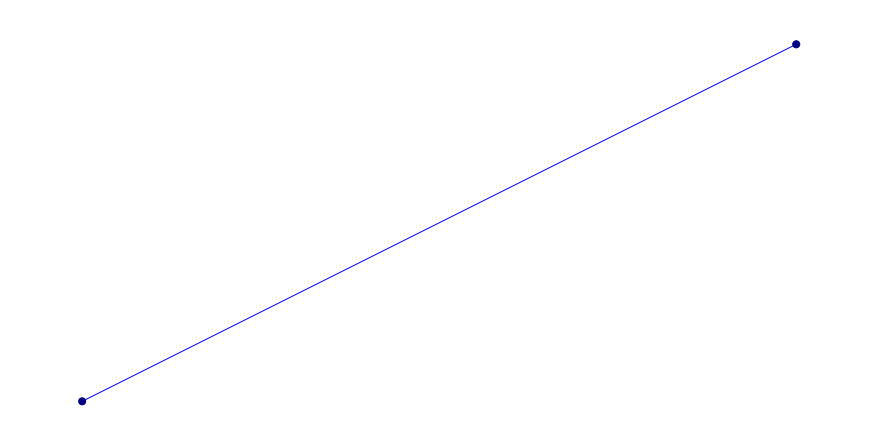

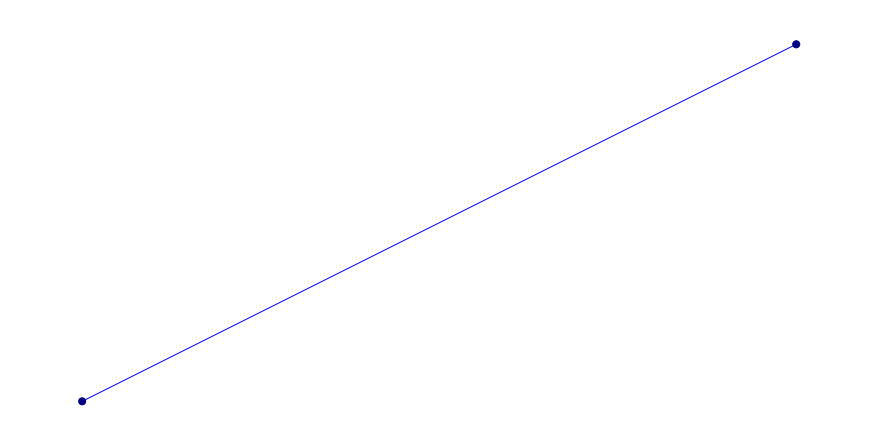

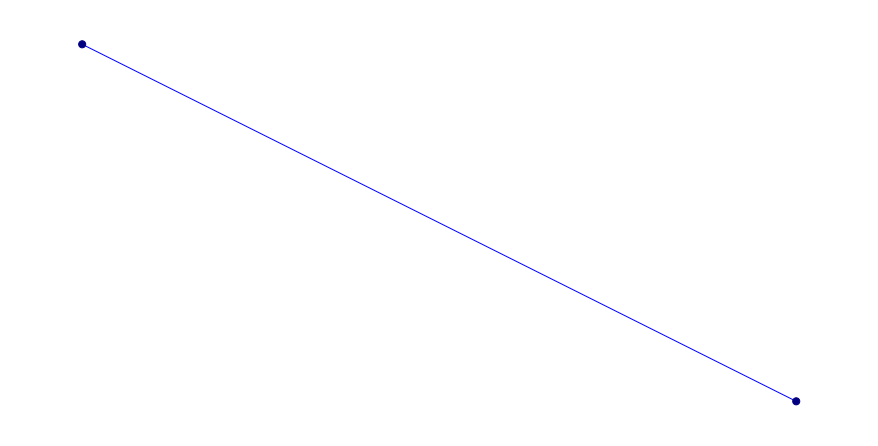

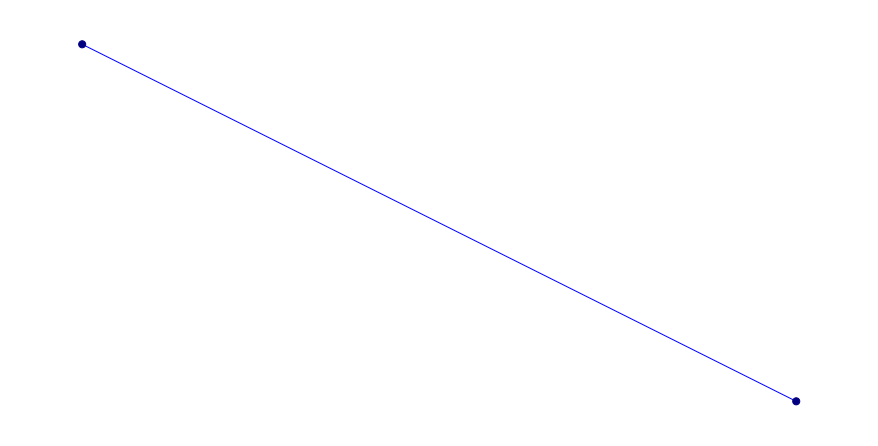

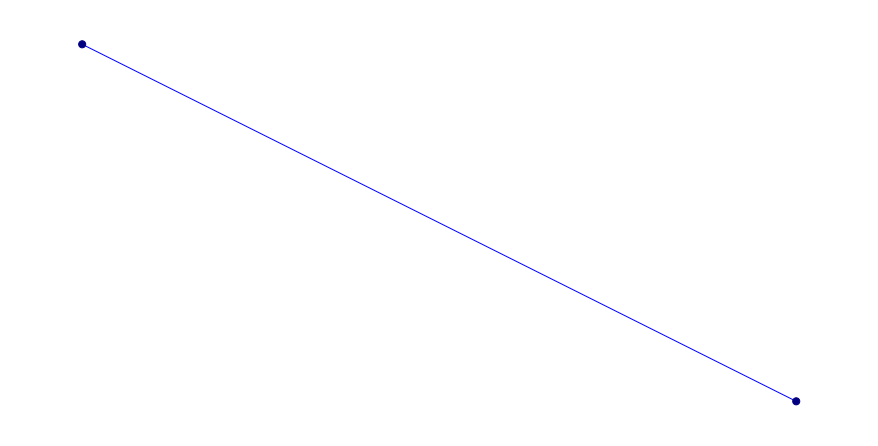

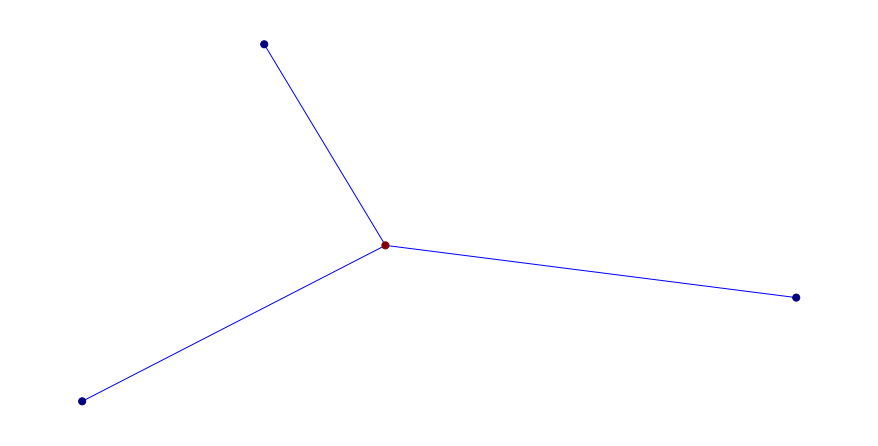

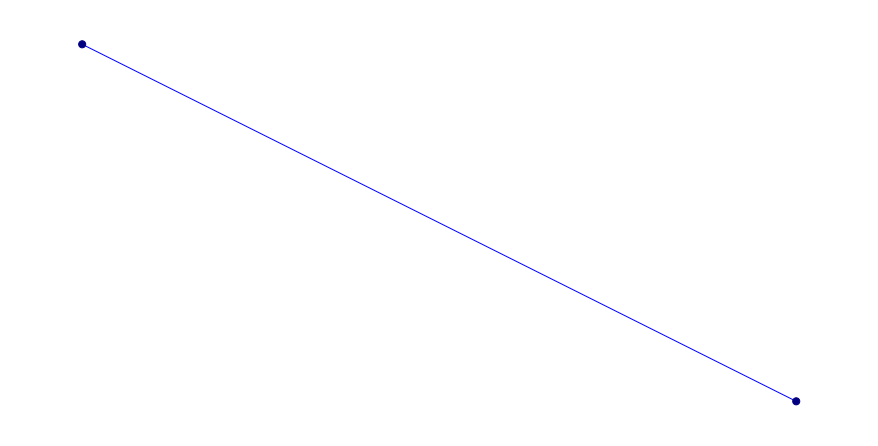

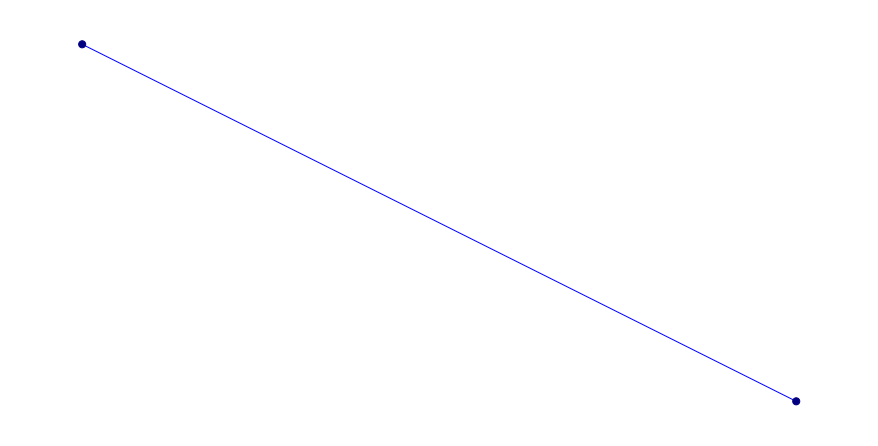

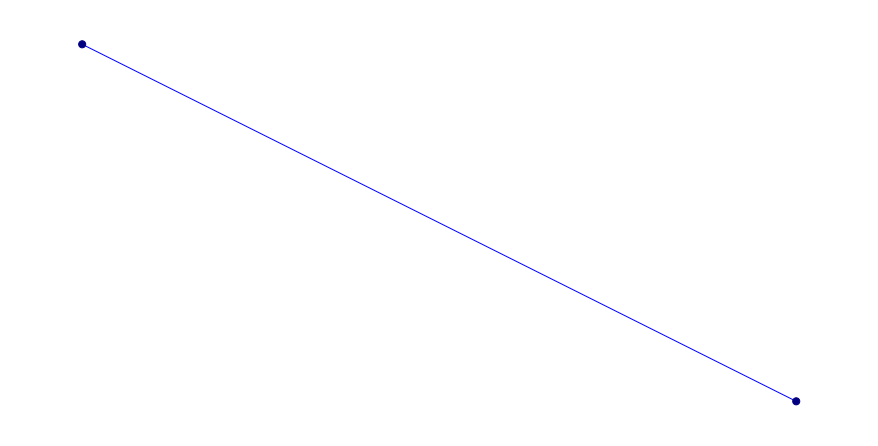

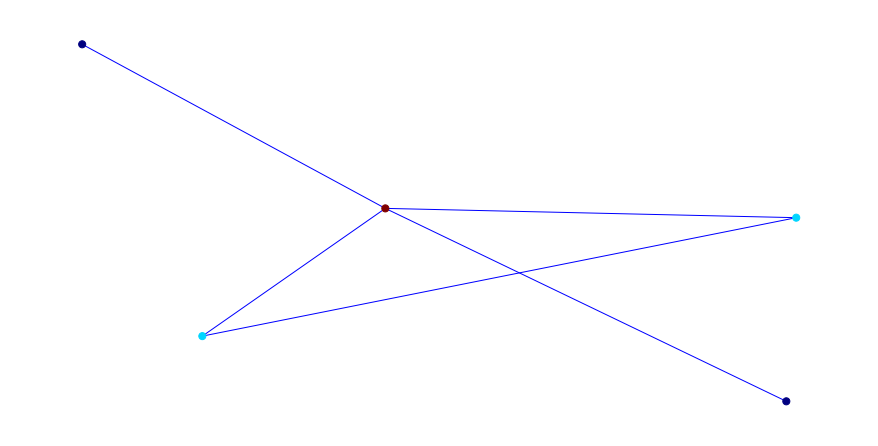

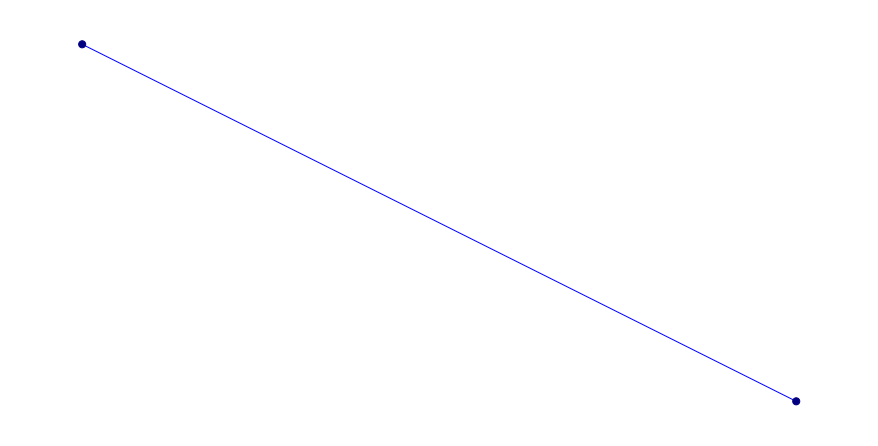

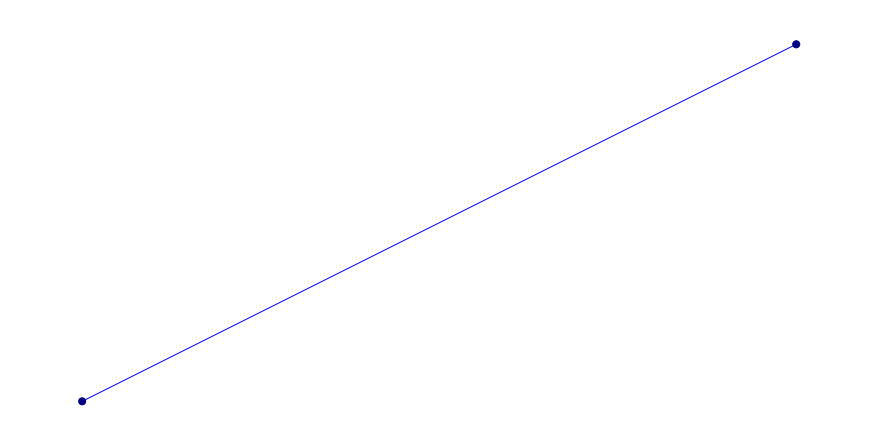

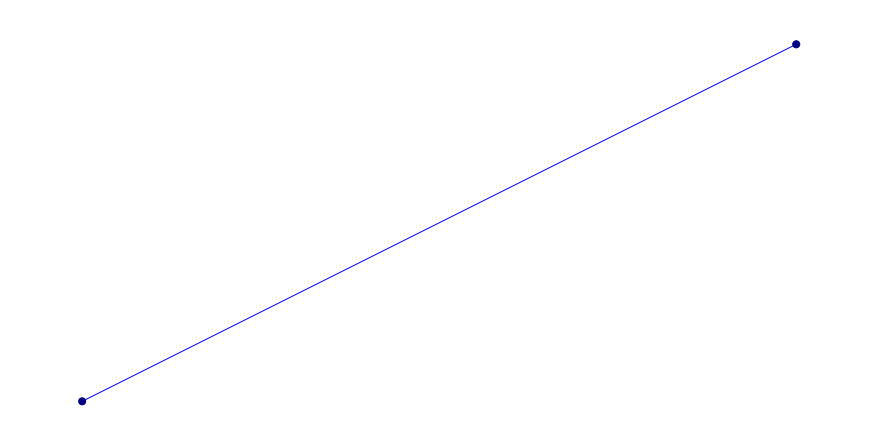

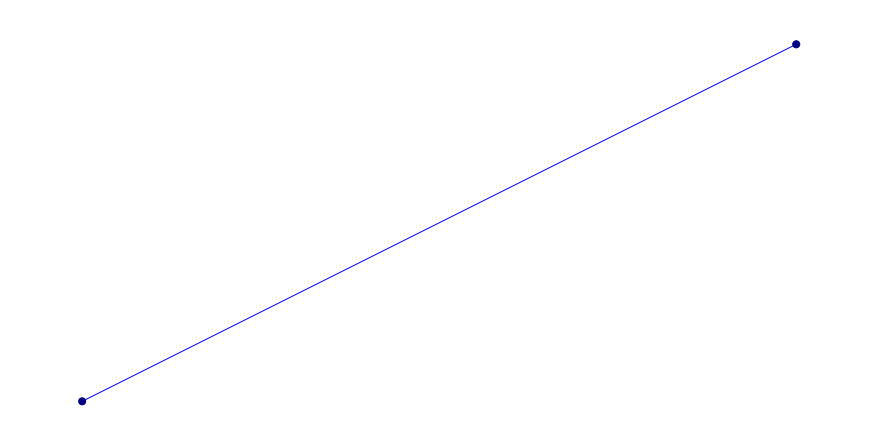

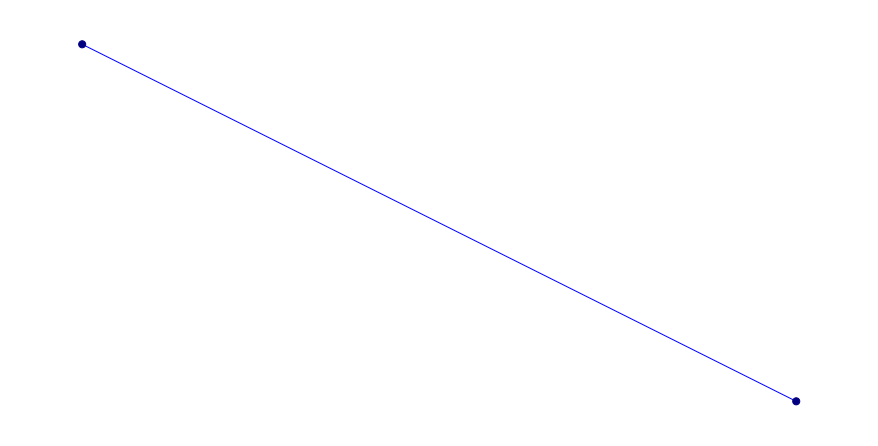

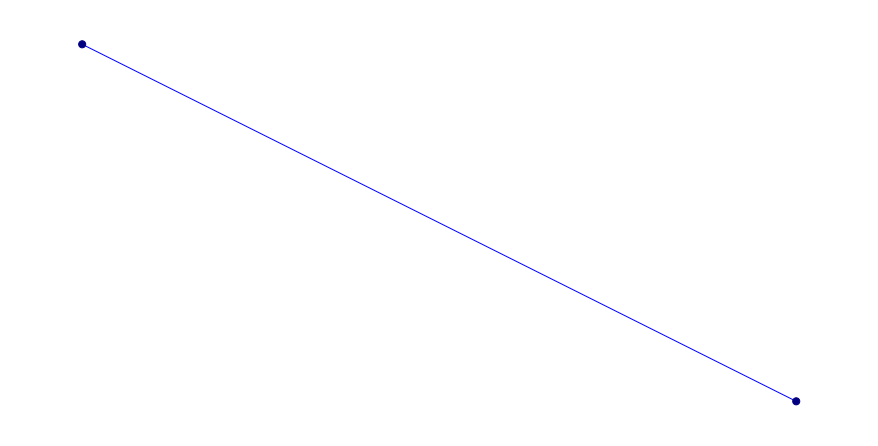

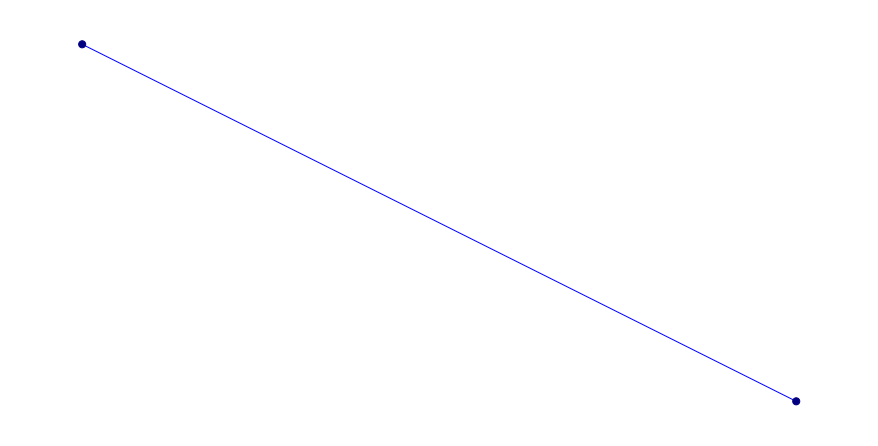

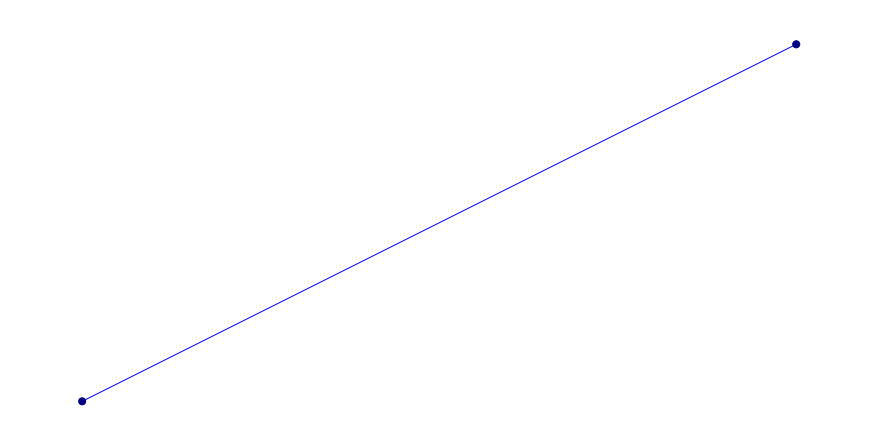

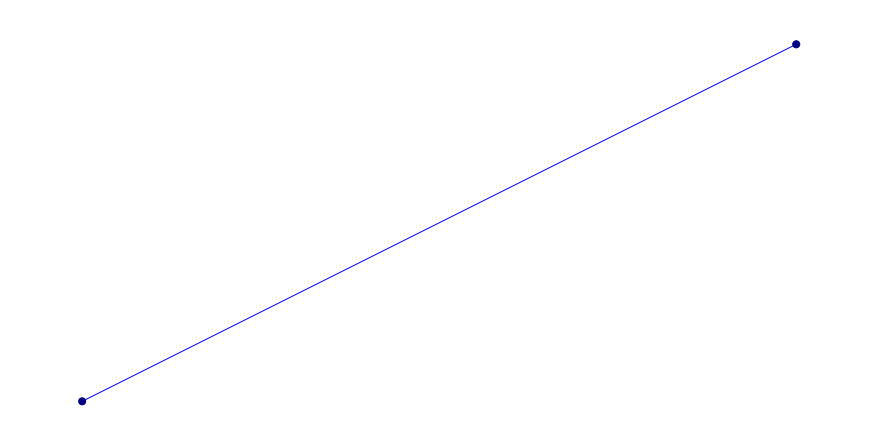

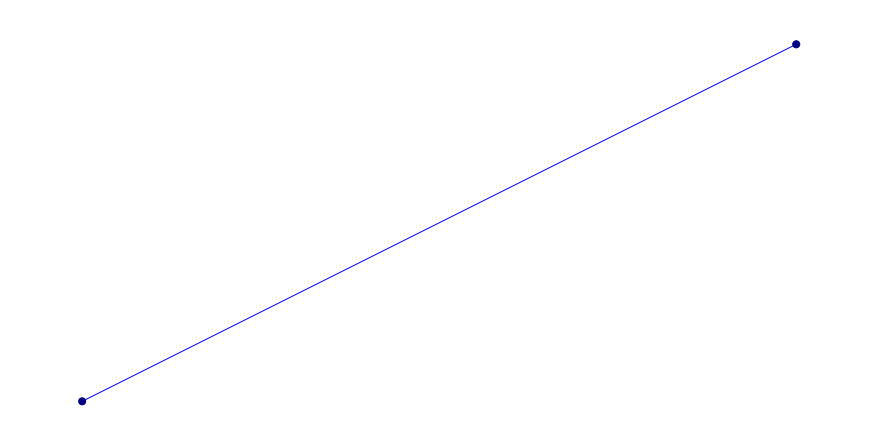

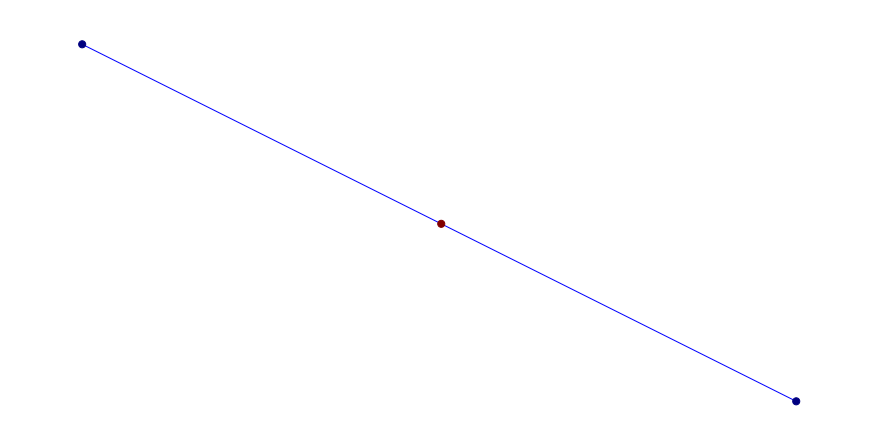

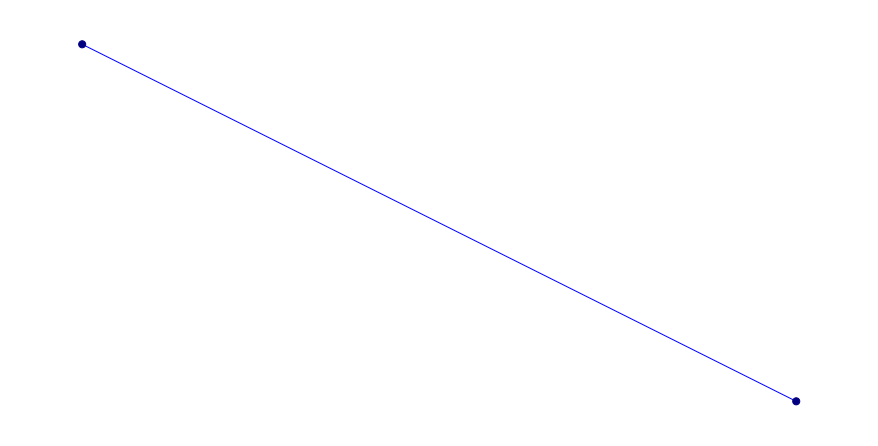

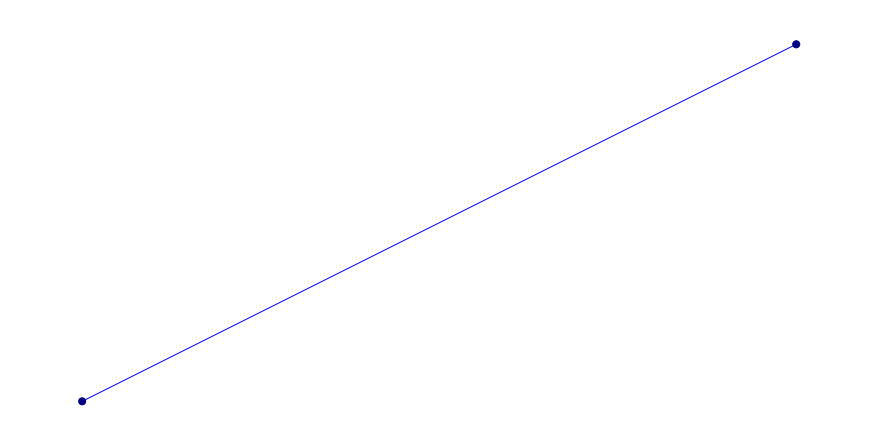

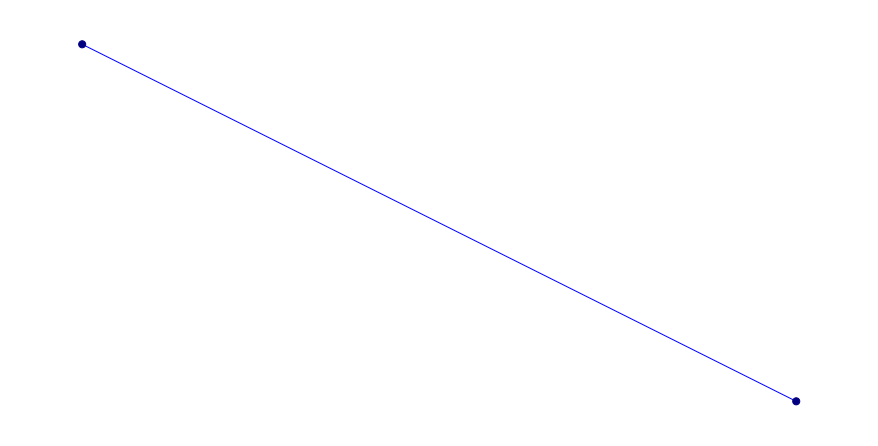

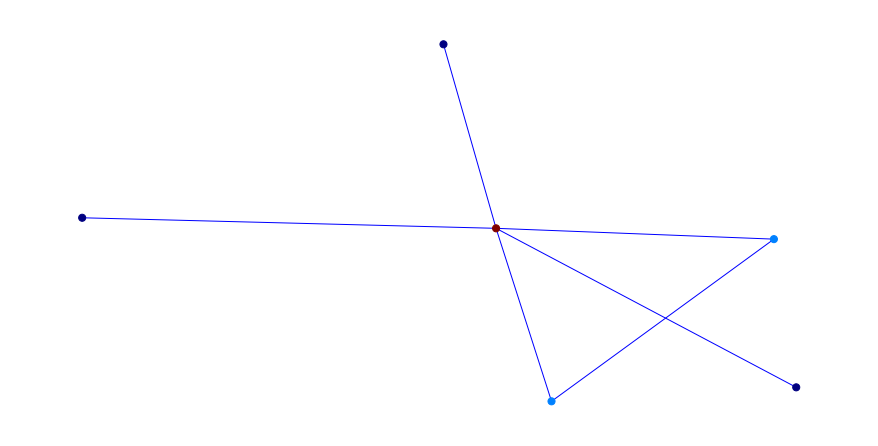

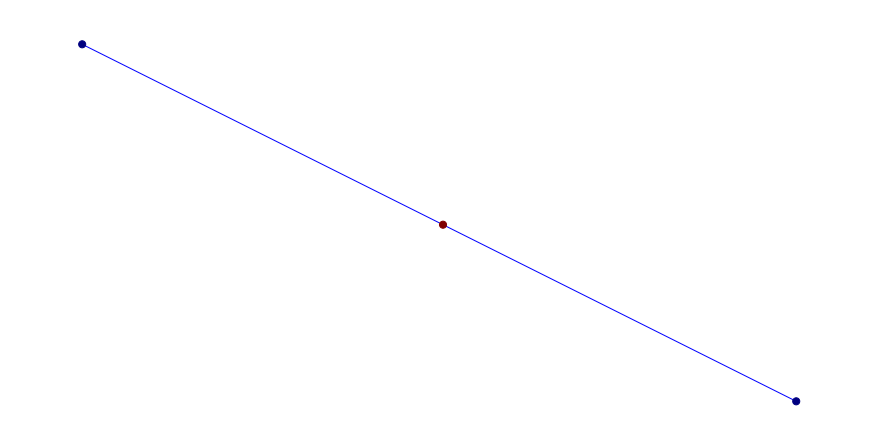

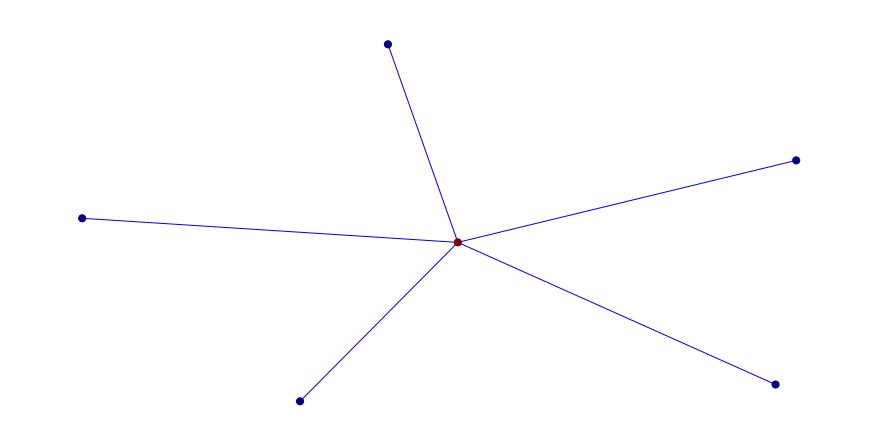

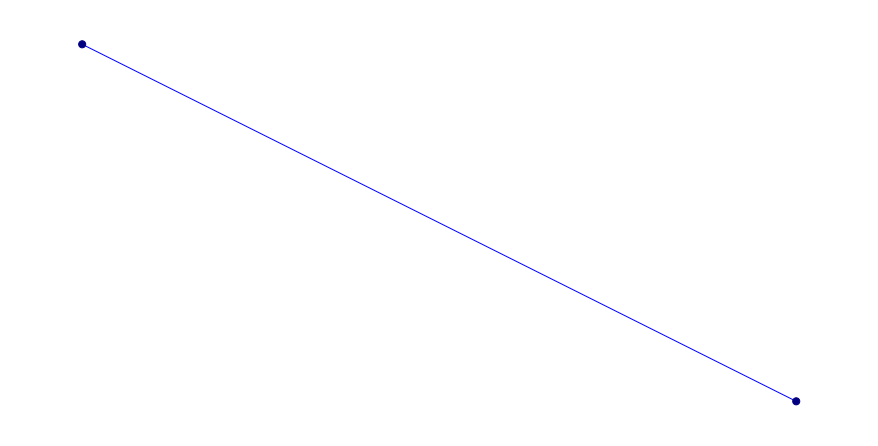

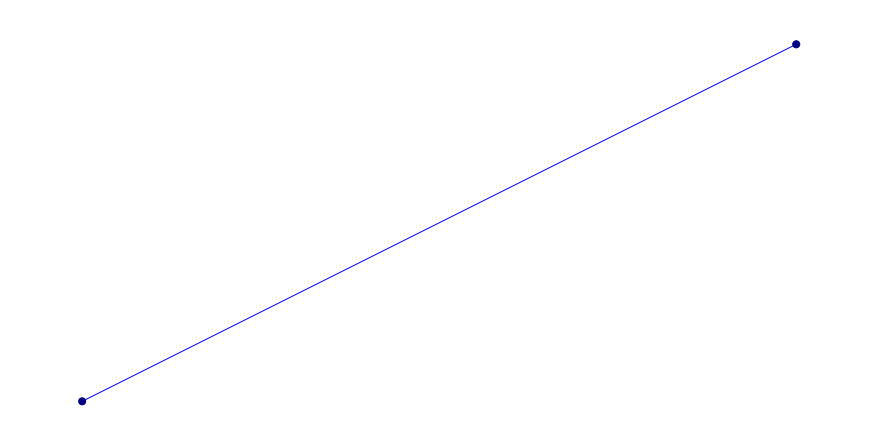

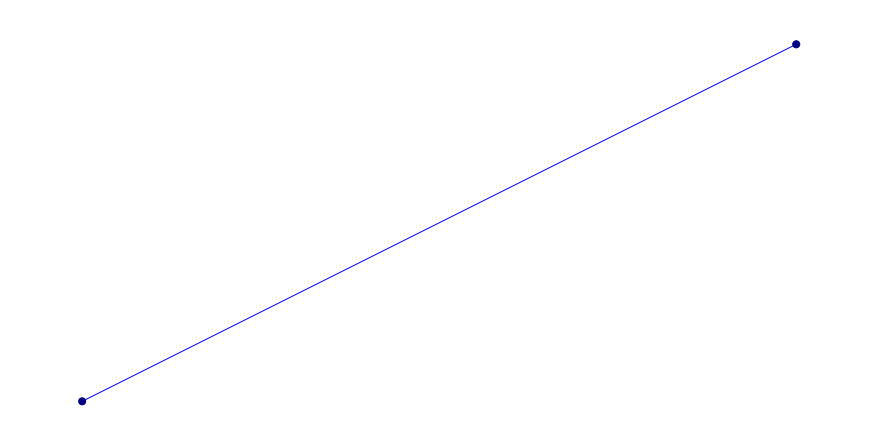

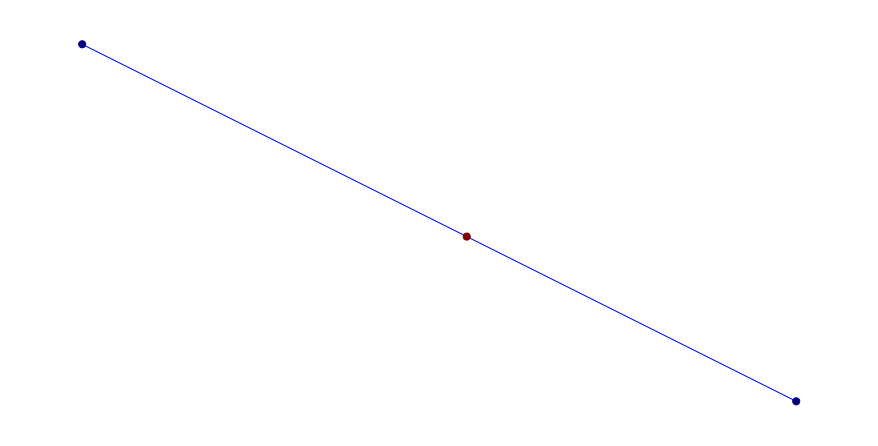

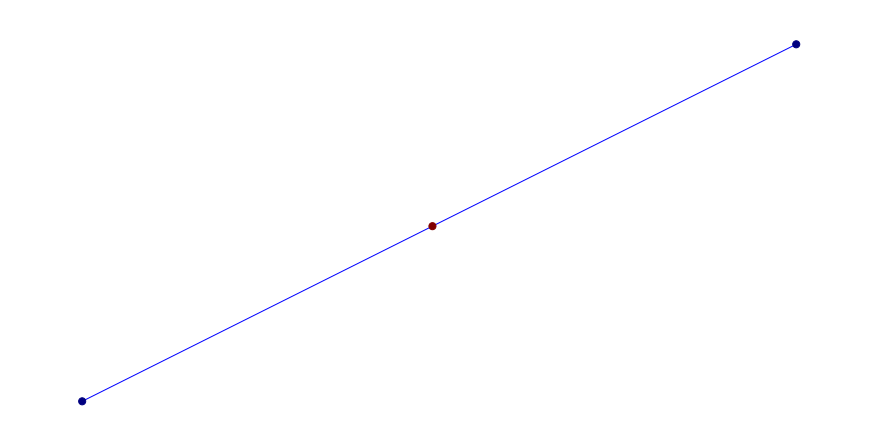

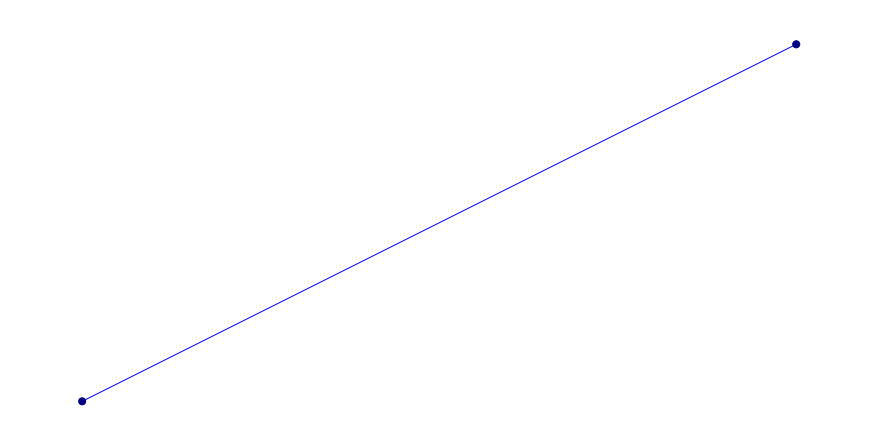

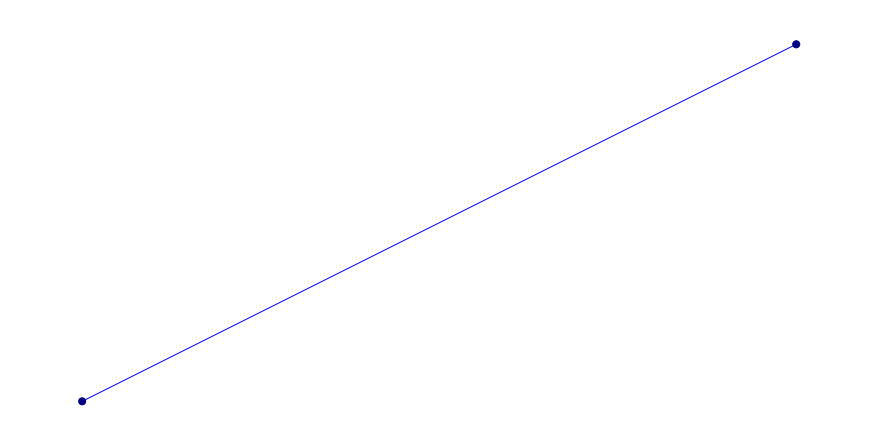

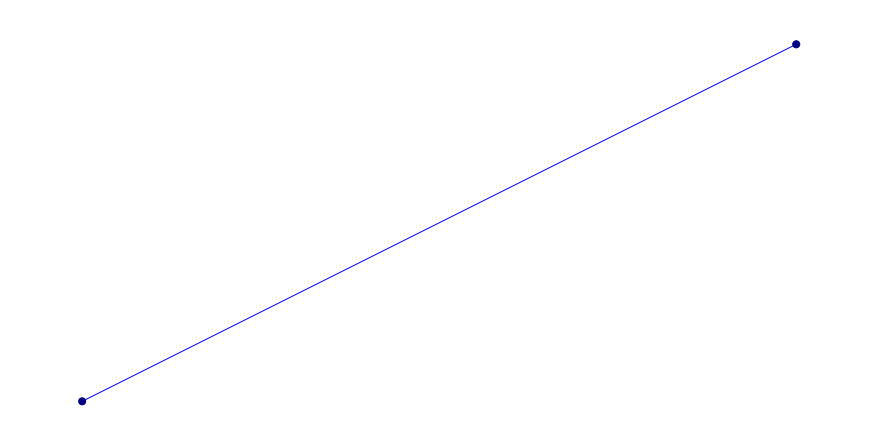

In [80]:
# print found components
#for G4 in nx.connected_component_subgraphs(G):  # for nx < 2.4 version
for G4 in connected_component_subgraphs(G4): # for nx >= 2.4 version
    node_degrees = list(dict(nx.degree(G4)).values())
    nx.draw(G4, node_size=50, edge_color="b", cmap=plt.get_cmap('jet'), node_color = node_degrees)
    plt.show()

4. Use a ready-made software, library or service (eg. gephi) for visualizing one the network in 1. or 2.Comment your results.

## 5. Conclusions
•	We created 4 networks in total. Three were unweighted networks based on the similarity thresholds derived from the MinHash method. We examined similarity thresholds equal to 0.14, 0.17 and 0.19. For similarity thresholds lower than 0.14 the pairs were quite many and the computation time was increasing dramatically, so we remained as low as 0.14. For s=0.14 we can see that there is a big network created in the middle, an other middle size network and a few smaller pairs of abstracts. Interestingly, for s=17, we can see that the networks are clearer and there are a few middle sized networks, as well as quite a few pairs of abstracts. For s=0.19 there are only small pairs of abstracts remaining. Lastly, for the baskets of authors, we created a weighted network with a PCY method and a threshold equal to 0.2. We managed to get a few communities that have several items, but most of the communities are separate pairs. 

In [81]:
! git clone https://github.com/AlexTouvras/FindingSimilarItems

^C


In [ ]:
# ! git add Mining_information.ipynb
# ! git commit -m "some progress on task 3, but not completed"
# ! git push 